# Cluster-Analyse

Wendet verschiedene Cluster-Algorithmen auf die Umfragedaten an mit dem Ziel zum Schluss
"sinnvolle" (d.h. in euren Augen sinnvolle) Cluster zu bilden. Was für Cluster ergeben sich daraus
und wie wurden die Teilnehmer*innen eingeteilt? Wie musstet ihr die Daten dazu bearbeiten?

***

Vorgehen:
- Nur numerische Daten für die Analyse
- Zusammenfassen der Einzelsportarten zu einem sports_factor durch PCA (TODO: nochmal evaluieren)
- Position_num rausnehmen, weil es nur drei Datenpunkte gibt, die keine Studierenden sind und das daher in unseren Augen nicht sinnvoll war, das zu berücksichtigen
- elbow-Methode und Silhouetten-Koeffizient für die einzelnen Teilbereiche anwenden (ind en meisten Fällen ergeben die, dass die optimalen Cluster 2, 3 oder 5 sein könnten)
- Dimensionsreduzierung mit PCA und t-SNE, um zu schauen, wie dort die Cluster-Aufteilung aussieht (in den meisten Fällen sehen hier auch 2,3, oder 5 am besten aus, v.a. in tSNE mit hoher perplexity, damit die globalen Strukturen besser sichtbar werden)
- Visualisieren der Daten (ohne Sportarten, mit sports_factor, ohne Position_num) über barplots (wie sehen die Cluster im Vergleich aus), stripplots (nicht gut erkennbar) und catplots (Cluster-Verteilungen besser erkennbar). Außerdem Anwendung von RandomForestClassifier mit cluster als Label, um zu sehen, welche featues den größten Einfluss auf die Zuordnung zum Cluster hatten. (TODO: hier kann man auch für Machine Learning ausprobieren)

TODO: Cluster-Menge raussuchen. Features raussuchen, die man gegeneinander auftragen kann, damit man die Cluster gut erkennen kann.

- Hierarchical Clustering

In [14]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sb  # data visualization library  
import matplotlib.pyplot as plt  # data visualization library 

In [15]:
#Clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN

In [16]:
file_name = "./data/survery_data_annonymized_230626_clean.csv"
data = pd.read_csv(file_name)
data.head(5)

#pd.show_versions()

Alter Geschlecht          Pseudonym    Position Studiengang  Sportlichkeit   
0     28   männlich      lalala-lololo  Student*in         MMI              4  \
1     26   männlich              hbstr  Student*in         MMI              3   
2     24   männlich              Panda  Student*in         MMI              2   
3     23   männlich  TomTom Navigation  Student*in         MMI              5   
4     24   weiblich            LcAbrgr  Student*in         MMI              3   

                                          Sportarten       Fav_Sportart   
0  Basketball;Yoga;Bouldern/Klettern;Rennrad/Moun...      Joggen/Laufen  \
1  Fußball;Volleyball;Yoga;Bouldern/Klettern;Renn...            Fußball   
2     Fußball;Handball;Yoga;Tanzen;Bouldern/Klettern       Keine Angabe   
3       Leichtathletik;Bouldern/Klettern;Wintersport          Trampolin   
4                                  Bouldern/Klettern  Bouldern/Klettern   

   Gesunde_Ernaehrung  Essen_gehen  ...  Yoga  Kampfsport Tanzen   
0                   4            3  ...     1           0      0  \
1                   4            4  ...     1           0      0   
2                   5            4  ...     1           0      1   
3                   2            4  ...     0           0      0   
4                   4            3  ...     0           0      0   

   Leichtathletik Bouldern/Klettern  Schwimmen  Wassersport  Reiten   
0               0                 1          0            0       0  \
1               0                 1          0            0       0   
2               0                 1          0            0       0   
3               1                 1          0            0       0   
4               0                 1          0            0       0   

   Wintersport  Rennrad/Mountainbike  
0            0                     1  
1            0                     1  
2            0                     0  
3            1                     0  
4            0                     0  

[5 rows x 67 columns]

In [17]:
data.columns

Index(['Alter', 'Geschlecht', 'Pseudonym', 'Position', 'Studiengang',
       'Sportlichkeit', 'Sportarten', 'Fav_Sportart', 'Gesunde_Ernaehrung',
       'Essen_gehen', 'Kochen', 'Feiern', 'Fav_Essen', 'Musik', 'Fav_Musik',
       'Lesen', 'Darstellende_Kunst', 'Filme', 'Bildende_Kunst', 'Museen',
       'Videospiele', 'Soziale_Medien', 'Technologie', 'Astronomie',
       'Naturwissenschaften', 'Soziales_Engagement', 'Soziale_Gerechtigkeit',
       'Introvertiert_Extrovertiert', 'FOMO', 'Spontan', 'Verwirrt',
       'Glücklich', 'Geduldig', 'Streitlustig', 'Abenteuerlustig',
       'Studium_Zweifel', 'Studium_Zufriedenheit', 'Akademische_Laufbahn',
       'Lerngruppe', 'Prokrastination', 'Abgaben_spaet',
       'Neugier_Lebensmittel', 'Natur', 'Verreisen', 'Handwerk',
       'Sprachnachrichten', 'Wichtigkeit_Geld', 'Geschlecht_num',
       'Position_num', 'Studiengang_num', 'Basketball', 'Fußball', 'Handball',
       'Football', 'Hockey', 'Volleyball', 'Tennis', 'Yoga', 'Kampfsport',
  

In [18]:
#Sportarten_Liste ohne Floorball
sportarten_list = ["Basketball",
              "Fußball",
              "Handball",
              "Football",
              "Hockey",
              "Volleyball",
              "Tennis",
              "Yoga",
              "Kampfsport",
              "Tanzen",
              "Leichtathletik",
              "Bouldern/Klettern",
              "Schwimmen",
              "Wassersport",
              "Reiten",
              "Wintersport",
              "Rennrad/Mountainbike"]

## Aufteilung in Kategorien

Zusätzl. Daten
- Alter
- ~Geschlecht~ (nicht numerisch)
- Geschlecht_num
- ~Pseudonym~ (nicht numerisch)
- ~Position~ (nicht numerisch)
- Position_num
- ~Studiengang~ (nicht numerisch)
- Studiengang_num

Sport
- Sportlichkeit
- ~Sportarten~ (wurden übersetzt in Num)
- sportarten_list
- ~Fav_Sportart~ (nur für NLP)

Ernährung/ Lifestyle
- Gesunde_Ernaehrung
- Essen_gehen
- Kochen
- Feiern
- ~Fav_Essen~ (nur für NLP)
- Neugier_Lebensmittel
- Natur
- Verreisen

Kultur
- Musik
- ~Fav_Musik~ (nur für NLP)
- Lesen
- Darstellende_Kunst
- Filme
- Bildende_Kunst
- Museen
- Handwerk

Technologie/Wissenschaft
- Videospiele
- Soziale_Medien
- Technologie
- Astronomie
- Naturwissenschaften

Sozial
- Soziales_Engagement
- Soziale_Gerechtigkeit
- Introvertiert_Extrovertiert
- FOMO
- Spontan
- Verwirrt
- Glücklich
- Geduldig
- Streitlustig
- Abenteuerlustig
- Sprachnachrichten

Studium/ Karriere
- Studium_Zweifel
- Studium_Zufriedenheit
- Akademische_Laufbahn
- Lerngruppe
- Prokrastination
- Abgaben_spaet
- Wichtigkeit_Geld

In [162]:
#VORBEREITUNG KATEGORIEN

# all data
# Creating a copy of data (with only numerical values, so ignore non-numerical values from above)
data_num = data.copy().select_dtypes(include='number')

data_num_without_sports = data.copy().select_dtypes(include='number')
data_num_without_sports = data_num_without_sports.drop(columns=sportarten_list, axis=1)

# cleaning
#Die rauslassen, weil es einfach so wenige Unterschiede in den Daten gibt 
columns_position_num = ['Position_num']

data_num.drop(columns=columns_position_num, axis=1)
data_num_without_sports.drop(columns=columns_position_num, axis=1,inplace=True)


#COLUMNS CATEGORIES
# general data
columns_age = ['Alter']

columns_sex_num = ['Geschlecht_num']

columns_studiengang_num = ['Studiengang_num']


# sports
columns_sports = ['Sportlichkeit'] 
columns_sports.extend(sportarten_list)


# ernaehrung_lifestyle
columns_lifestyle = ['Gesunde_Ernaehrung', 
                     'Essen_gehen', 
                     'Kochen', 
                     'Neugier_Lebensmittel', 
                     'Feiern', 
                     'Natur', 
                     'Verreisen'
                    ] 

# kultur
columns_kultur = ['Musik', 
                  'Lesen', 
                  'Darstellende_Kunst', 
                  'Filme', 
                  'Bildende_Kunst', 
                  'Museen',
                  'Handwerk']

 
# technology
columns_tech_sci = ['Videospiele', 
                    'Soziale_Medien', 
                    'Technologie', 
                    'Astronomie', 
                    'Naturwissenschaften']


#sozial
columns_social = ['Soziales_Engagement', 
                  'Soziale_Gerechtigkeit', 
                  'Introvertiert_Extrovertiert', 
                  'FOMO', 
                  'Sprachnachrichten']
 
columns_personality = ['Spontan', 
                       'Verwirrt', 
                       'Glücklich', 
                       'Geduldig',
                      'Streitlustig', 
                      'Abenteuerlustig']


#studium/karriere
columns_studium = ['Studium_Zweifel', 
                   'Studium_Zufriedenheit', 
                   'Akademische_Laufbahn', 
                   'Lerngruppe', 
                   'Prokrastination', 
                   'Abgaben_spaet',
                   'Wichtigkeit_Geld',]


# Clustering
## K-Means

In [163]:
# allgemein Variablen
kmeans_kwargs = {
    "init": "k-means++", # chooses good seeds
    "n_init": 10,
    "max_iter": 300,
    "random_state": 0}

In [164]:
# scaling and fitting
# Scaling: hier werden die numerischen Werte umgerechnet, 
# weil wir viele absolute Werte haben die sehr unterschiedliche Bandbreiten haben
# wenn wir dann mit einem clustering-Algorithmus nach Nähe suchen, hätte das bei absoluten Werten
#Ausirkungen, weil alle Werte gleich behandelt werden und dadurch das Clustering stark verzerrt wird
# deshalb rechnen wir alle Werte runter auf eine Gauss-Verteilung, dass der Mittelwert immer bei 0 liegt

#ALL numerical columns
scaler_all = StandardScaler()
scaler_all.fit(data_num)
data_all_scaled = pd.DataFrame(scaler_all.transform(data_num),
                           columns= data_num.columns )

#numerical columns without sports
scaler_all_without_sports = StandardScaler()
scaler_all_without_sports.fit(data_num_without_sports)
data_all_without_sports_scaled = pd.DataFrame(scaler_all_without_sports.transform(data_num_without_sports),
                           columns= data_num_without_sports.columns )

In [165]:
#elbow method to find best cluster-value
# A list holds the SSE values for each k
def elbow_method(data, label):
    sse = []
    for k in range(1, 11):
        kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
        kmeans.fit(data)
        sse.append(kmeans.inertia_)

    plt.style.use("fivethirtyeight")
    plt.plot(range(1, 11), sse)
    plt.xticks(range(1, 11))
    plt.xlabel("Number of Clusters")
    plt.ylabel("SSE " + label)
    plt.show()
    
    return sse


In [166]:
# silhouette score
# A list holds the silhouette coefficients for each k
def silhouette_score_method(data, label):
    silhouette_coefficients = []

    # Notice you start at 2 clusters for silhouette coefficient
    for k in range(2, 11):
        kmeans_all = KMeans(n_clusters=k, **kmeans_kwargs)
        kmeans_all.fit(data)
        score_all = silhouette_score(data, kmeans_all.labels_)
        silhouette_coefficients.append(score_all)
        
    print('lol')

    plt.style.use("fivethirtyeight")
    plt.plot(range(2, 11), silhouette_coefficients)
    plt.xticks(range(2, 11))
    plt.xlabel("Number of Clusters")
    plt.ylabel("Silhouette Coefficient " + label)
    plt.show()
    
    return silhouette_coefficients

In [167]:
def elbow_and_silhouette(data, label):
    return elbow_method(data, label), silhouette_score_method(data, label)

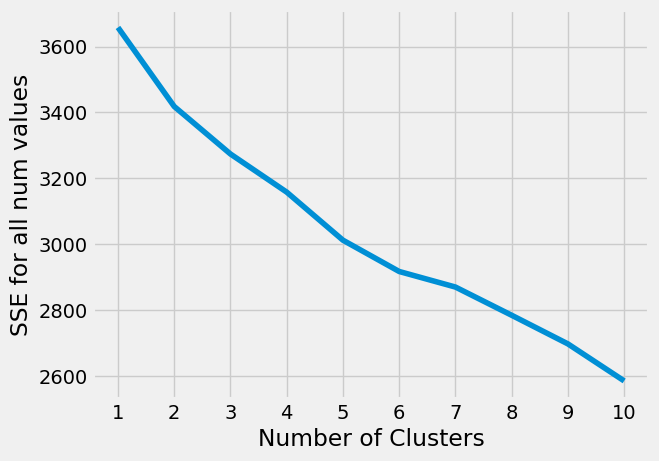

lol


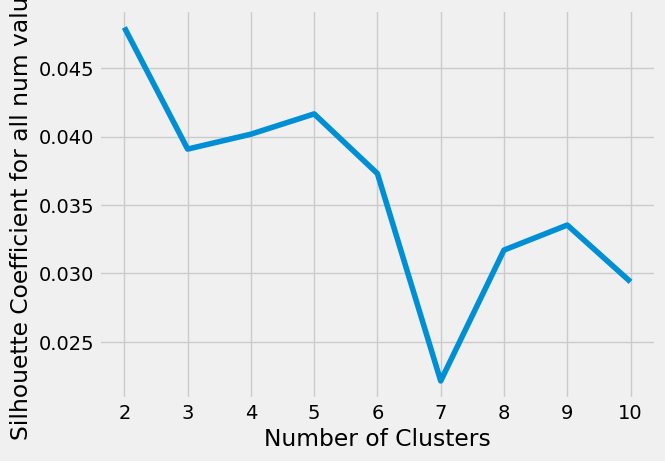

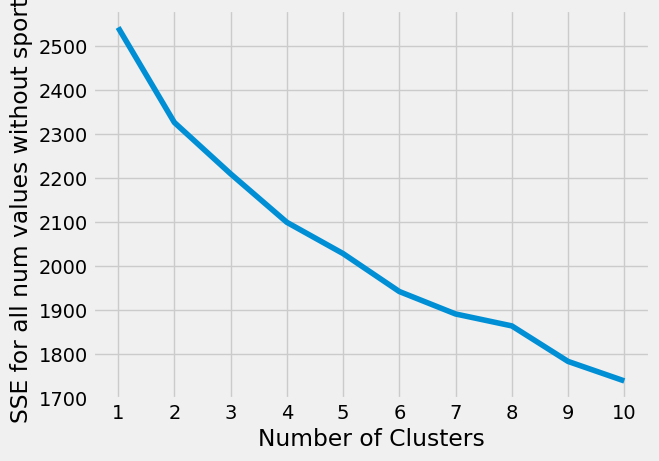

lol


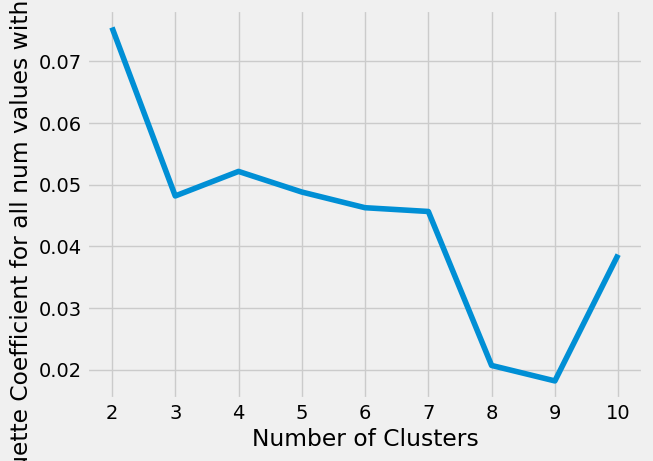

([2542.0,
  2326.428096148116,
  2209.9150455424774,
  2099.85757383272,
  2028.845944269499,
  1942.7419436676573,
  1891.8010768003414,
  1864.7423055567801,
  1784.1278267535872,
  1739.8925700711802],
 [0.07550802859646524,
  0.04817739744714839,
  0.052156708875401185,
  0.04881310201178609,
  0.04626883688240476,
  0.04565878397873471,
  0.020682400978042987,
  0.01817578949578666,
  0.038660209326860734])

In [168]:
label_all= "for all num values"
elbow_and_silhouette(data_all_scaled, label_all)
# die Methoden für alle Daten suggesten, dass 2 oder 5 Cluster am meisten Sinn machen

label_all_without_sports = "for all num values without sports"
elbow_and_silhouette(data_all_without_sports_scaled, label_all_without_sports)
# die Methoden für alle Daten ohne die Sportarten suggesten, dass 2 oder 6 Cluster am meisten Sinn machen


In [169]:
# Test, den sports_factor mit reinzunehmen, der die Angaben zu Sportarten durch PCA zusammenfasst

#PCA auf die Sportarten
#Die Idee wieso wir das machen ist, dass die einzelnen Sportarten sehr hoch im Ranking sind teilweise, aber nicht wirklich nachvollziehbar 
#(zB Basketball, Yoga, Kampfsport), während so sachen wir Fußball nicht hoch im Ranking sind.
#das lässt uns vermuten, dass diese Werte, von denen es nur wenige positive gibt und viele Nullen, irgendwo mit den wichtigsten
#Prädiktoren zusammenhängen, ohne dass es Aussagekraft hat (wel eben so wenige Werte da sind)
# Um das unnötige Noise zu verringern, das zu overfitting führen würde, reduzieren wir die Sportarten alle auf eine Dimension herunter

from sklearn.decomposition import PCA

sportarten = data.copy()[sportarten_list]

pca = PCA(n_components=1)
X_pca = pca.fit_transform(sportarten) # fit_transform lernt und wandelt sofort danach um

#data with sports factor
data_num_wsf= data_num_without_sports.copy()
data_num_wsf['sports_factor'] = X_pca

scaler_wsf = StandardScaler()
scaler_wsf.fit(data_num_wsf)
data_num_wsf_scaled = pd.DataFrame(scaler_wsf.transform(data_num_wsf),
                           columns= data_num_wsf.columns )

data_num_wsf_scaled

Alter  Sportlichkeit  Gesunde_Ernaehrung  Essen_gehen    Kochen   
0   0.555073       0.728893            0.552967    -0.871197  0.181800  \
1   0.105210      -0.298183            0.552967     0.147939  1.206488   
2  -0.344653      -1.325259            1.777393     0.147939  0.181800   
3  -0.569585       1.755968           -1.895886     0.147939  0.181800   
4  -0.344653      -0.298183            0.552967    -0.871197 -1.867577   
..       ...            ...                 ...          ...       ...   
57  0.105210      -2.352335            0.552967     0.147939  1.206488   
58 -0.794517      -0.298183           -0.671460     0.147939  0.181800   
59 -0.119722      -0.298183           -0.671460     0.147939 -0.842889   
60  1.229868      -0.298183            0.552967     1.167075  1.206488   
61 -0.119722      -1.325259           -1.895886    -1.890333 -0.842889   

      Feiern     Musik     Lesen  Darstellende_Kunst     Filme  ...   
0   0.153296  1.071517  0.727409            0.314127 -0.827253  ...  \
1  -0.710737  0.000000 -0.912567            0.314127  0.287740  ...   
2   0.153296  1.071517 -0.912567            0.314127  0.287740  ...   
3  -0.710737 -1.071517 -0.092579           -0.532650  0.287740  ...   
4  -1.574770 -1.071517  0.727409           -0.532650  1.402733  ...   
..       ...       ...       ...                 ...       ...  ...   
57 -0.710737  1.071517 -0.092579            1.160903  1.402733  ...   
58  0.153296  0.000000 -1.732556           -1.379426 -1.942245  ...   
59 -0.710737  0.000000  0.727409            0.314127 -0.827253  ...   
60  0.153296  1.071517  0.727409            1.160903  1.402733  ...   
61 -1.574770  0.000000 -0.912567           -0.532650 -0.827253  ...   

    Abgaben_spaet  Neugier_Lebensmittel     Natur  Verreisen  Handwerk   
0       -1.228279              1.041785  2.050392       -1.0 -0.945274  \
1       -1.228279              0.016536 -0.104257        0.0  0.886194   
2       -2.103605             -1.008712 -1.181582        0.0 -0.945274   
3       -0.352954              1.041785  0.973067        1.0 -0.945274   
4        1.397697             -2.033961 -0.104257        1.0 -0.029540   
..            ...                   ...       ...        ...       ...   
57      -2.103605              0.016536 -0.104257       -1.0 -0.029540   
58      -0.352954              0.016536 -0.104257        1.0  0.886194   
59       0.522372              0.016536  2.050392        0.0  0.886194   
60      -1.228279              1.041785  0.973067        1.0 -0.029540   
61       0.522372             -2.033961 -0.104257       -1.0  0.886194   

    Sprachnachrichten  Wichtigkeit_Geld  Geschlecht_num  Studiengang_num   
0            0.287883         -0.375639        0.639602         1.064933  \
1            0.287883          0.636952        0.639602         1.064933   
2            1.099190         -0.375639        0.639602         1.064933   
3            0.287883         -0.375639        0.639602         1.064933   
4            0.287883          0.636952       -1.563472         1.064933   
..                ...               ...             ...              ...   
57          -1.334731         -0.375639        0.639602         1.064933   
58          -1.334731          1.649543        0.639602         0.134992   
59          -0.523424         -1.388229       -1.563472         0.134992   
60          -0.523424         -0.375639       -1.563472        -1.724892   
61          -0.523424         -2.400820        0.639602         0.134992   

    sports_factor  
0        0.434666  
1        0.021175  
2        0.948682  
3        0.959452  
4        0.999219  
..            ...  
57       0.423754  
58      -0.500867  
59      -0.169108  
60       1.062833  
61       0.522146  

[62 rows x 42 columns]

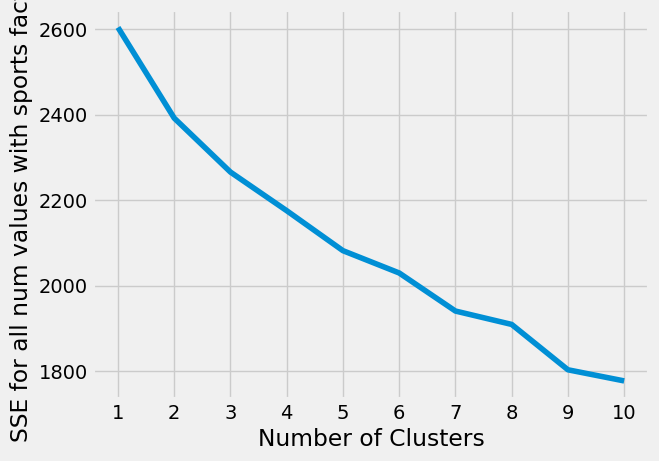

lol


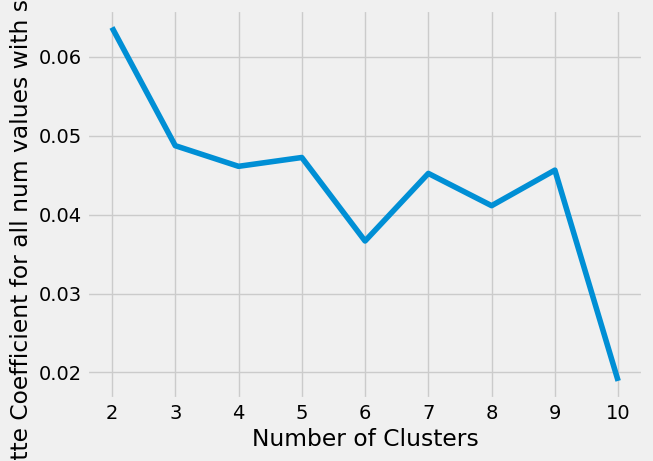

([2604.0,
  2391.9264867010706,
  2265.732357765694,
  2175.4205593056836,
  2081.9032827679366,
  2029.7288102713546,
  1940.7057607316467,
  1909.3905231298177,
  1803.2991880797601,
  1777.2700835544626],
 [0.06369032391649397,
  0.0487198189775004,
  0.04610562148650183,
  0.04722346478658734,
  0.03664926747965617,
  0.045206924583706044,
  0.04112154413276753,
  0.04562075532548891,
  0.018931037998035378])

In [170]:
label_all_wsf = "for all num values with sports factor"

elbow_and_silhouette(data_num_wsf_scaled, label_all_wsf)
# die Methoden für alle Daten ohne die Sportarten suggesten, dass 2 oder 6 Cluster am meisten Sinn machen

In [171]:
from sklearn.manifold import TSNE

# Perform clustering
def dimension_reduction(data_scaled, clusters, tsne_perplexity):
    kmeans_test_all = KMeans(n_clusters=clusters, **kmeans_kwargs)
    cluster_labels = kmeans_test_all.fit_predict(data_scaled)

    # Evaluate clusters
    silhouette_avg = silhouette_score(data_scaled, cluster_labels)
    print(f"Silhouette Score: {silhouette_avg}")

    #PCA
    pca_test_all = PCA(n_components=2)
    pca_result_test_all = pca_test_all.fit_transform(data_scaled)

    #TSNE
    tsne_test_all = TSNE(n_components=2, perplexity=tsne_perplexity, n_iter=300, random_state=0)
    tsne_result_test_all = tsne_test_all.fit_transform(data_scaled)

    #plot both
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    sb.scatterplot(x=pca_result_test_all[:, 0], y=pca_result_test_all[:, 1], hue=cluster_labels, palette="Set1")
    plt.title('PCA Visualization')

    plt.subplot(1, 2, 2)
    sb.scatterplot(x=tsne_result_test_all[:, 0], y=tsne_result_test_all[:, 1], hue=cluster_labels, palette="Set1")
    plt.title('t-SNE Visualization')

    plt.tight_layout()
    plt.show()

Silhouette Score: 0.047986515772342635


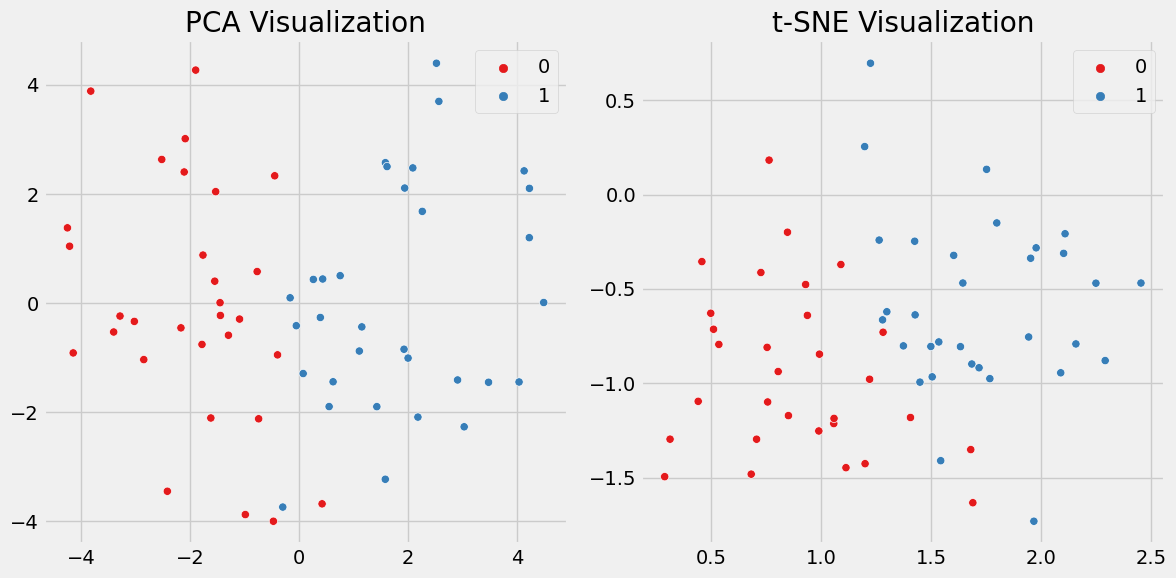

Silhouette Score: 0.03909195722012331


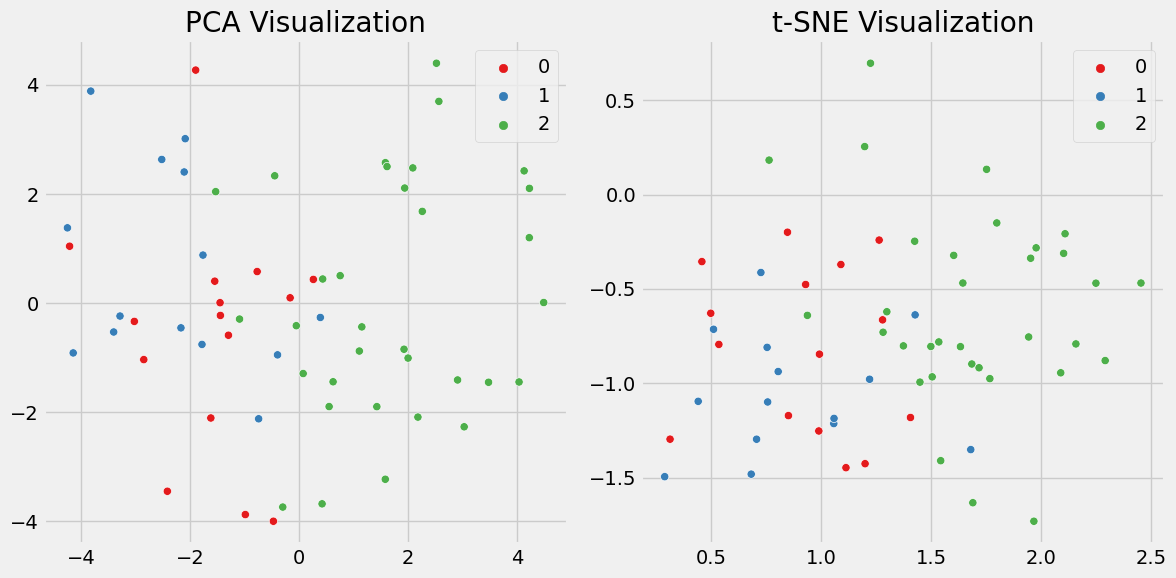

Silhouette Score: 0.04018235775914987


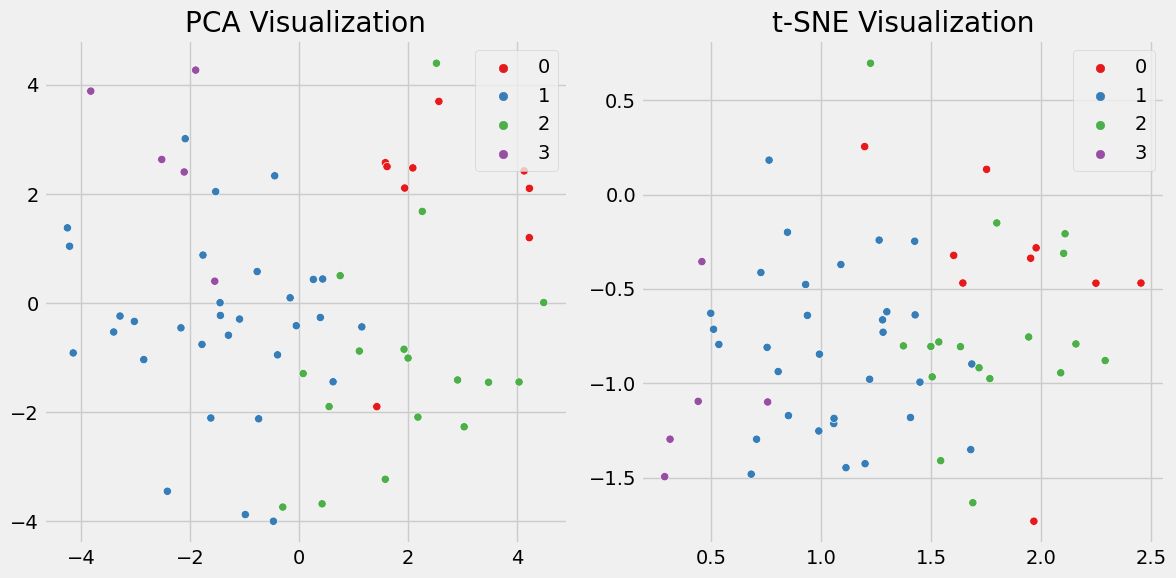

Silhouette Score: 0.041664625099869415


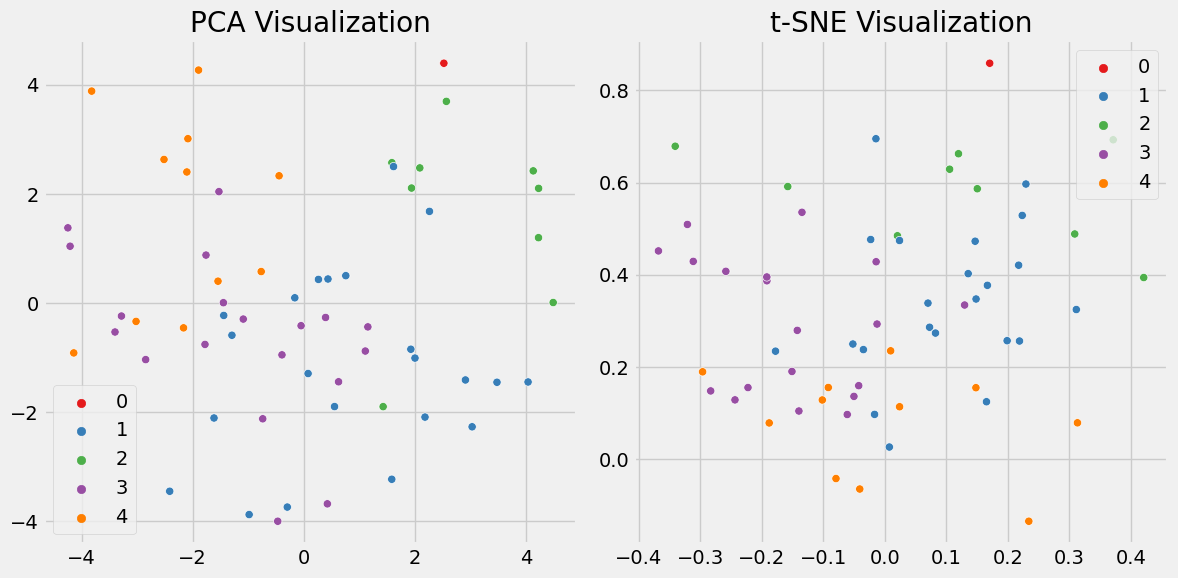

In [172]:
#2 oder 5 für alle skalierten daten
dimension_reduction(data_all_scaled, 2, 50)
dimension_reduction(data_all_scaled, 3, 50)
dimension_reduction(data_all_scaled, 4, 50)
dimension_reduction(data_all_scaled, 5, 60)

Silhouette Score: 0.07550802859646524


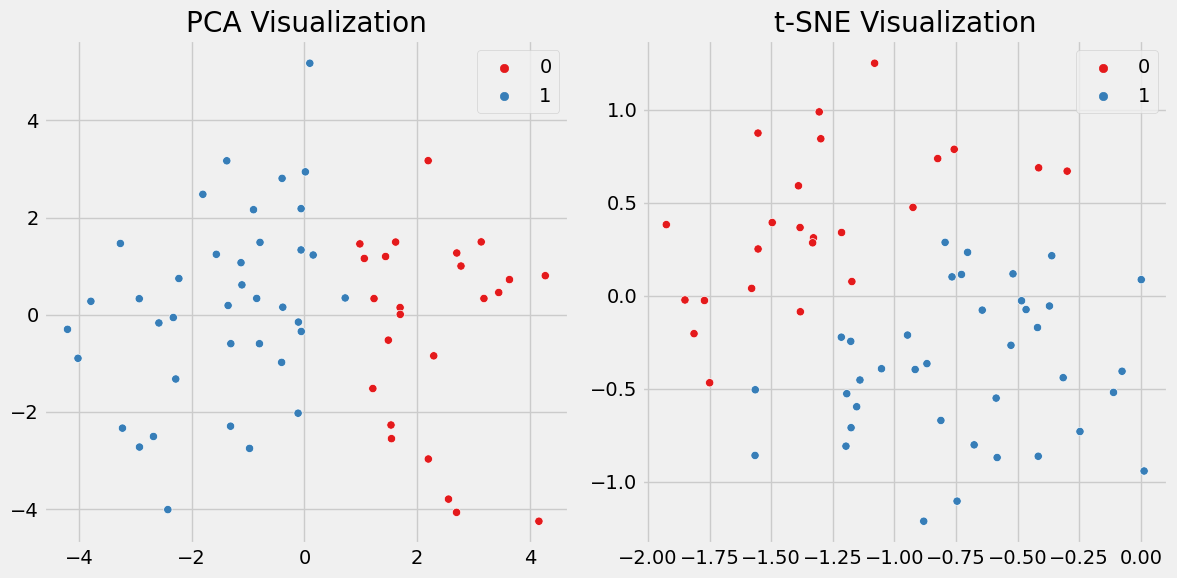

Silhouette Score: 0.04817739744714839


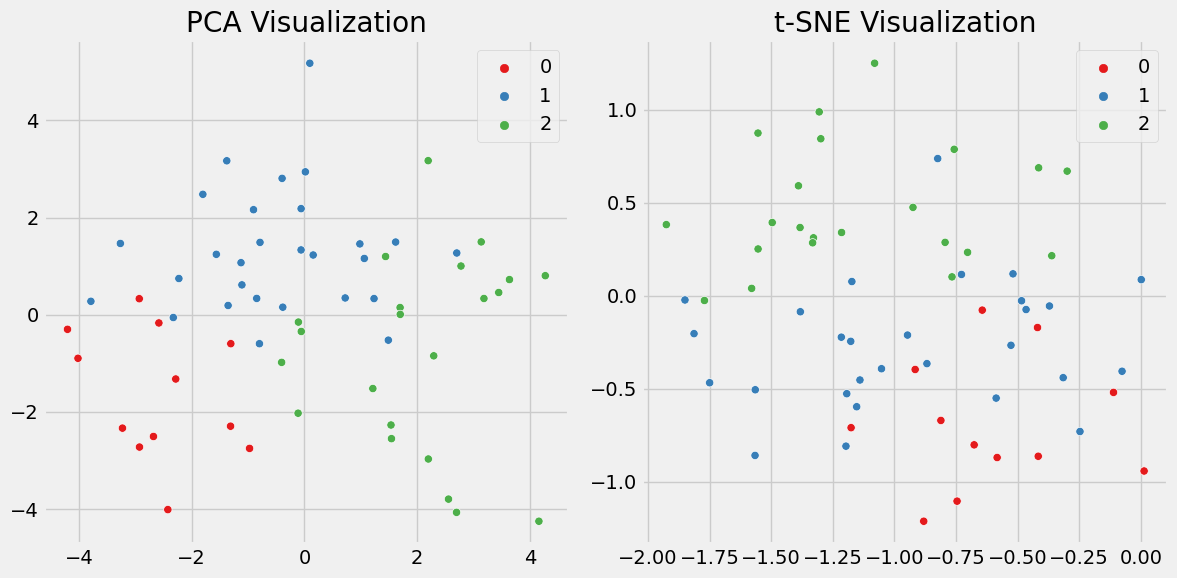

Silhouette Score: 0.052156708875401185


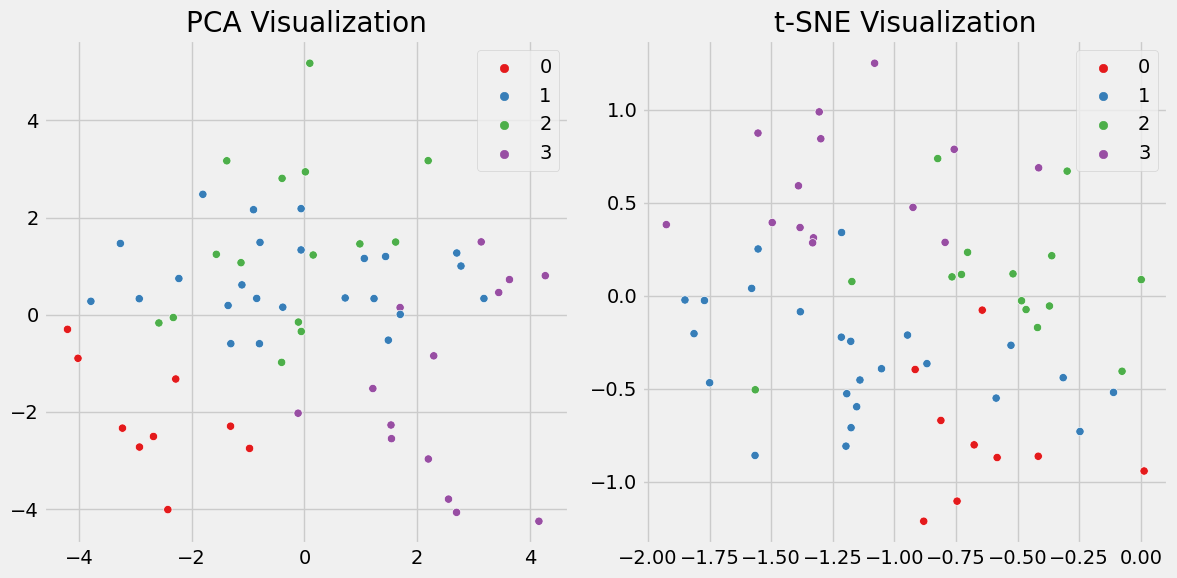

Silhouette Score: 0.04881310201178609


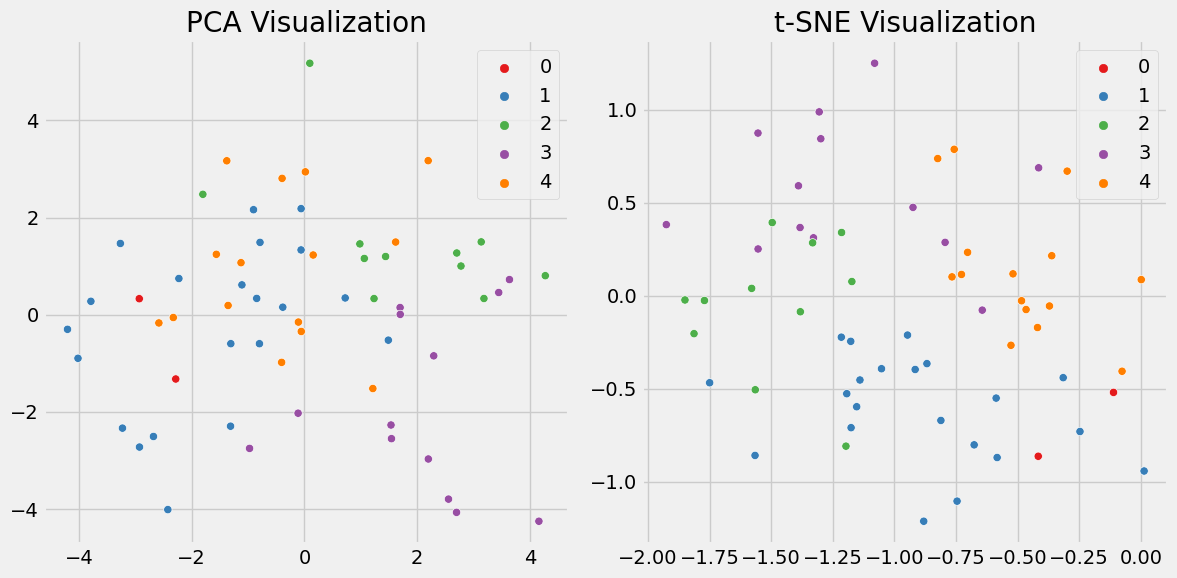

Silhouette Score: 0.04626883688240476


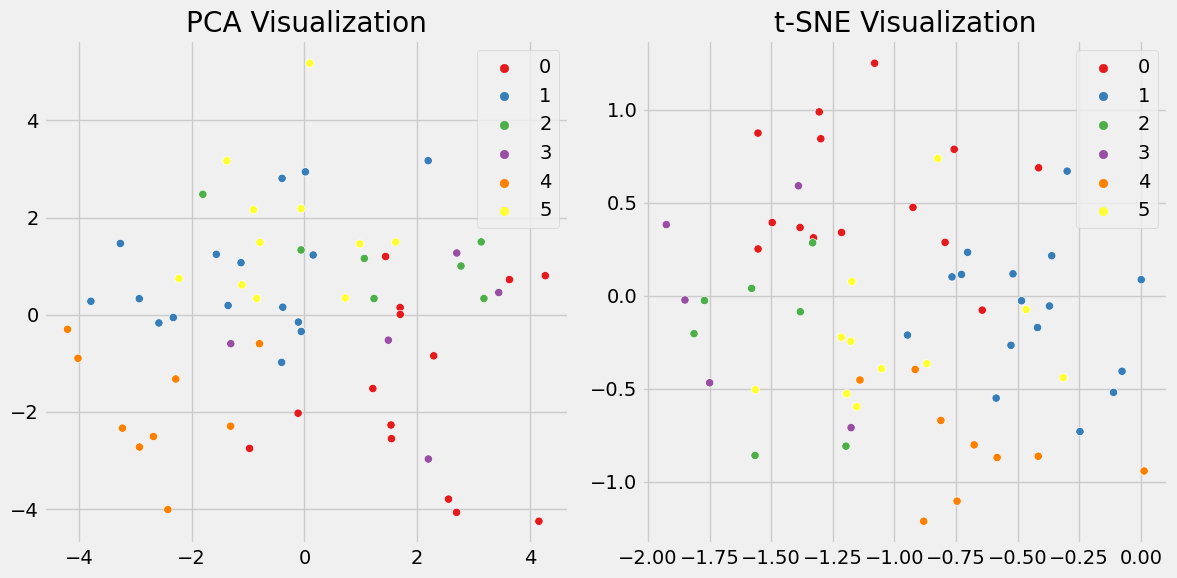

In [174]:
#2 oder 6 für alle skalierten daten ohne Sport
dimension_reduction(data_all_without_sports_scaled, 2, 50)
dimension_reduction(data_all_without_sports_scaled, 3, 50)
dimension_reduction(data_all_without_sports_scaled, 4, 50)
dimension_reduction(data_all_without_sports_scaled, 5, 50)
dimension_reduction(data_all_without_sports_scaled, 6, 50)

Silhouette Score: 0.0621704193637399


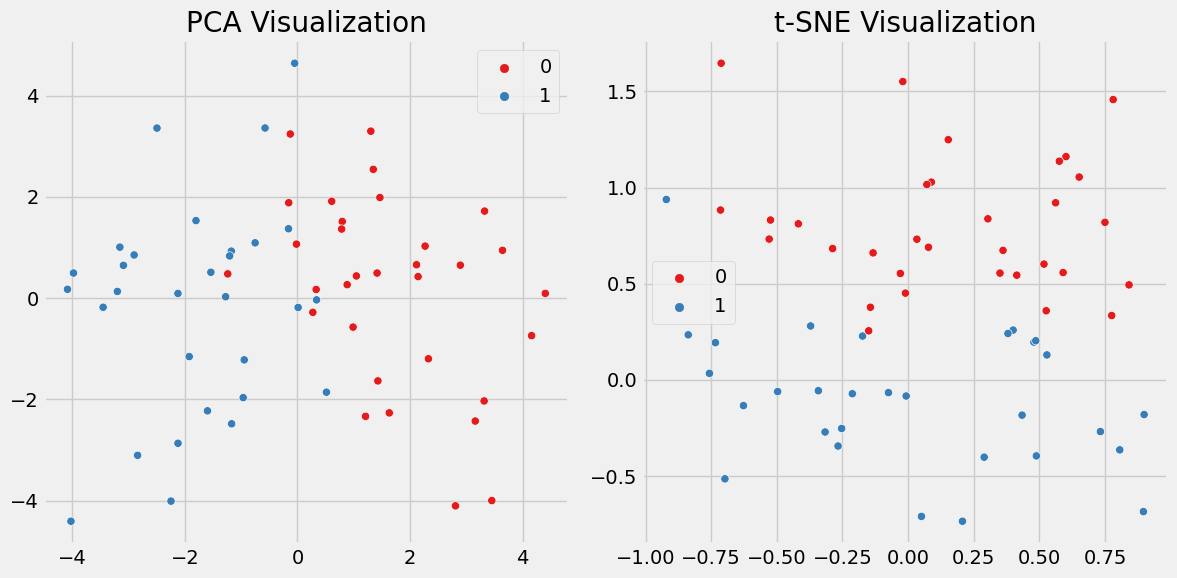

Silhouette Score: 0.049052396227861145


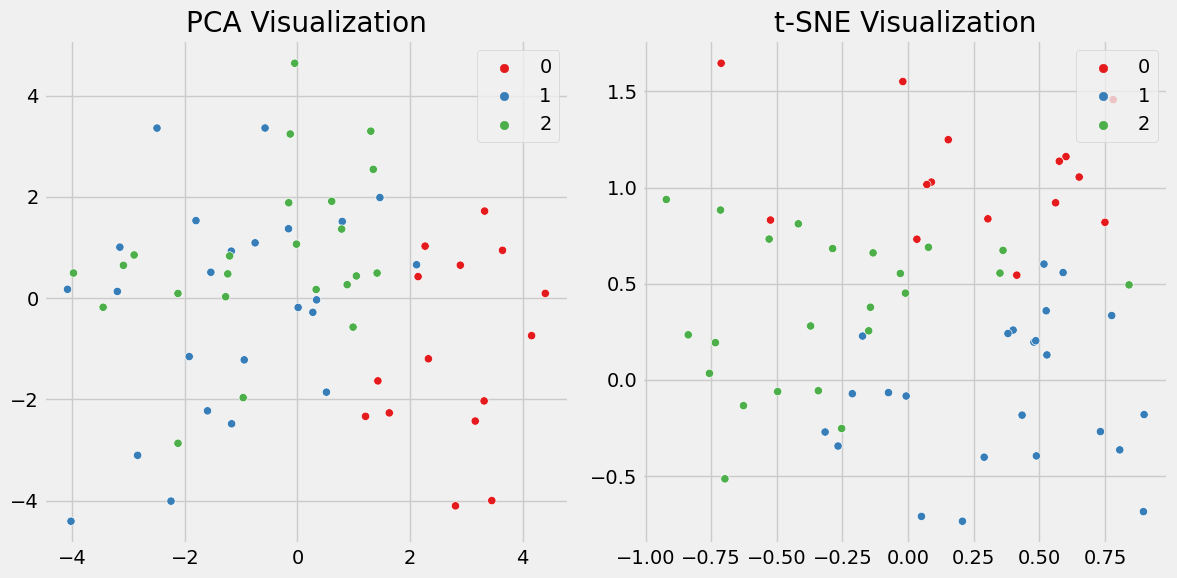

Silhouette Score: 0.04216137590638206


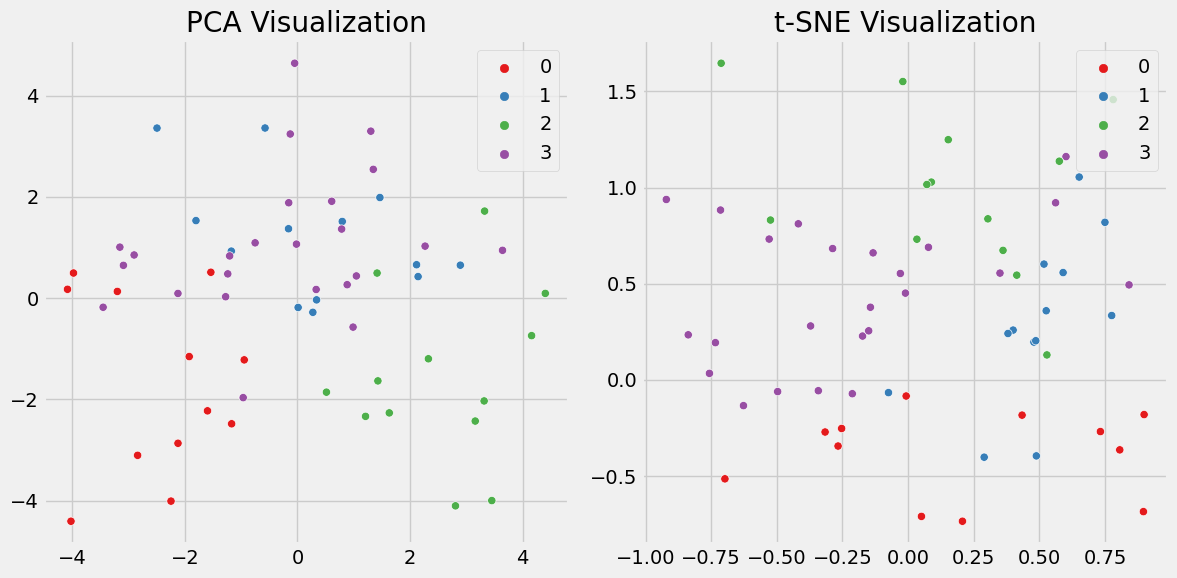

Silhouette Score: 0.05209360796934507


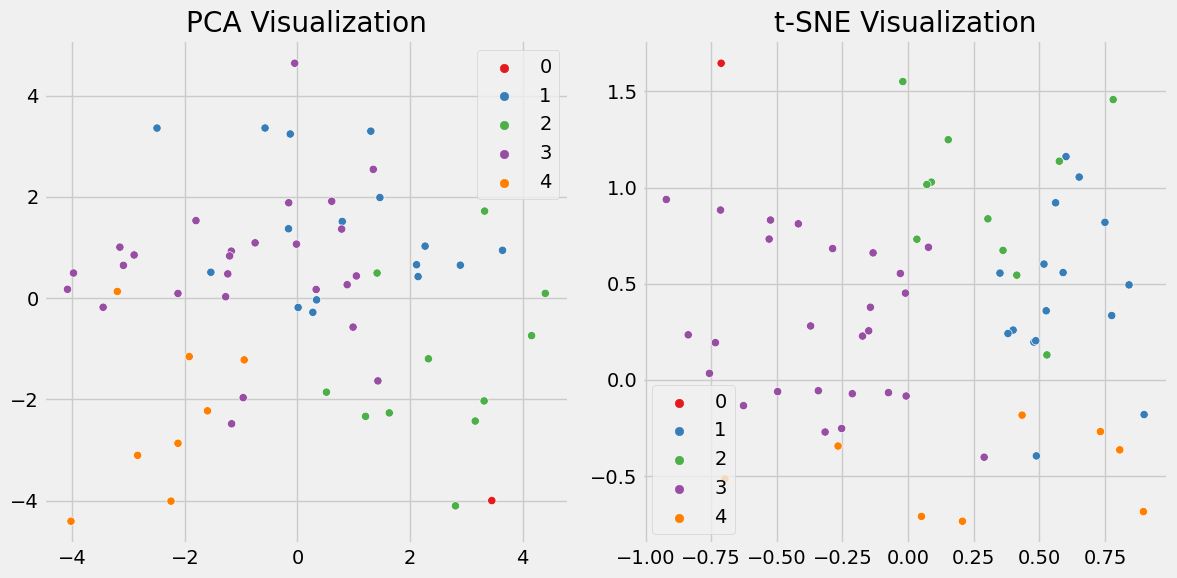

Silhouette Score: 0.04033339698741952


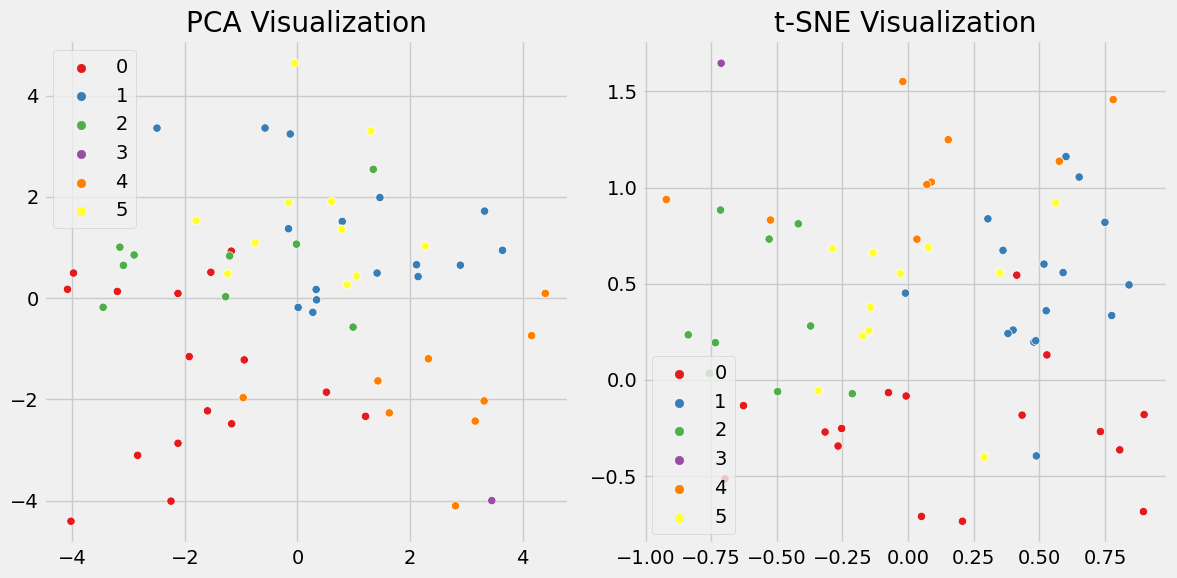

In [145]:
#2 oder 5 für die skalierten daten mit sports factor
dimension_reduction(data_num_wsf_scaled, 2, 50)
dimension_reduction(data_num_wsf_scaled, 3, 50)
dimension_reduction(data_num_wsf_scaled, 4, 50)
dimension_reduction(data_num_wsf_scaled, 5, 50)
dimension_reduction(data_num_wsf_scaled, 6, 50)

In [226]:
data_num_wsf_scaled.columns


Index(['Alter', 'Sportlichkeit', 'Gesunde_Ernaehrung', 'Essen_gehen', 'Kochen',
       'Feiern', 'Musik', 'Lesen', 'Darstellende_Kunst', 'Filme',
       'Bildende_Kunst', 'Museen', 'Videospiele', 'Soziale_Medien',
       'Technologie', 'Astronomie', 'Naturwissenschaften',
       'Soziales_Engagement', 'Soziale_Gerechtigkeit',
       'Introvertiert_Extrovertiert', 'FOMO', 'Spontan', 'Verwirrt',
       'Glücklich', 'Geduldig', 'Streitlustig', 'Abenteuerlustig',
       'Studium_Zweifel', 'Studium_Zufriedenheit', 'Akademische_Laufbahn',
       'Lerngruppe', 'Prokrastination', 'Abgaben_spaet',
       'Neugier_Lebensmittel', 'Natur', 'Verreisen', 'Handwerk',
       'Sprachnachrichten', 'Wichtigkeit_Geld', 'Geschlecht_num',
       'Studiengang_num', 'sports_factor'],
      dtype='object')

In [177]:
#label_wsf_wop = "for num values with sports factor, without position"
#elbow_and_silhouette(data_num_wsf_wop_scaled, label_wsf_wop)

In [178]:
#2 oder 5 für die skalierten daten mit sports factor
#dimension_reduction(data_num_wsf_wop_scaled, 2, 50)
#dimension_reduction(data_num_wsf_wop_scaled, 3, 50)
#dimension_reduction(data_num_wsf_wop_scaled, 4, 50)
#dimension_reduction(data_num_wsf_wop_scaled, 5, 50)
#dimension_reduction(data_num_wsf_wop_scaled, 6, 50)

In [186]:
def draw_stripplot(data, x, y, hue):
    ax = sb.stripplot(data = data,
                        x=x,
                        y=y,
                        hue=hue,
                        palette="Set1")
    plt.legend()
    plt.show()

In [188]:
def draw_catplot(data, x, y, cluster):
    ax = sb.catplot(data = data,
                    x=x,
                    y=y,
                    hue=cluster,
                    palette="Set1", 
                    col=cluster)
    plt.legend()
    plt.show()

In [149]:
def check_clustering(category_list, 
                     clusters=3, 
                     show_stripplot=False, 
                     show_catplot=False, 
                     show_cluster_bars=False, 
                     show_pairplot=False,
                    pairplot_vars=[]):
    for data_category in category_list:
        #Index von columns der Kategorie
        category_columns_temp = data_category.columns
        
        scaler_temp = StandardScaler()
        scaler_temp.fit(data_category)
        #skalierte Daten
        data_temp_scaled = pd.DataFrame(scaler_temp.transform(data_category),
                                   columns= data_category.columns )
        

        #anwenden, cluster als Vorgabe
        kmeans_temp = KMeans(n_clusters=clusters, **kmeans_kwargs).fit(data_temp_scaled) 
        #Cluster-Label
        kmeans_temp.labels_

        # in die tabelle übernehmen
        data_temp_clustered = data_category.copy()
        data_temp_clustered["cluster_"+str(clusters)+"_temp"] = kmeans_temp.labels_
        #print(data_temp_clustered.head())

        if(show_stripplot):
            for index in range(0, (len(category_columns_temp))):
                for index_j in range(0, (len(category_columns_temp))):
                    ax = sb.stripplot(data = data_temp_clustered,
                                        x=category_columns_temp[index_j],
                                        y=category_columns_temp[index],
                                        hue="cluster_"+str(clusters)+"_temp",
                                        palette="Set1")
                    #ax.set_title(category_columns_temp[index_j] + " und " + category_columns_temp[index])
                    plt.legend()
                    plt.show()
        
        if(show_catplot):
            for index in range(0, (len(category_columns_temp))):
                for index_j in range(0, (len(category_columns_temp))):
                    ax = sb.catplot(data = data_temp_clustered,
                                    x=category_columns_temp[index_j],
                                    y=category_columns_temp[index],
                                    hue="cluster_"+str(clusters)+"_temp",
                                    palette="Set1", 
                               col="cluster_"+str(clusters)+"_temp")
                    #ax.set_title(category_columns_temp[index_j] + " und " + category_columns_temp[index])
                    plt.legend()
                    plt.show()

        if(show_cluster_bars):
            for index in range(0, (len(category_columns_temp))):
                sb.barplot(x="cluster_"+str(clusters)+"_temp",y=category_columns_temp[index], data=data_temp_clustered, palette="Set1")
                plt.title(category_columns_temp[index] + " / Cluster")
                plt.show()
        
        if(show_pairplot):
            sb.pairplot(data,
                        hue="cluster_"+str(clusters)+"_temp",
                        vars=pairplot_vars)


In [182]:
def scaling_and_clustering(data, clusters=3):
    scaler_temp = StandardScaler()
    scaler_temp.fit(data)
    data_temp_scaled = pd.DataFrame(scaler_temp.transform(data),
                               columns= data.columns )

    #anwenden, cluster als Vorgabe
    kmeans_temp = KMeans(n_clusters=clusters, **kmeans_kwargs).fit(data_temp_scaled) 
    kmeans_temp.labels_

    cluster_column_name = "cluster_"+str(clusters)+"_temp"
    # in die tabelle übernehmen
    data_temp_clustered = data.copy()
    data_temp_clustered[cluster_column_name] = kmeans_temp.labels_
    return data_temp_clustered, cluster_column_name


#Das hier ist nur interessant, wenn man ein label bereitstellt. In dem Fall ist das das cluster, 
# um zu sehen, was am meisten Einfluss auf das Clustering hatte. 
# Für unsupervised learning ist der hier nicht geeignet.
def feature_selection(data, label_column, threshold): 
    y = data[label_column]
    X = data.drop(label_column, axis=1)
    
    #Feature Selection
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, 
                                                        random_state=0)

    from sklearn.ensemble import RandomForestClassifier
    rfclf = RandomForestClassifier(max_depth=3, random_state=42)
    rfclf.fit(X_train, y_train)

    #####################################################################################
    # Visualizing feature importances, today's part
    #####################################################################################

    feature_imp = pd.Series(rfclf.feature_importances_, 
                            index=data.columns.drop(label_column)).sort_values(ascending=False)
    
    columns_to_drop = feature_imp[feature_imp < threshold].index

    plt.figure(figsize=(25, 20))
    print(sb.barplot(x=feature_imp, y=feature_imp.index))
    plt.xlabel('Feature Importance Score ' + label_column, fontsize=20)
    plt.ylabel('Features', fontsize=20)
    plt.title("Visualizing Important Features", fontsize=20, pad=20)
    
    return columns_to_drop

## 2 Cluster

In den Daten sind die Sportarten nicht einzeln dabei, sondern ein sports_factor.

Außerdem wurde Position_num rausgenommen

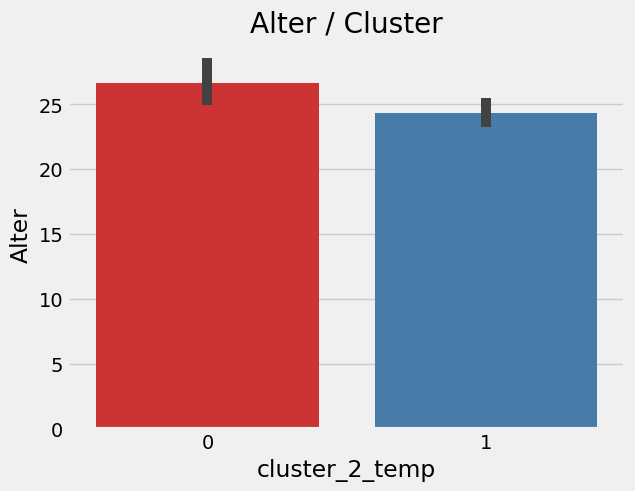

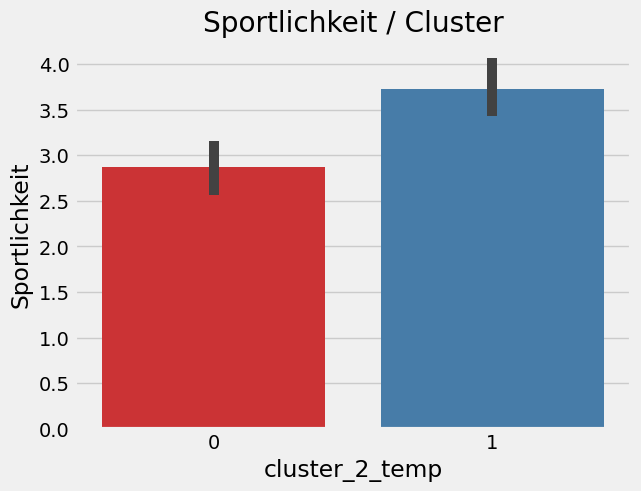

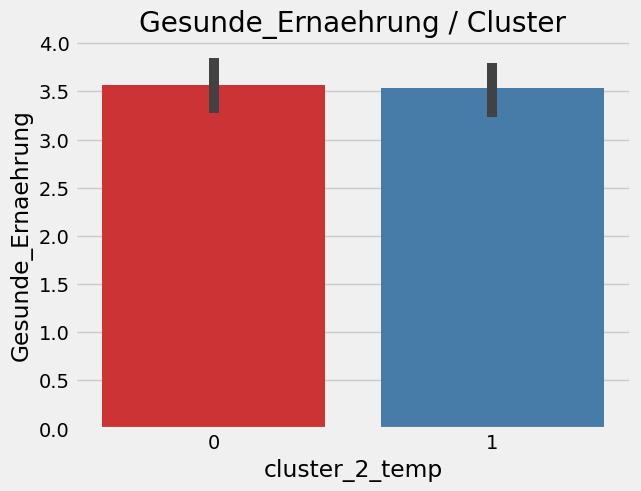

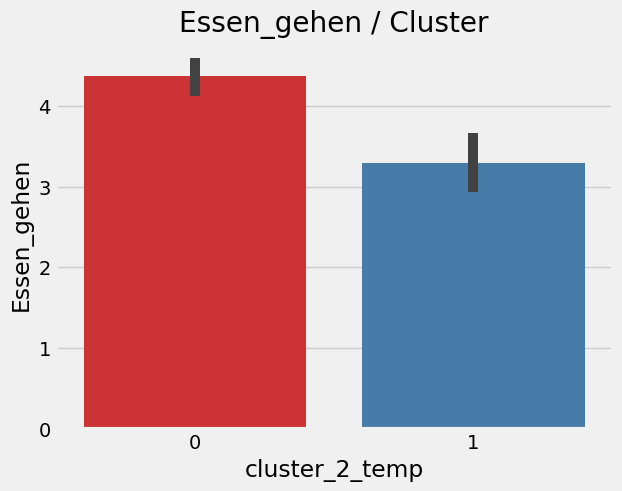

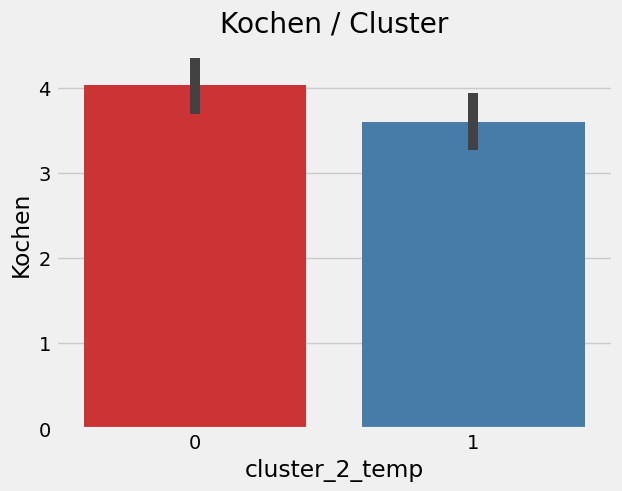

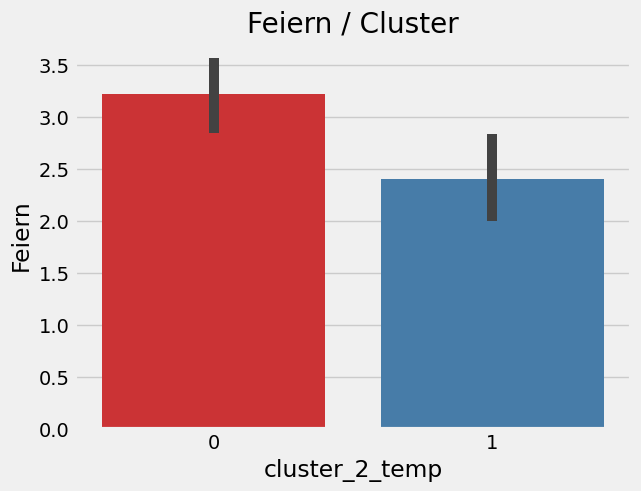

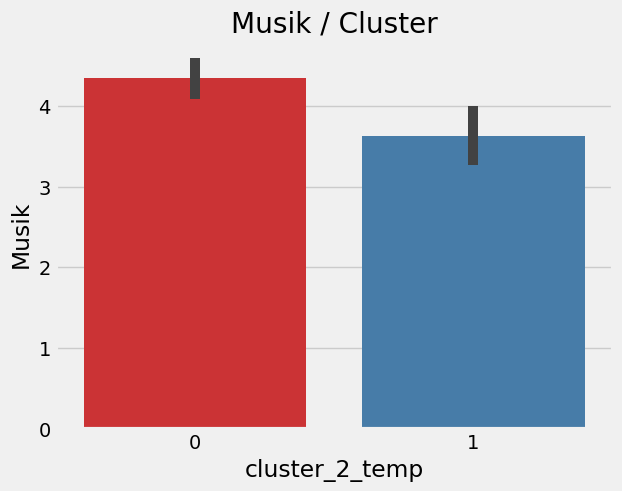

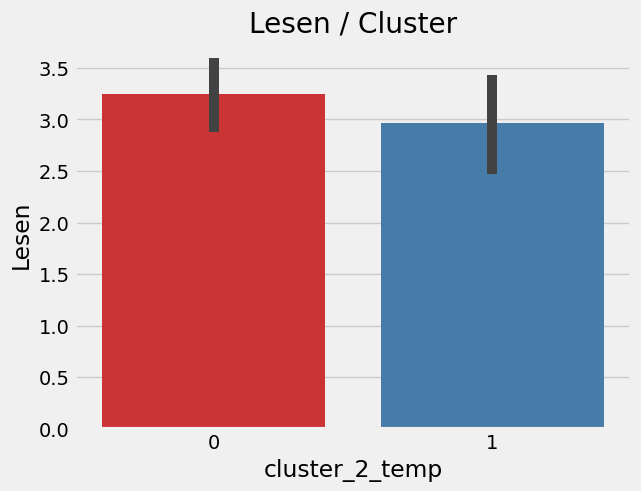

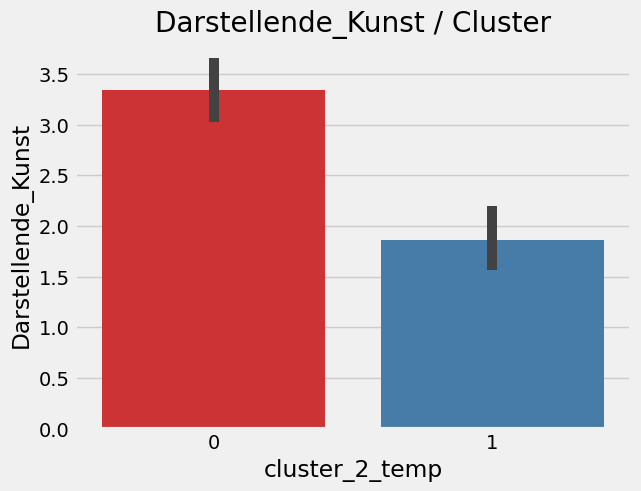

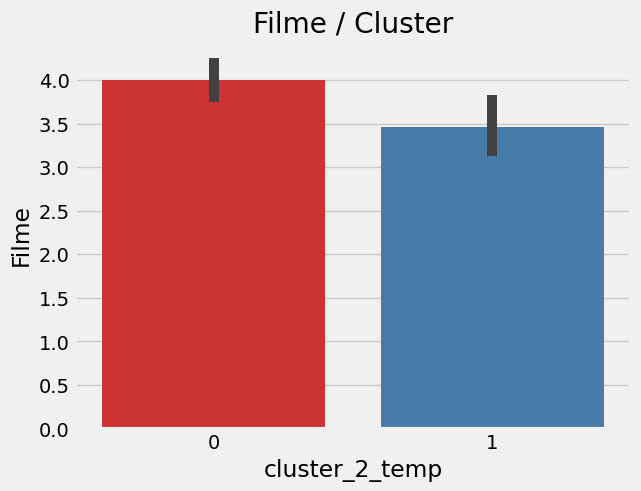

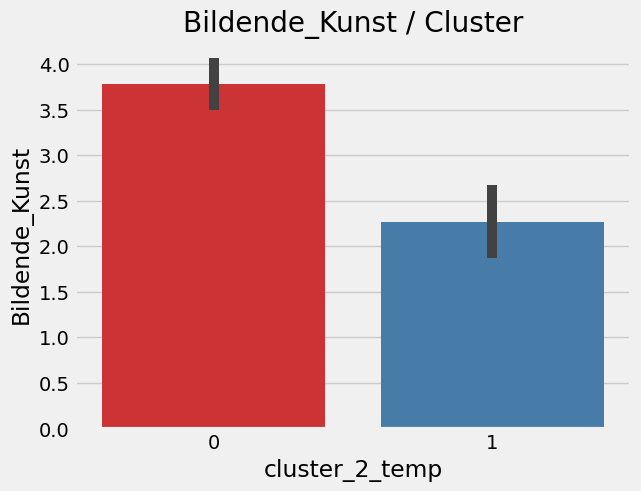

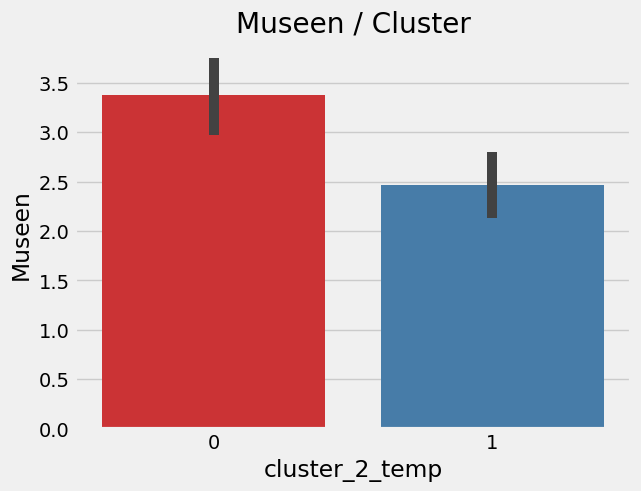

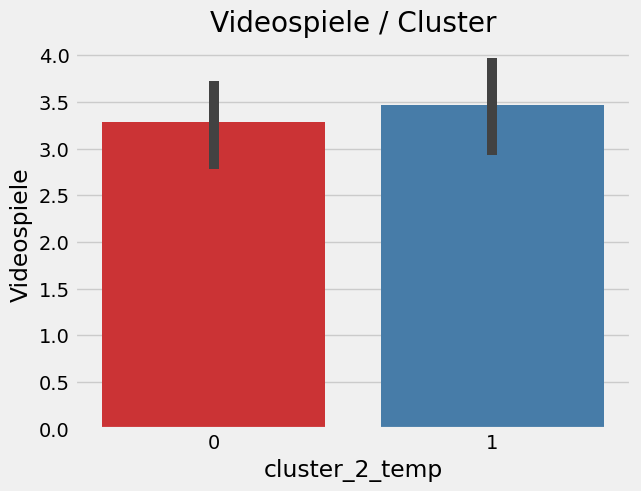

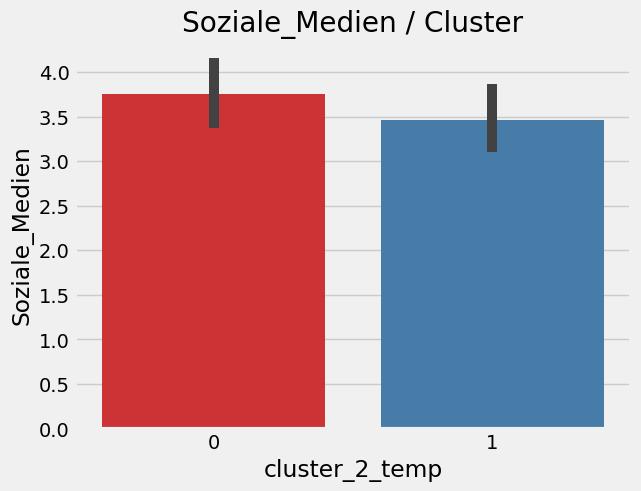

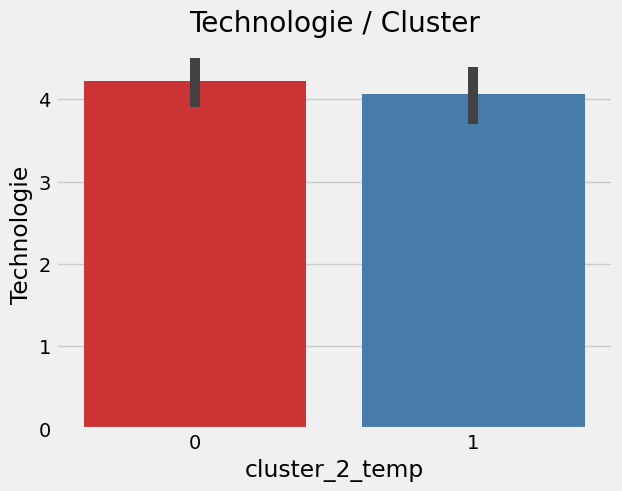

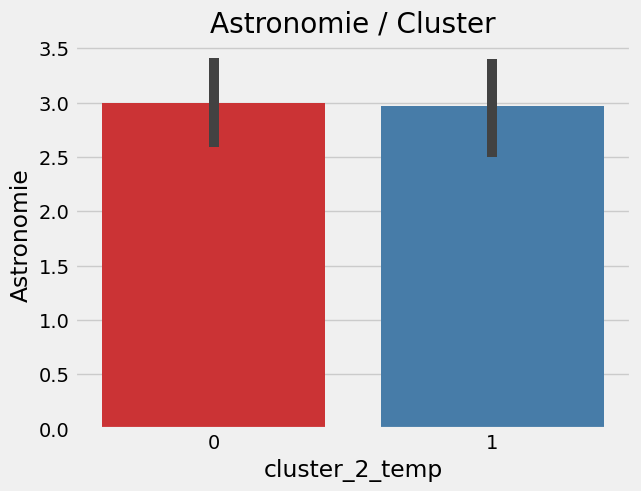

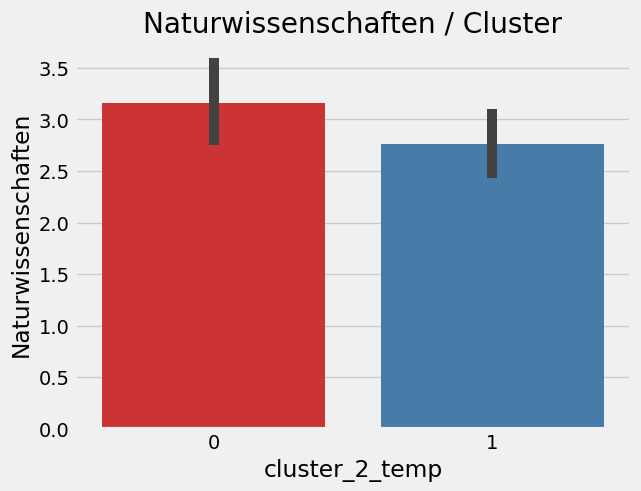

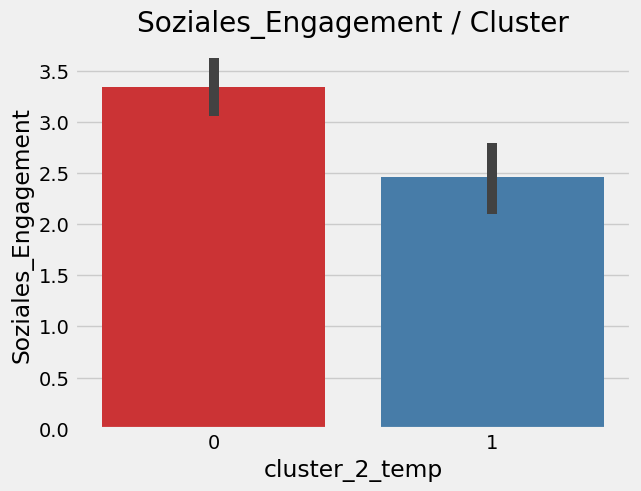

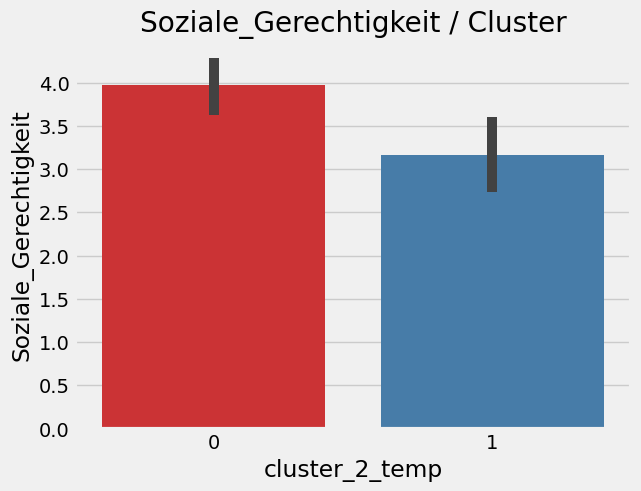

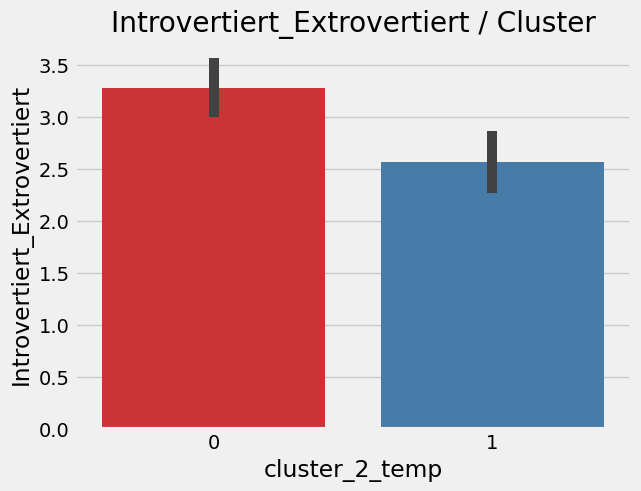

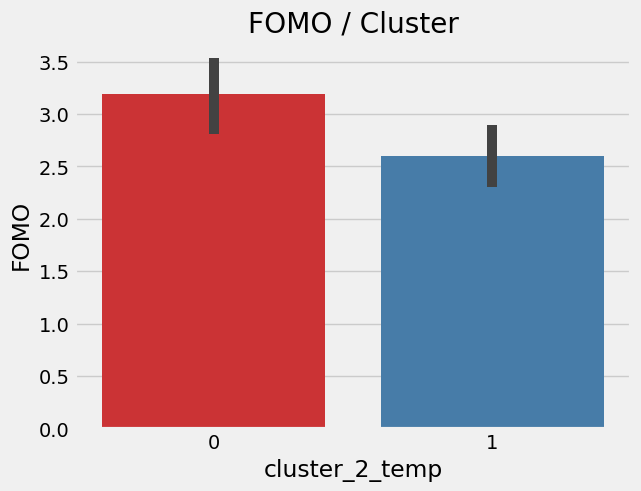

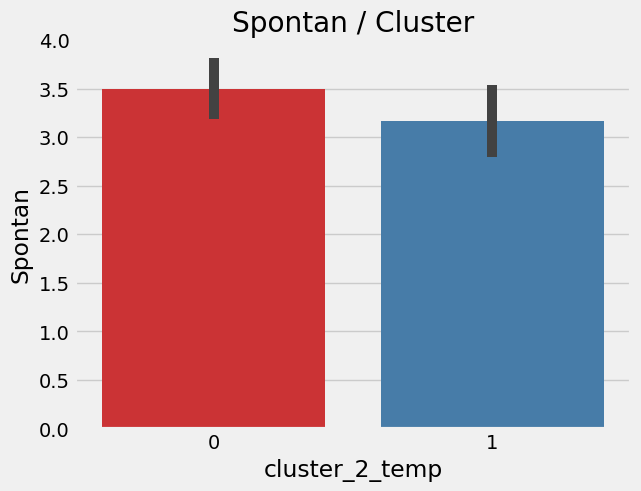

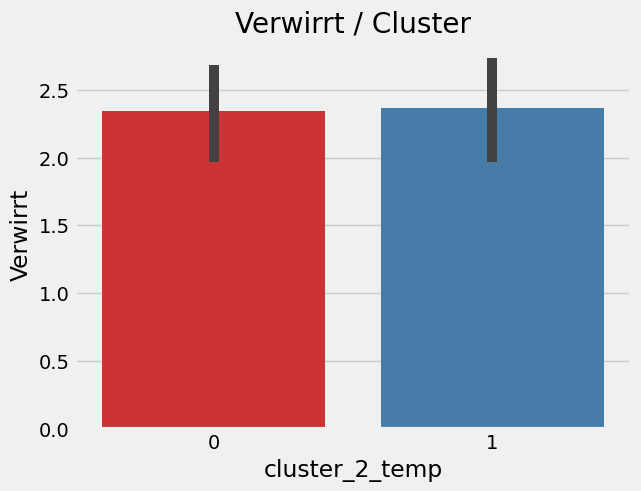

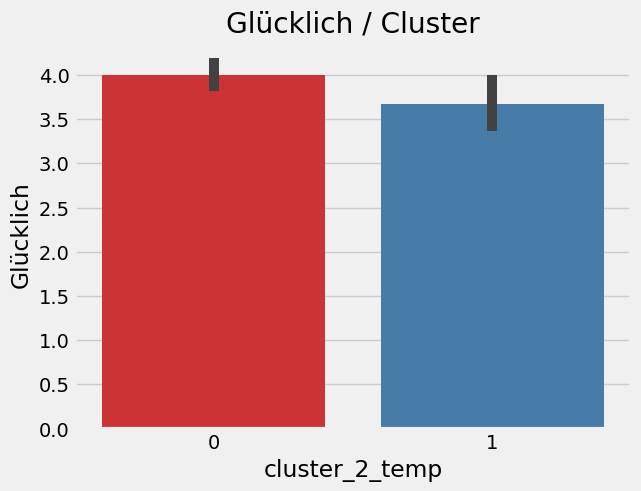

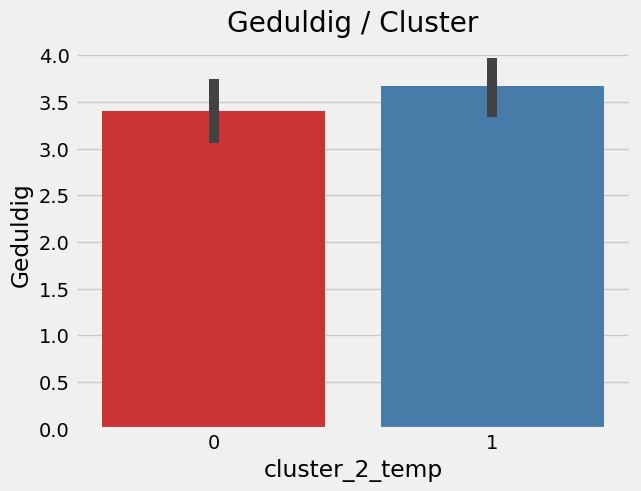

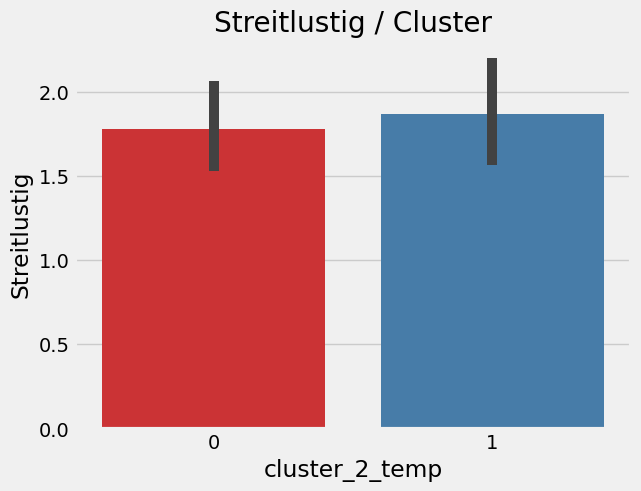

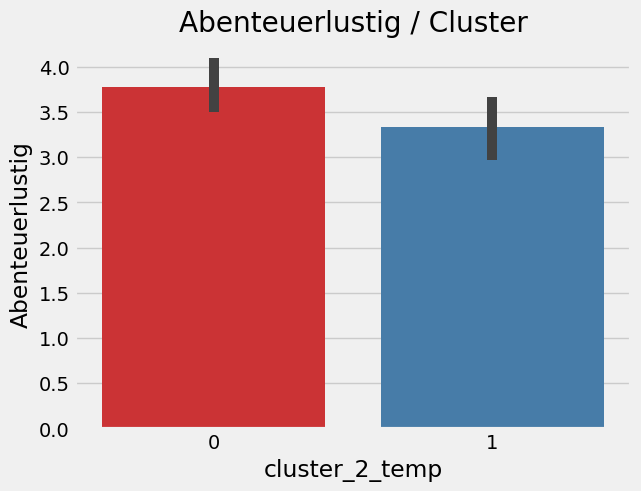

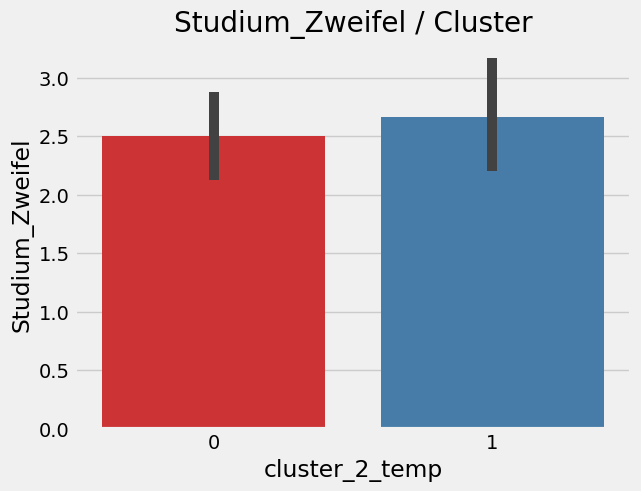

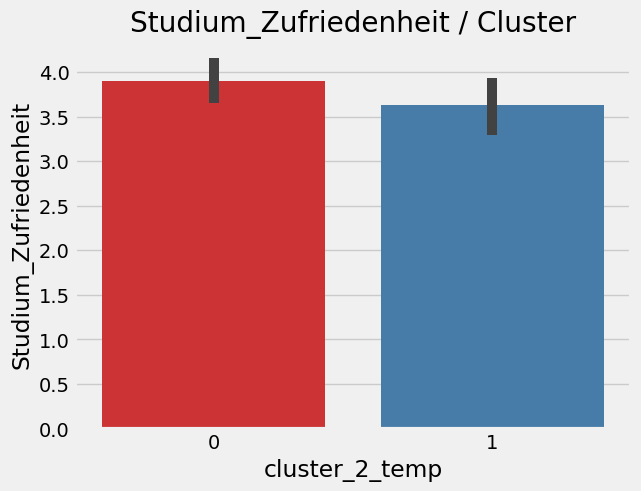

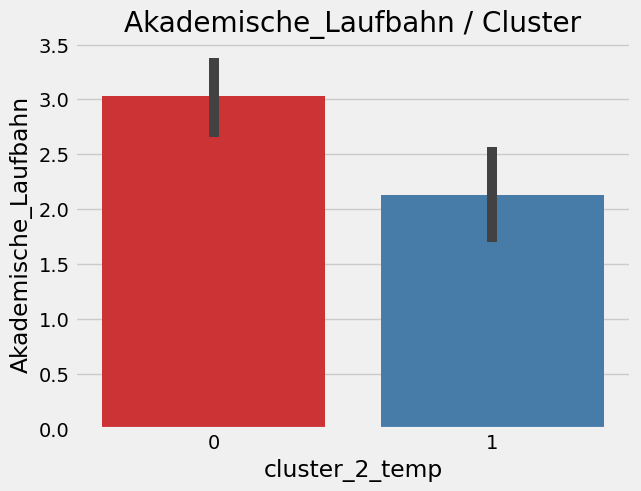

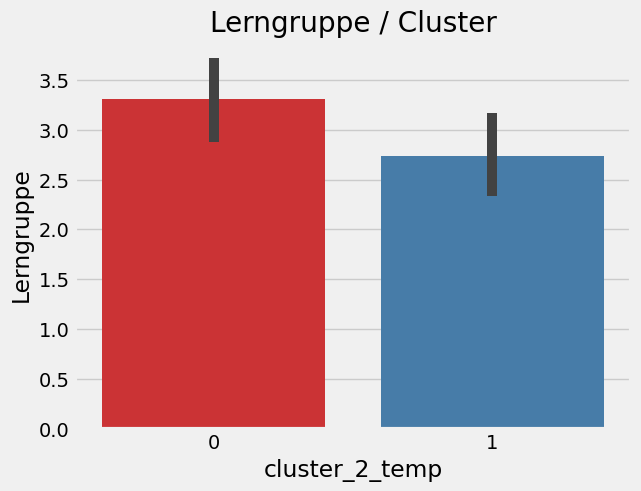

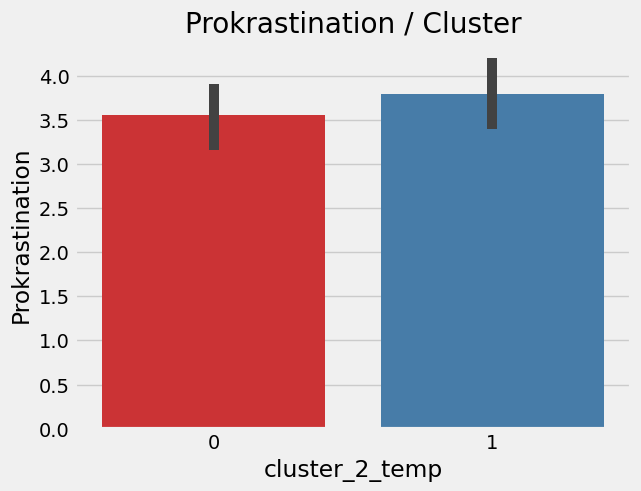

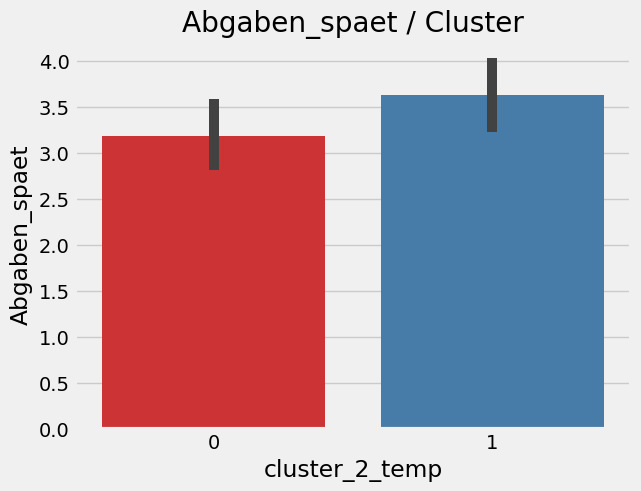

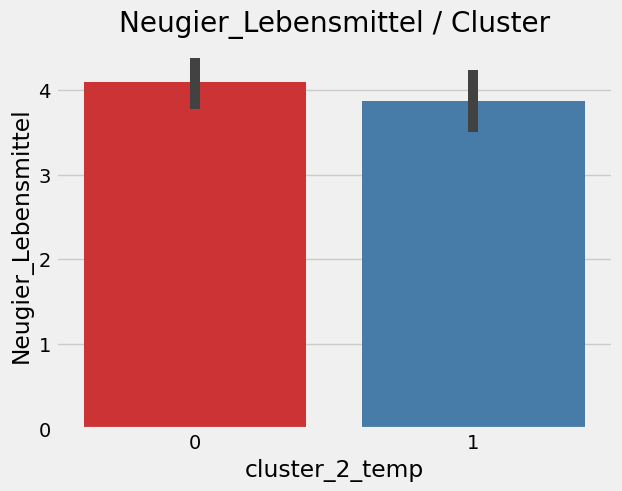

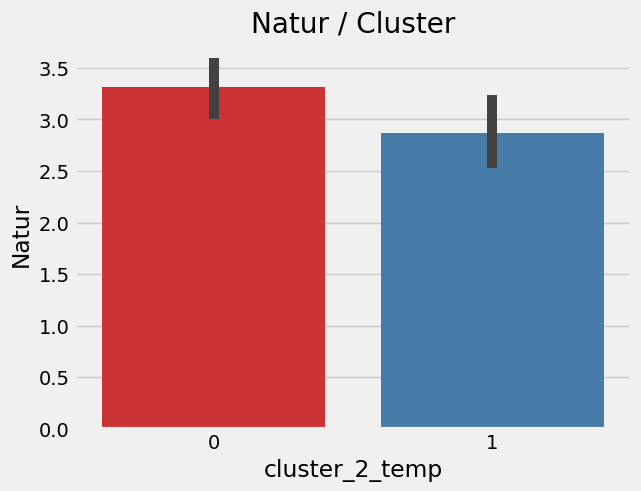

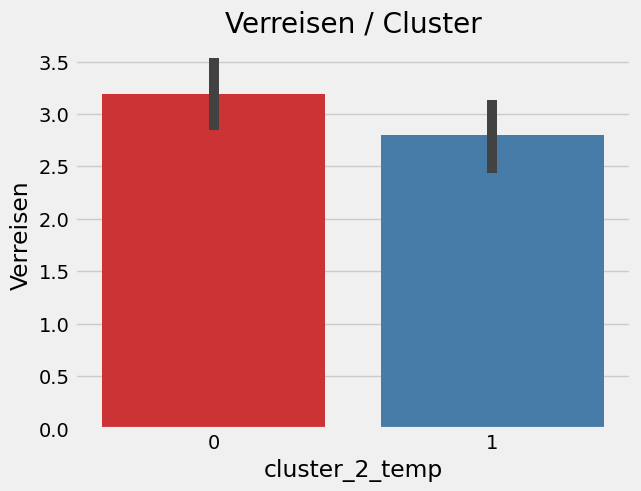

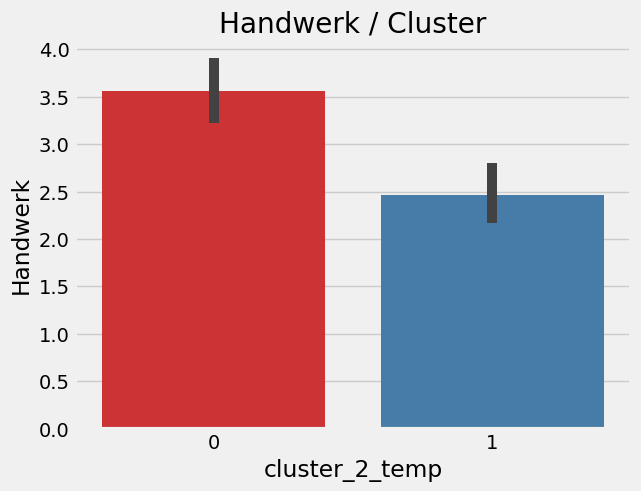

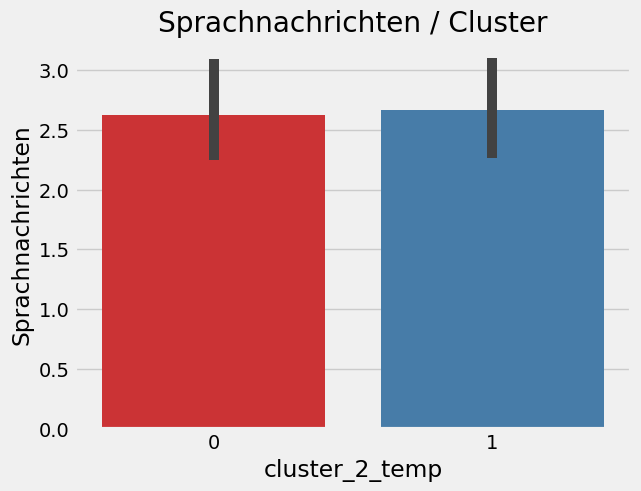

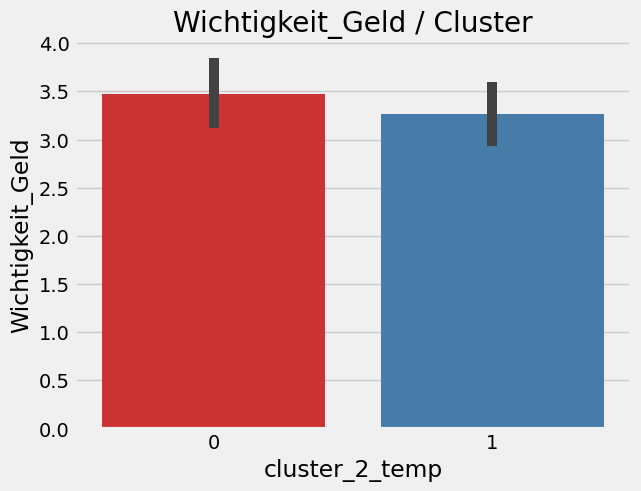

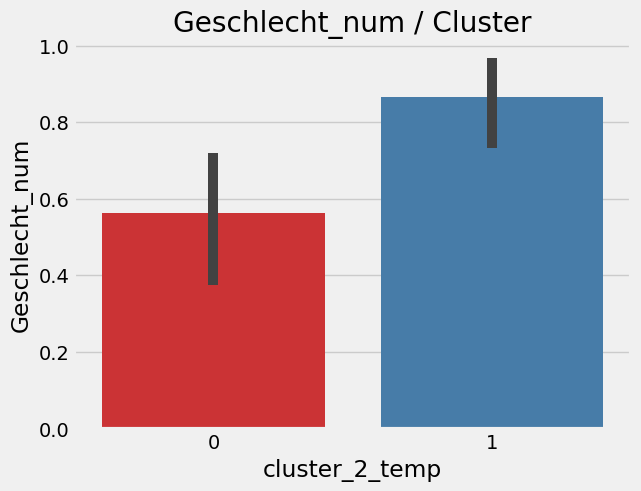

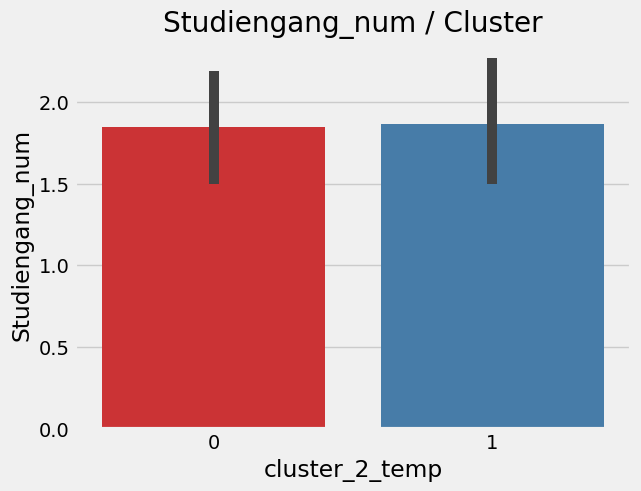

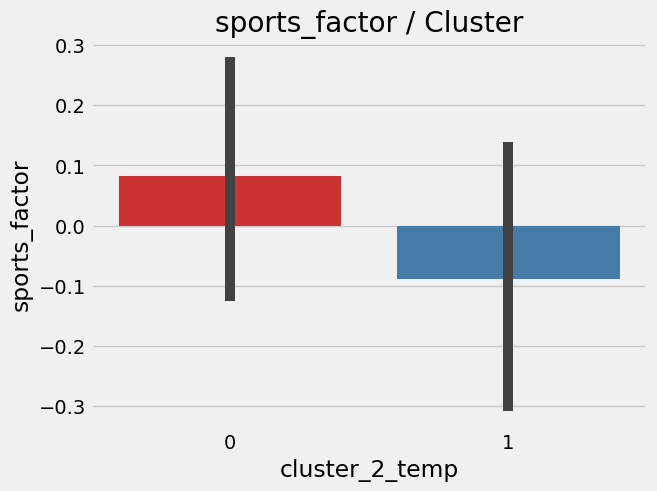

In [180]:
check_clustering(category_list=[data_num_wsf], clusters=2, show_cluster_bars=True)

Axes(0.08,0.07;0.87x0.81)


Index(['Musik', 'Soziale_Gerechtigkeit', 'sports_factor', 'Soziale_Medien',
       'Abgaben_spaet', 'Studium_Zufriedenheit', 'Technologie', 'Natur',
       'Studium_Zweifel', 'Wichtigkeit_Geld', 'Lerngruppe', 'Prokrastination',
       'FOMO', 'Astronomie', 'Alter', 'Naturwissenschaften', 'Spontan',
       'Neugier_Lebensmittel', 'Gesunde_Ernaehrung', 'Geduldig',
       'Sprachnachrichten', 'Videospiele', 'Verwirrt', 'Studiengang_num',
       'Streitlustig'],
      dtype='object')

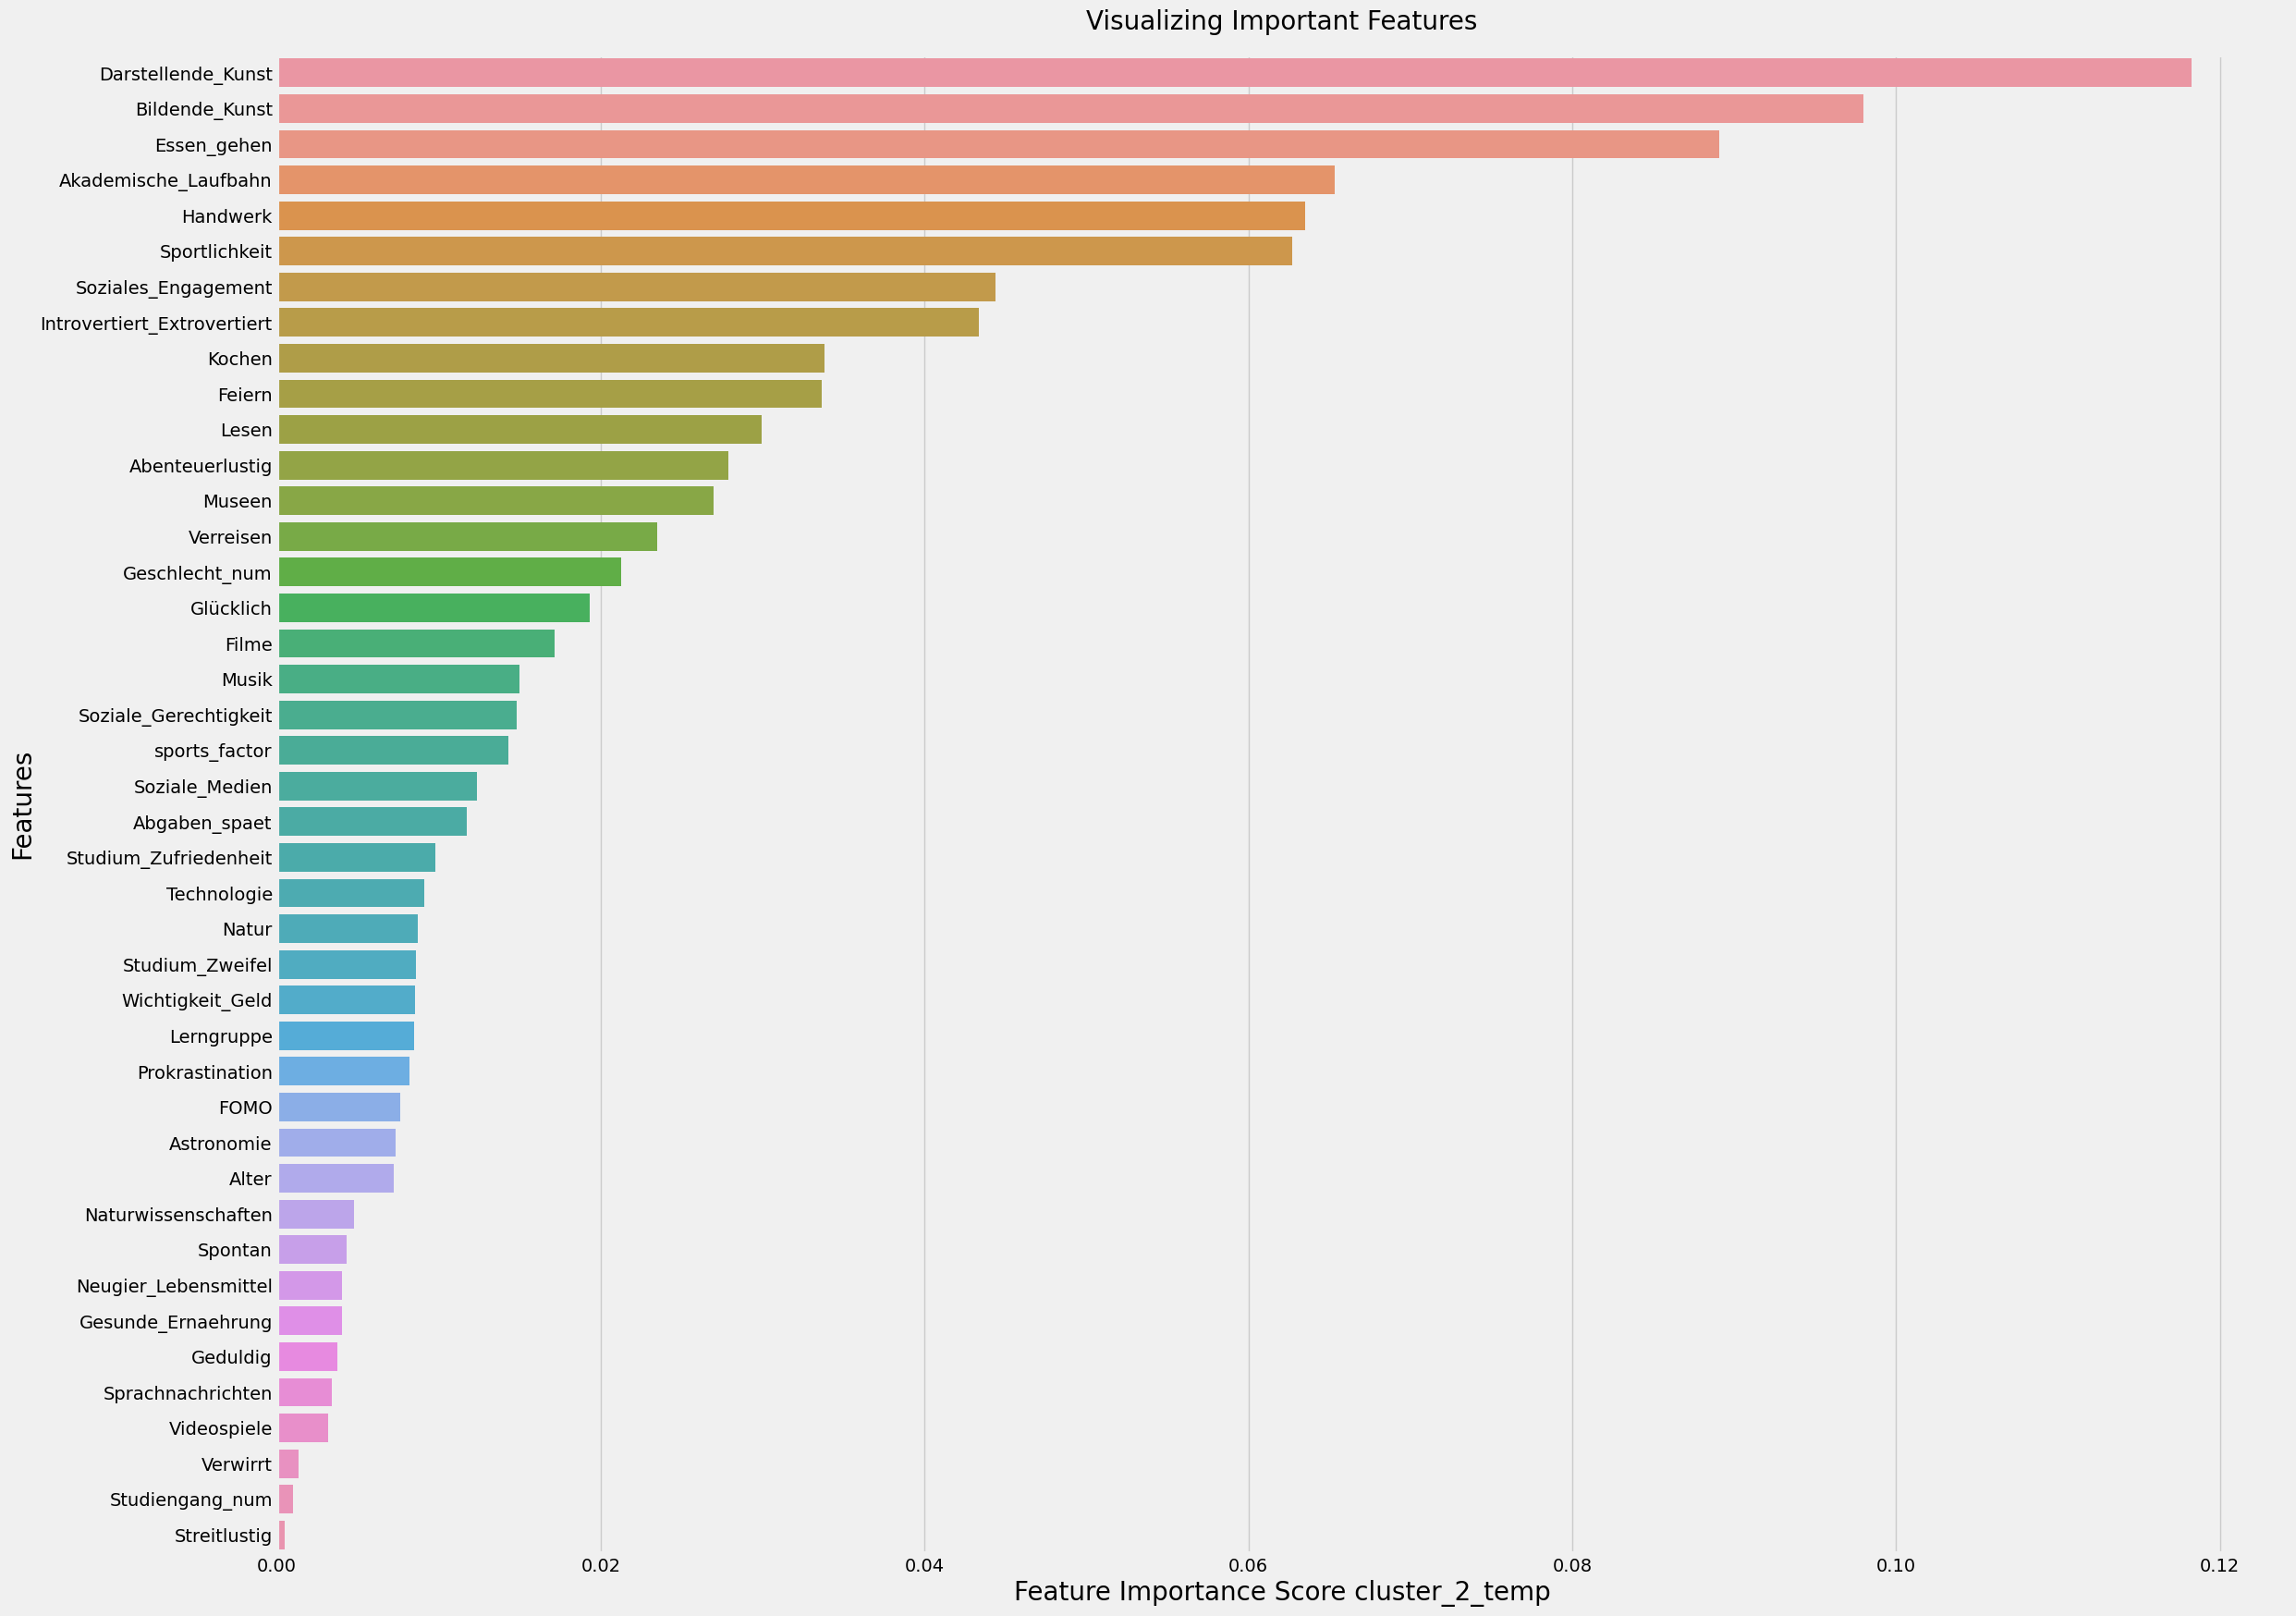

In [190]:
data_wsf_clustered_2, cluster_name_wsf_2 = scaling_and_clustering(data_num_wsf, clusters=2)
#print(data_wsf_clustered_2, cluster_name_wsf_2)
columns_to_drop_wsf_2= feature_selection(data=data_wsf_clustered_2, label_column=cluster_name_wsf_2, threshold=0.015)
columns_to_drop_wsf_2

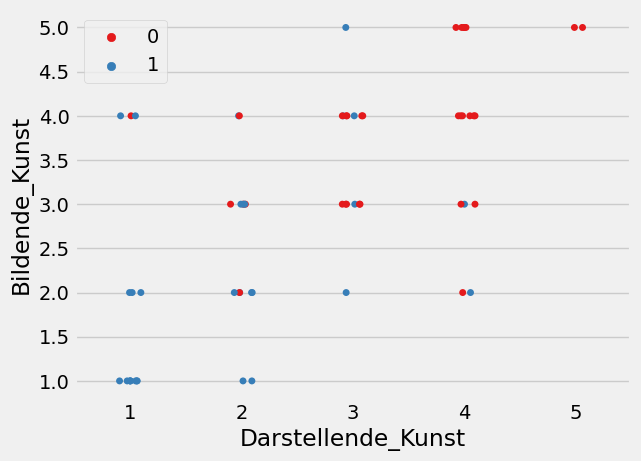

In [191]:
draw_stripplot(data_wsf_clustered_2, 'Darstellende_Kunst', 'Bildende_Kunst', cluster_name_wsf_2)

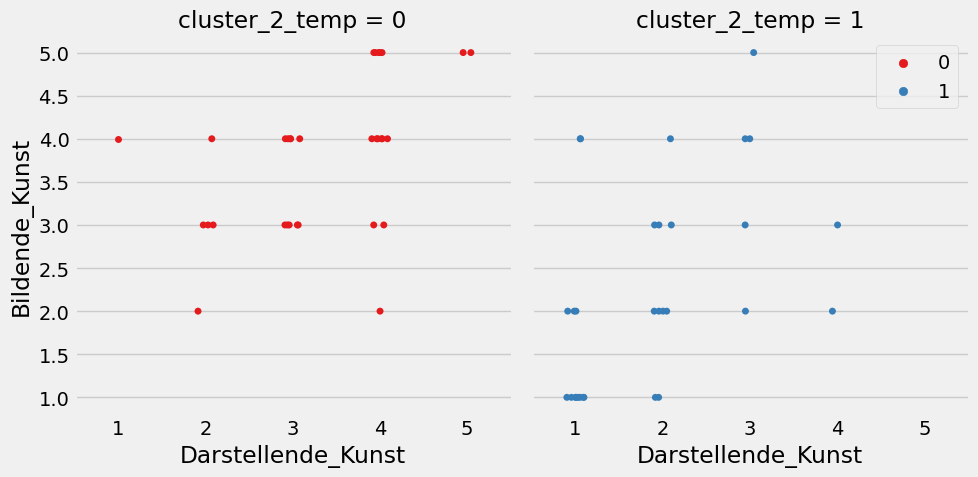

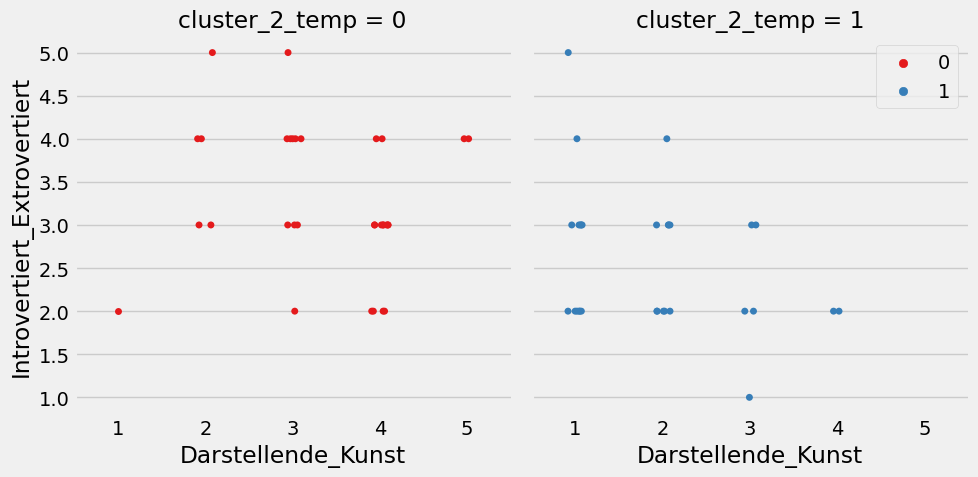

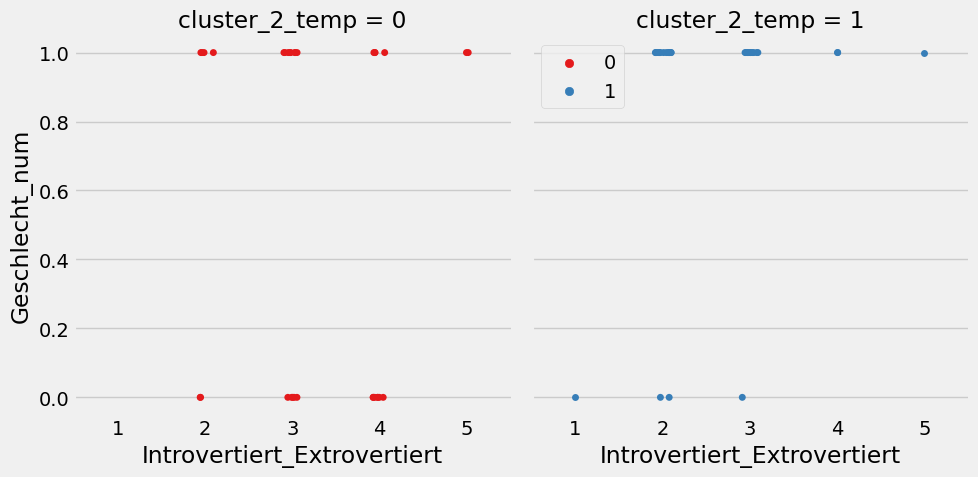

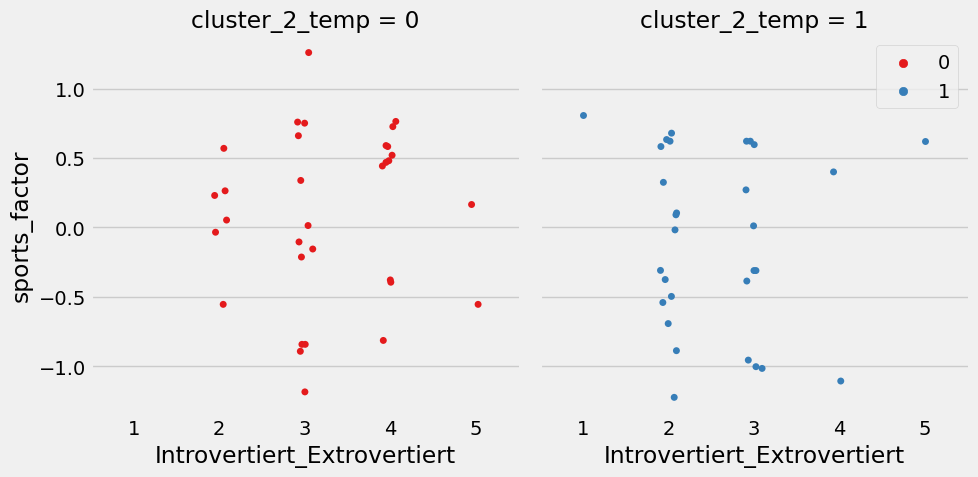

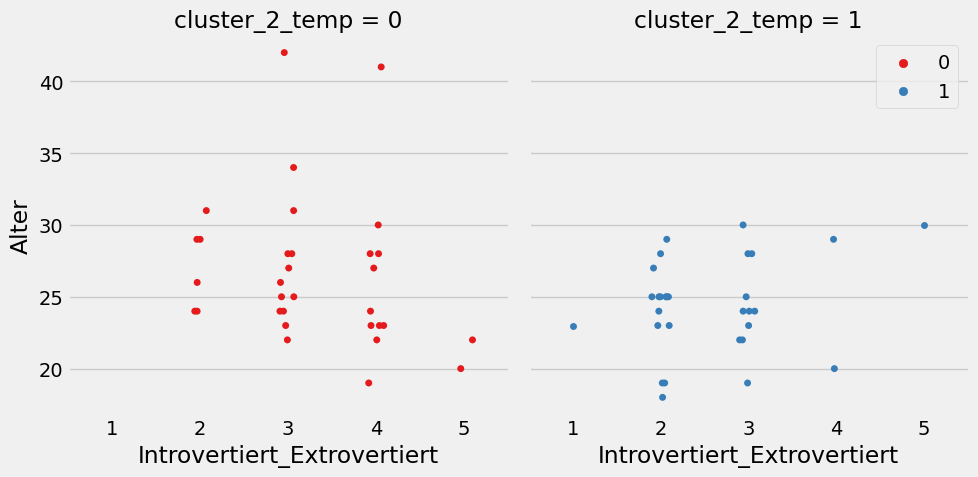

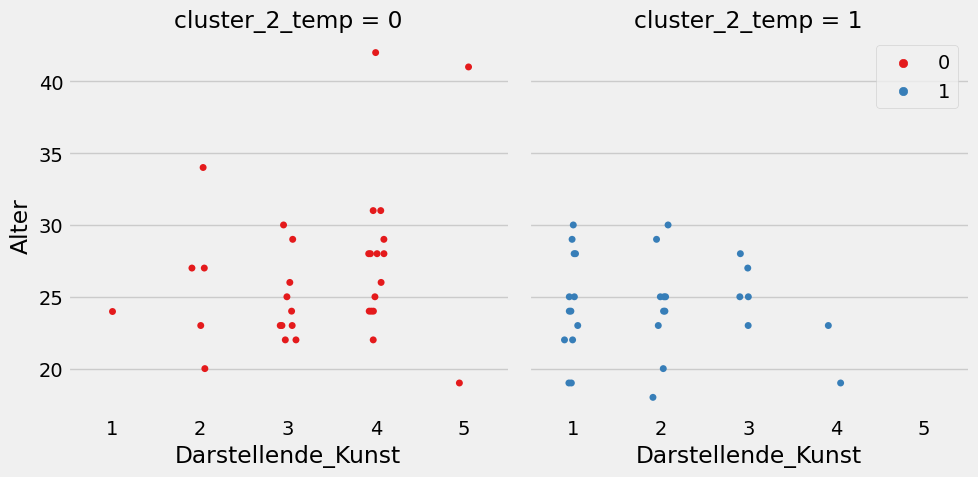

In [206]:
draw_catplot(data_wsf_clustered_2, 'Darstellende_Kunst', 'Bildende_Kunst', cluster_name_wsf_2)
draw_catplot(data_wsf_clustered_2, 'Darstellende_Kunst', 'Introvertiert_Extrovertiert', cluster_name_wsf_2)
draw_catplot(data_wsf_clustered_2, 'Introvertiert_Extrovertiert', 'Geschlecht_num', cluster_name_wsf_2)
draw_catplot(data_wsf_clustered_2, 'Introvertiert_Extrovertiert', 'sports_factor', cluster_name_wsf_2)
draw_catplot(data_wsf_clustered_2, 'Introvertiert_Extrovertiert', 'Alter', cluster_name_wsf_2)
draw_catplot(data_wsf_clustered_2, 'Darstellende_Kunst', 'Alter', cluster_name_wsf_2)

## 3 Cluster

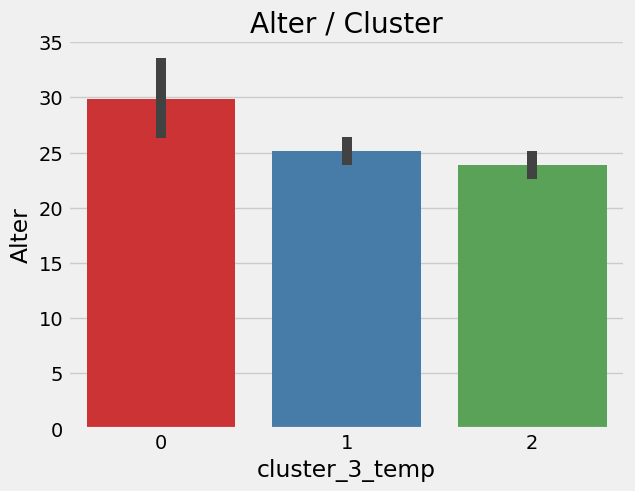

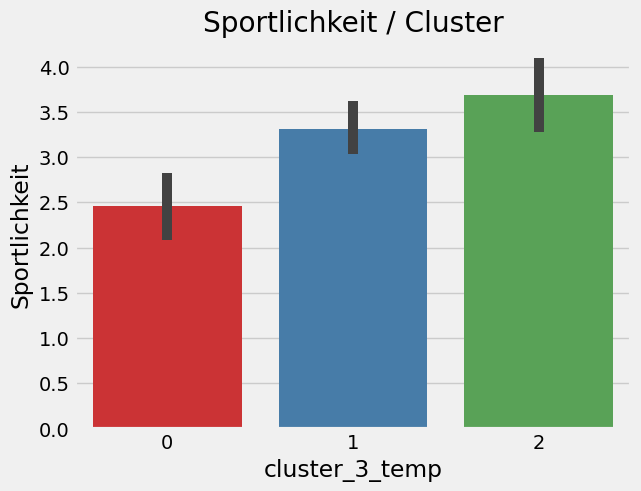

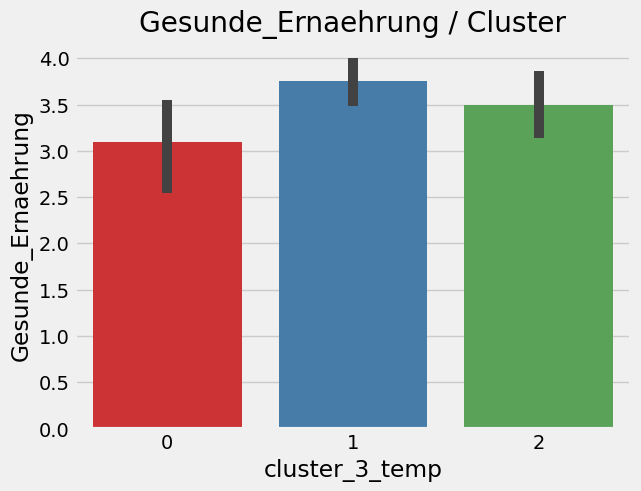

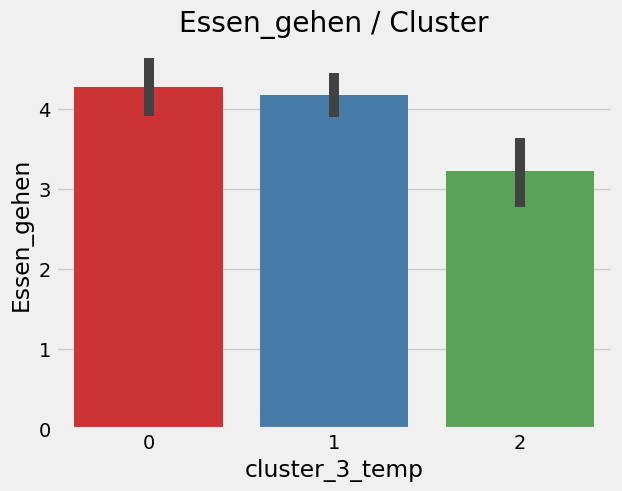

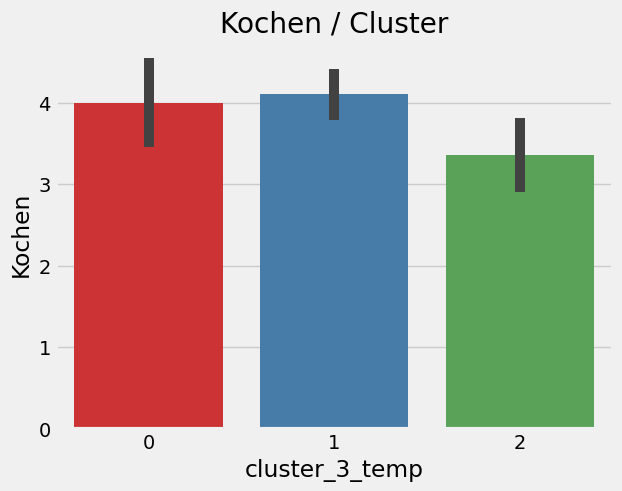

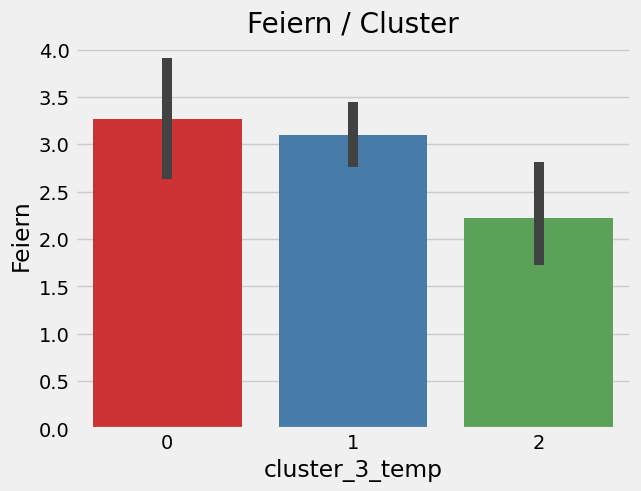

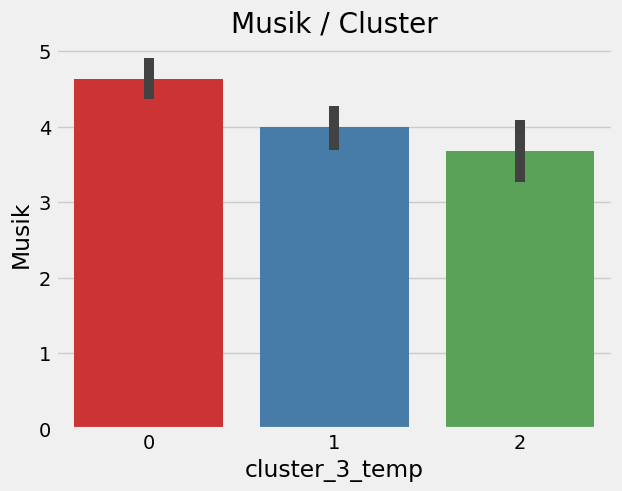

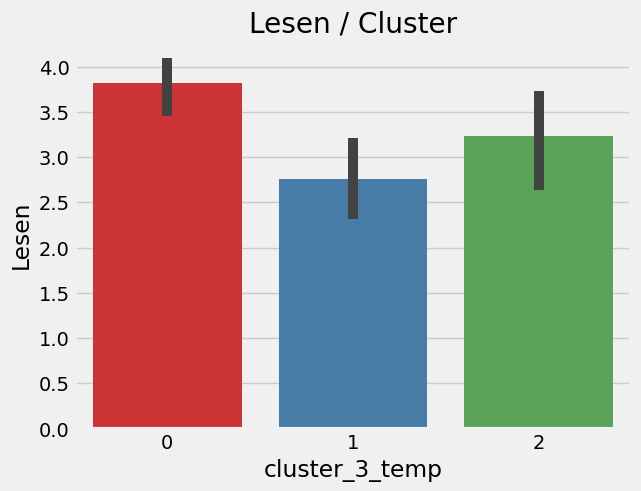

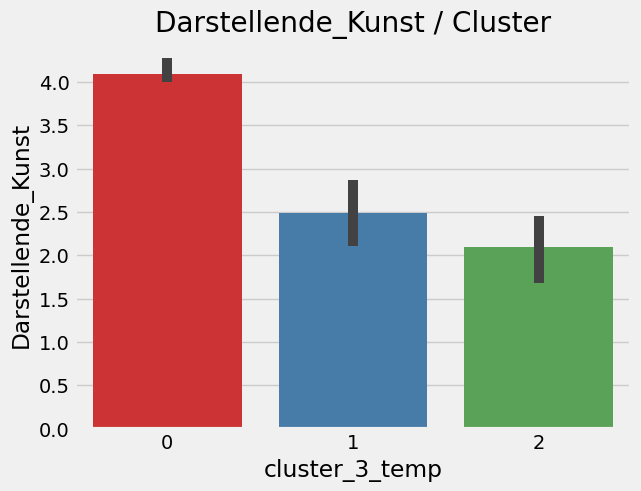

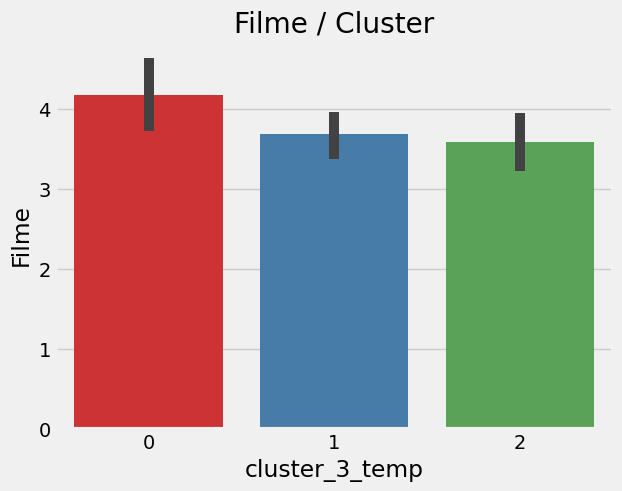

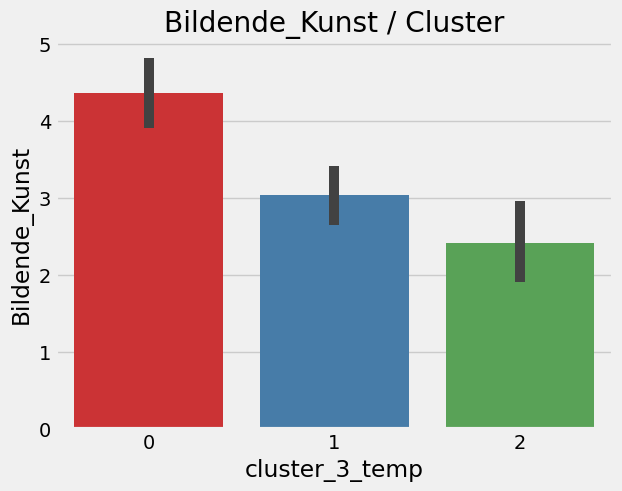

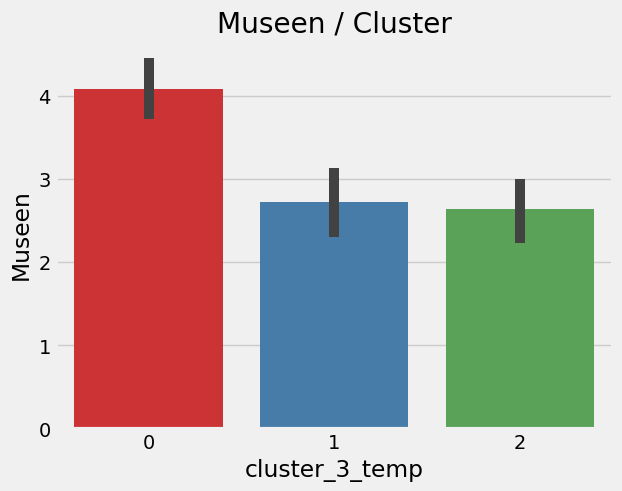

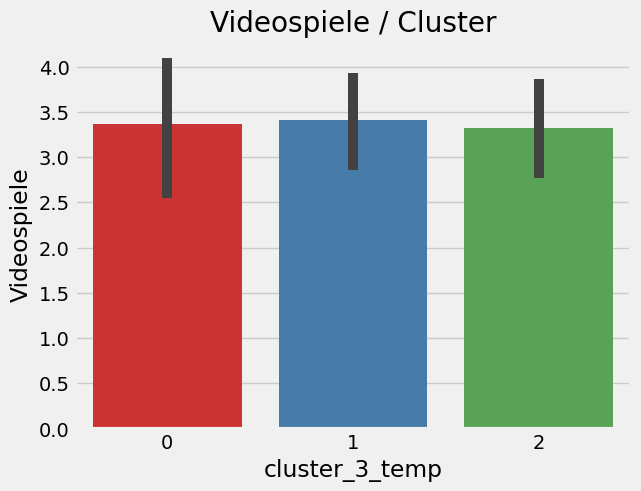

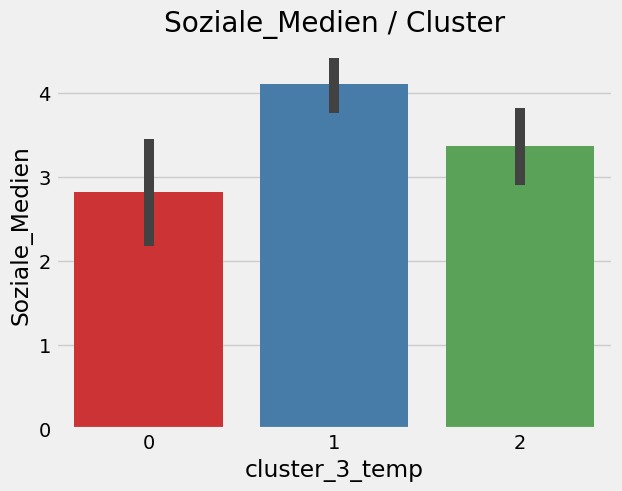

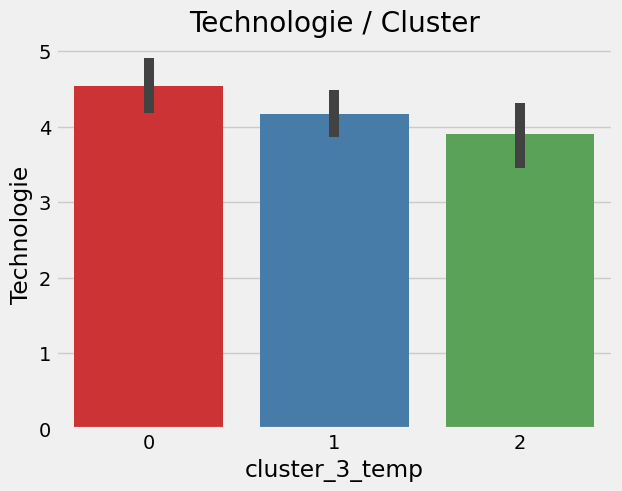

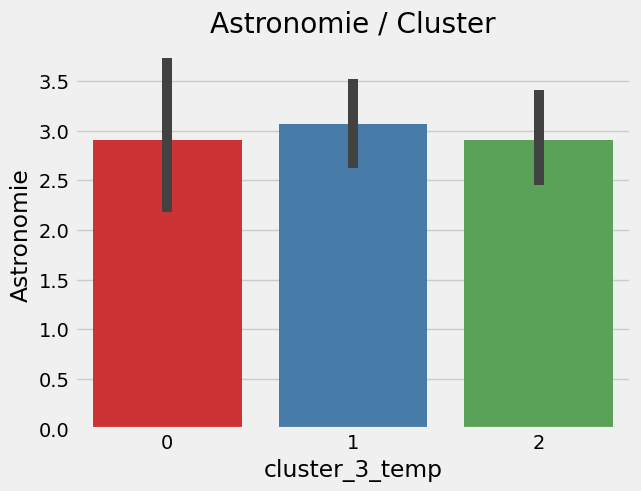

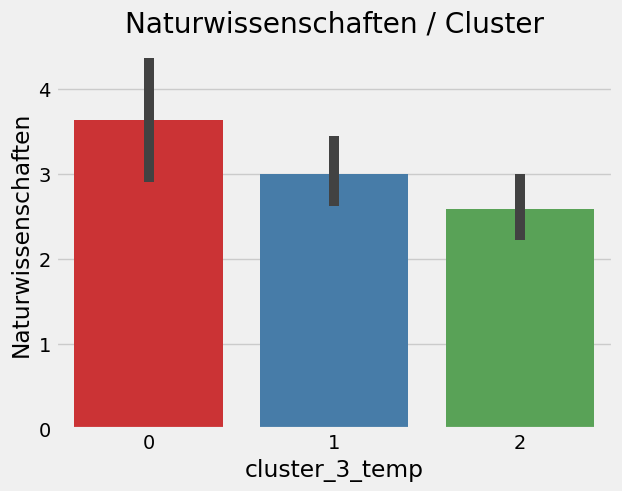

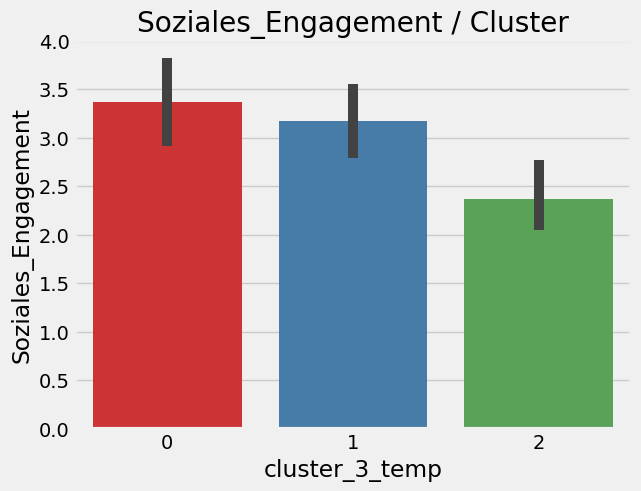

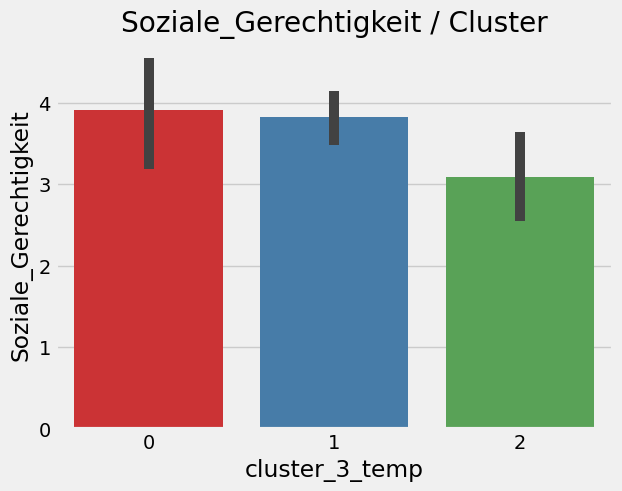

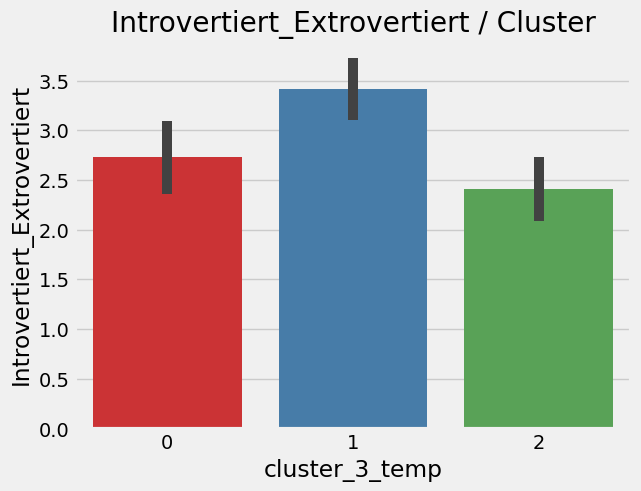

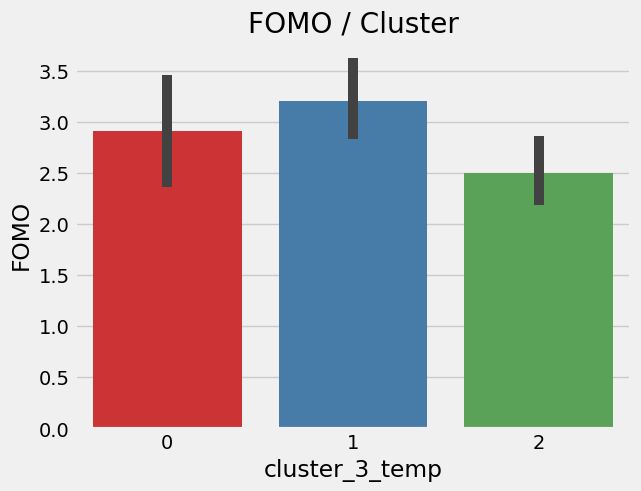

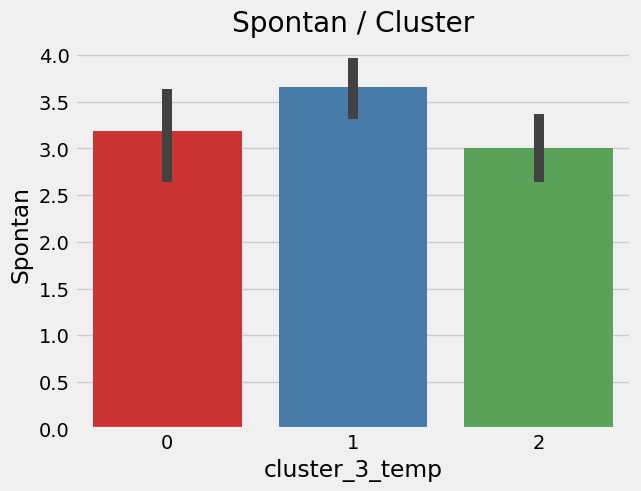

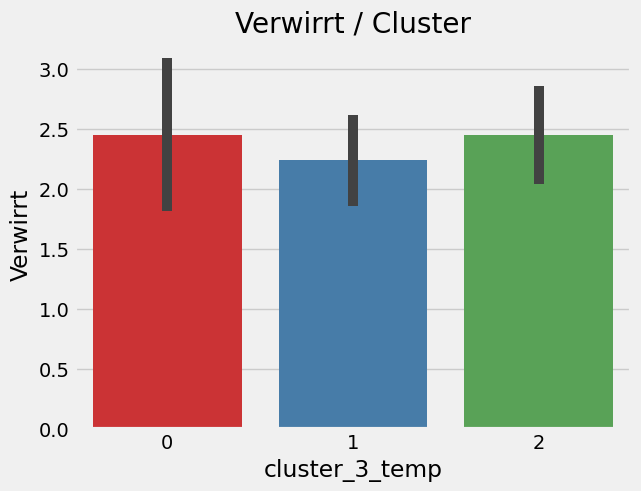

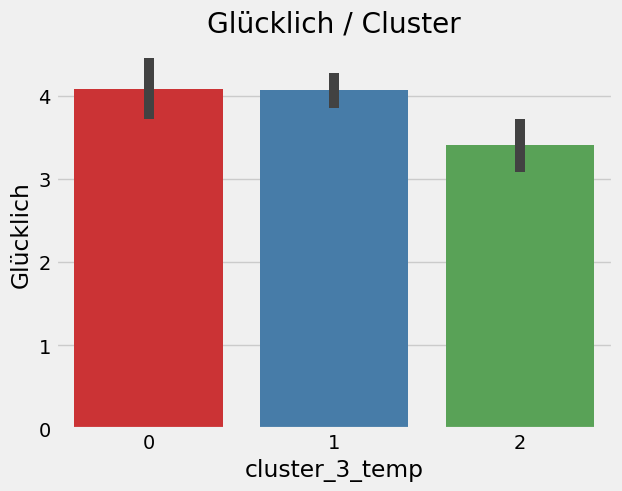

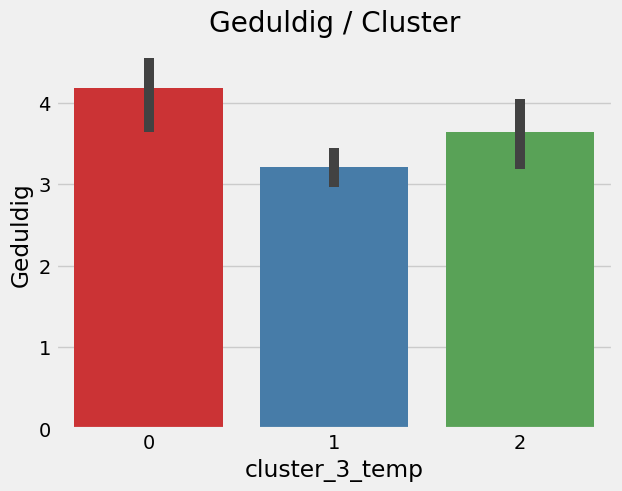

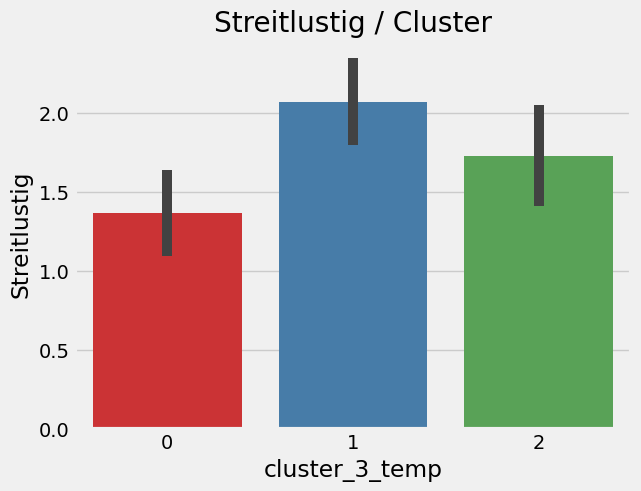

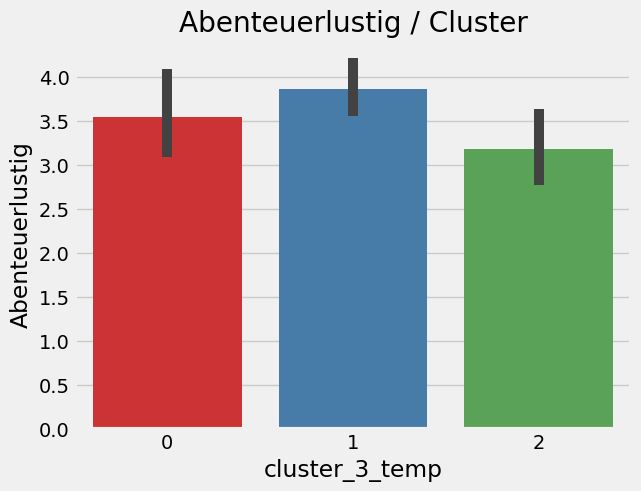

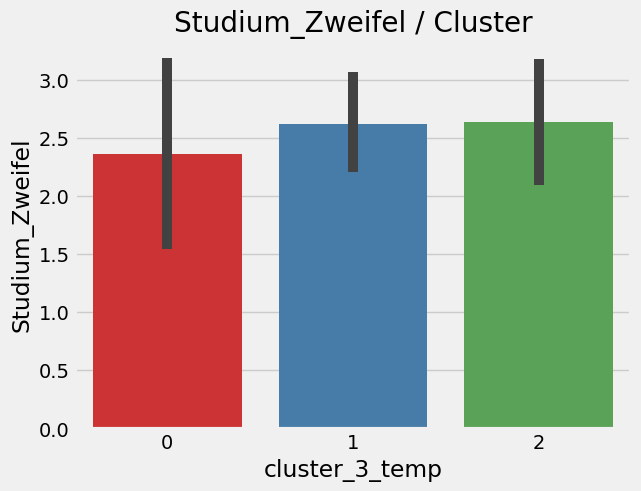

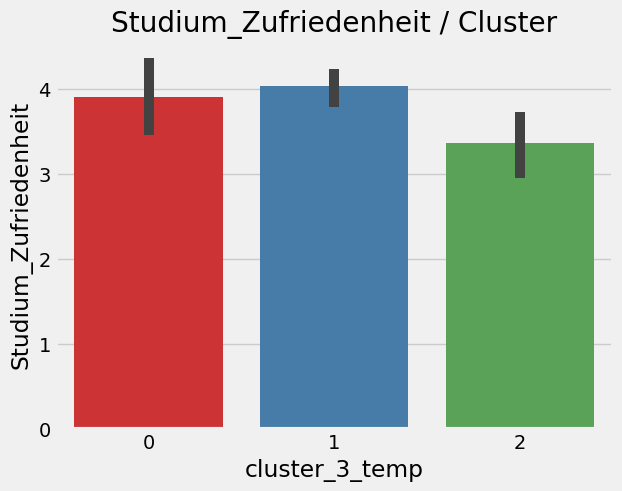

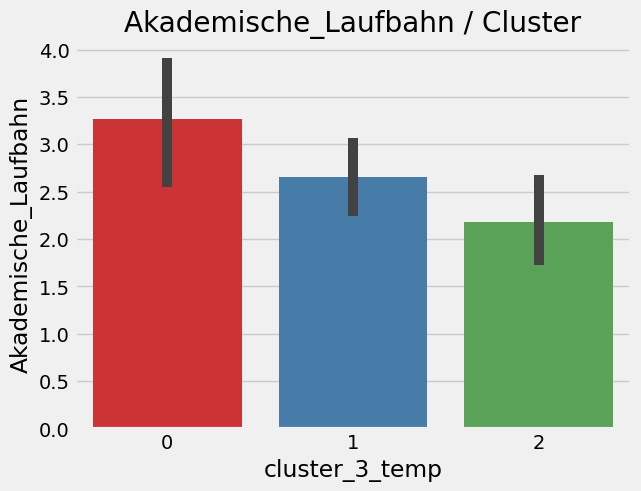

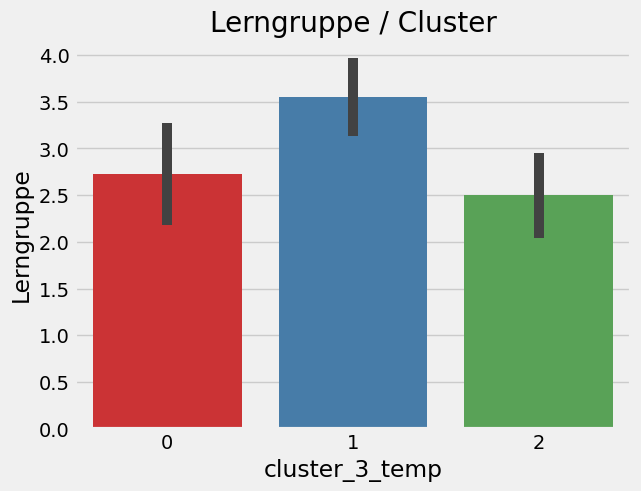

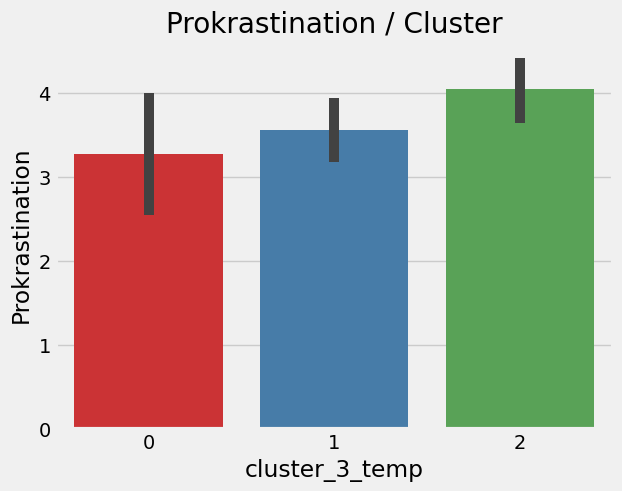

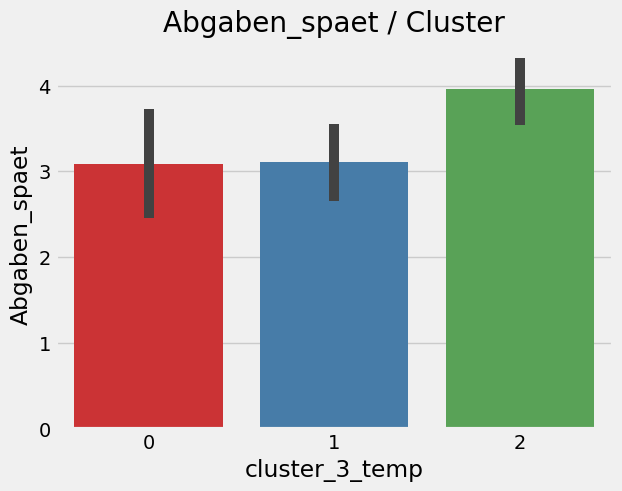

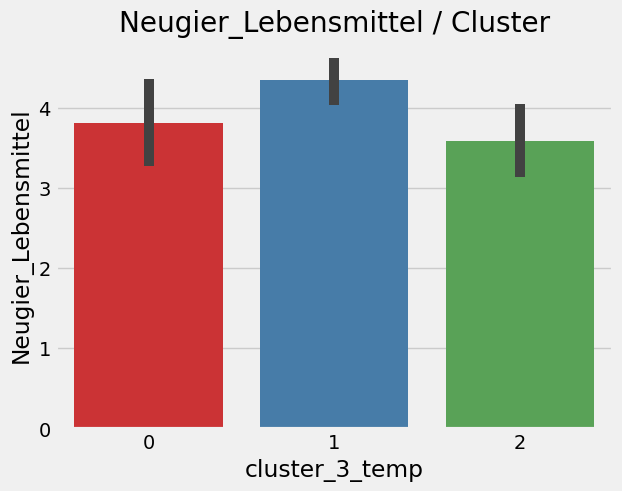

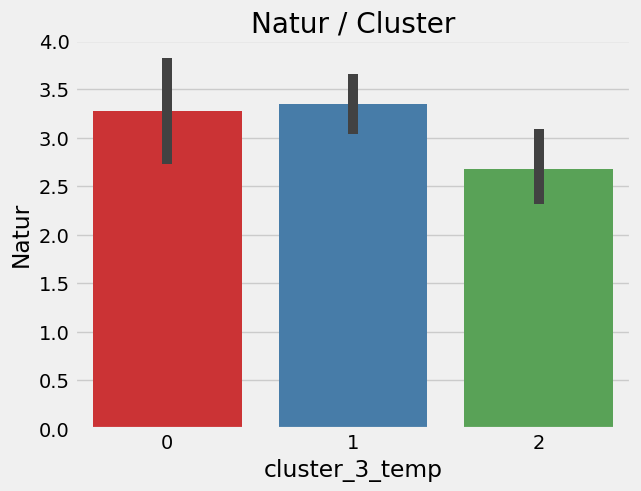

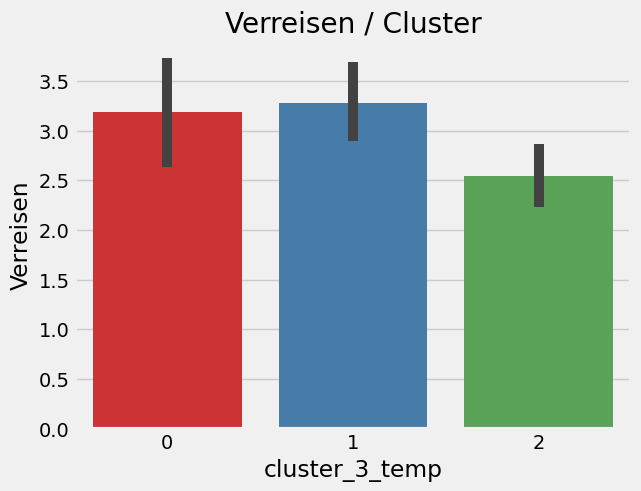

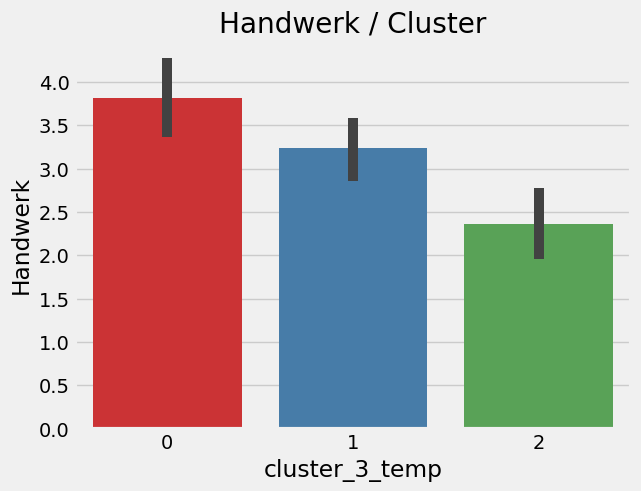

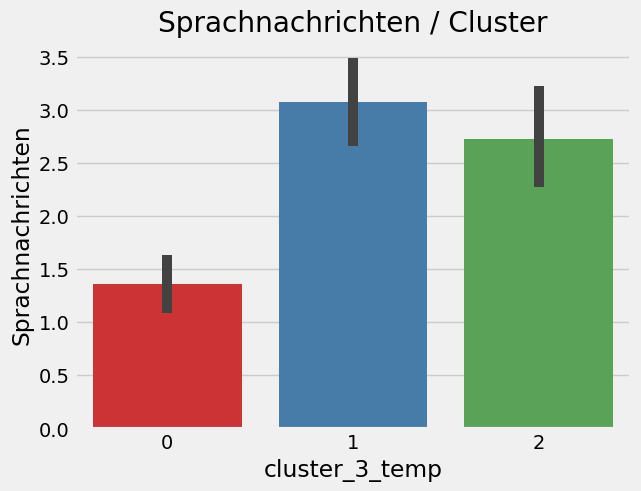

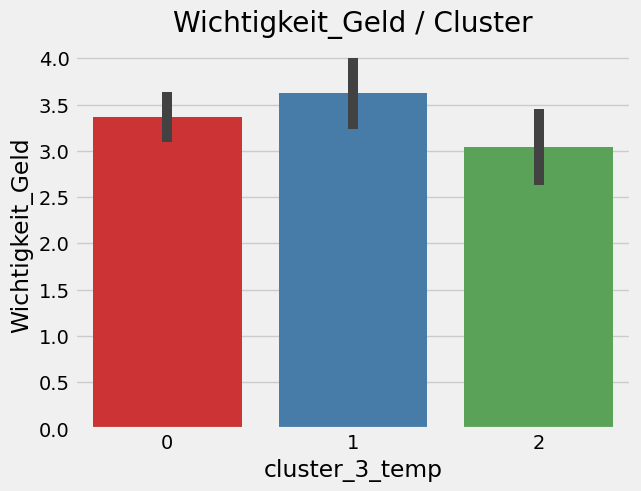

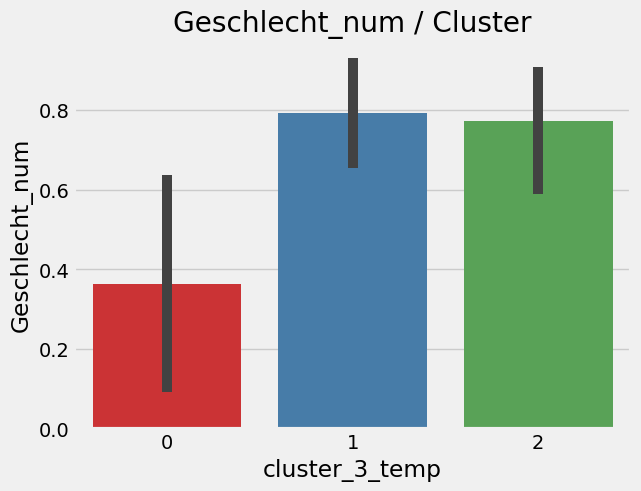

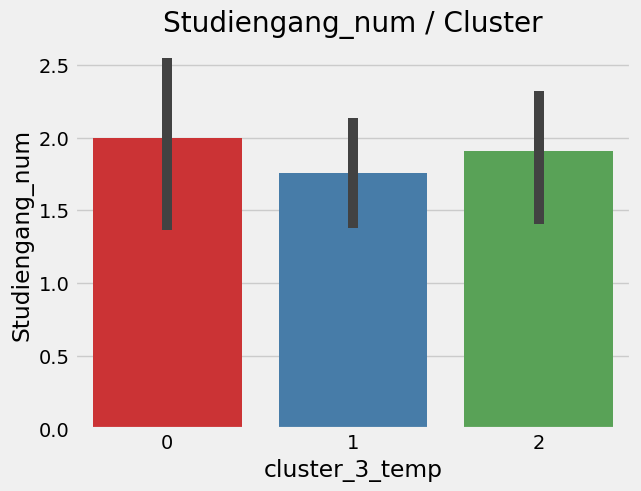

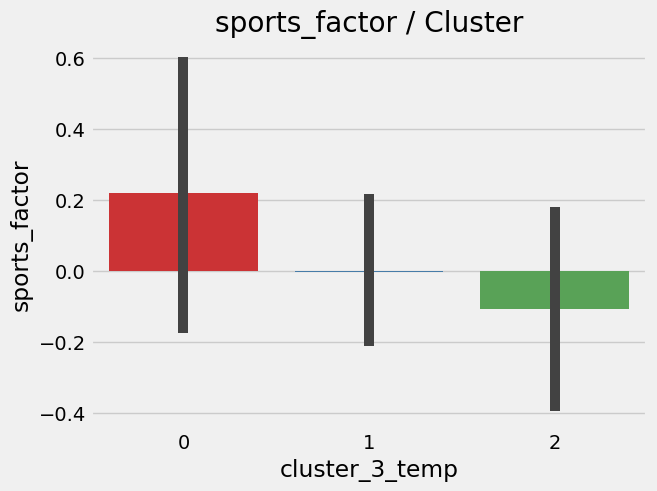

In [200]:
check_clustering(category_list=[data_num_wsf], clusters=3, show_cluster_bars=True)

Axes(0.08,0.07;0.87x0.81)


Index(['Astronomie', 'Abenteuerlustig', 'Streitlustig', 'Naturwissenschaften',
       'Soziale_Gerechtigkeit', 'FOMO', 'Natur', 'Prokrastination',
       'Videospiele', 'Musik', 'Filme', 'Technologie', 'Studiengang_num',
       'Gesunde_Ernaehrung', 'Studium_Zweifel', 'Verwirrt'],
      dtype='object')

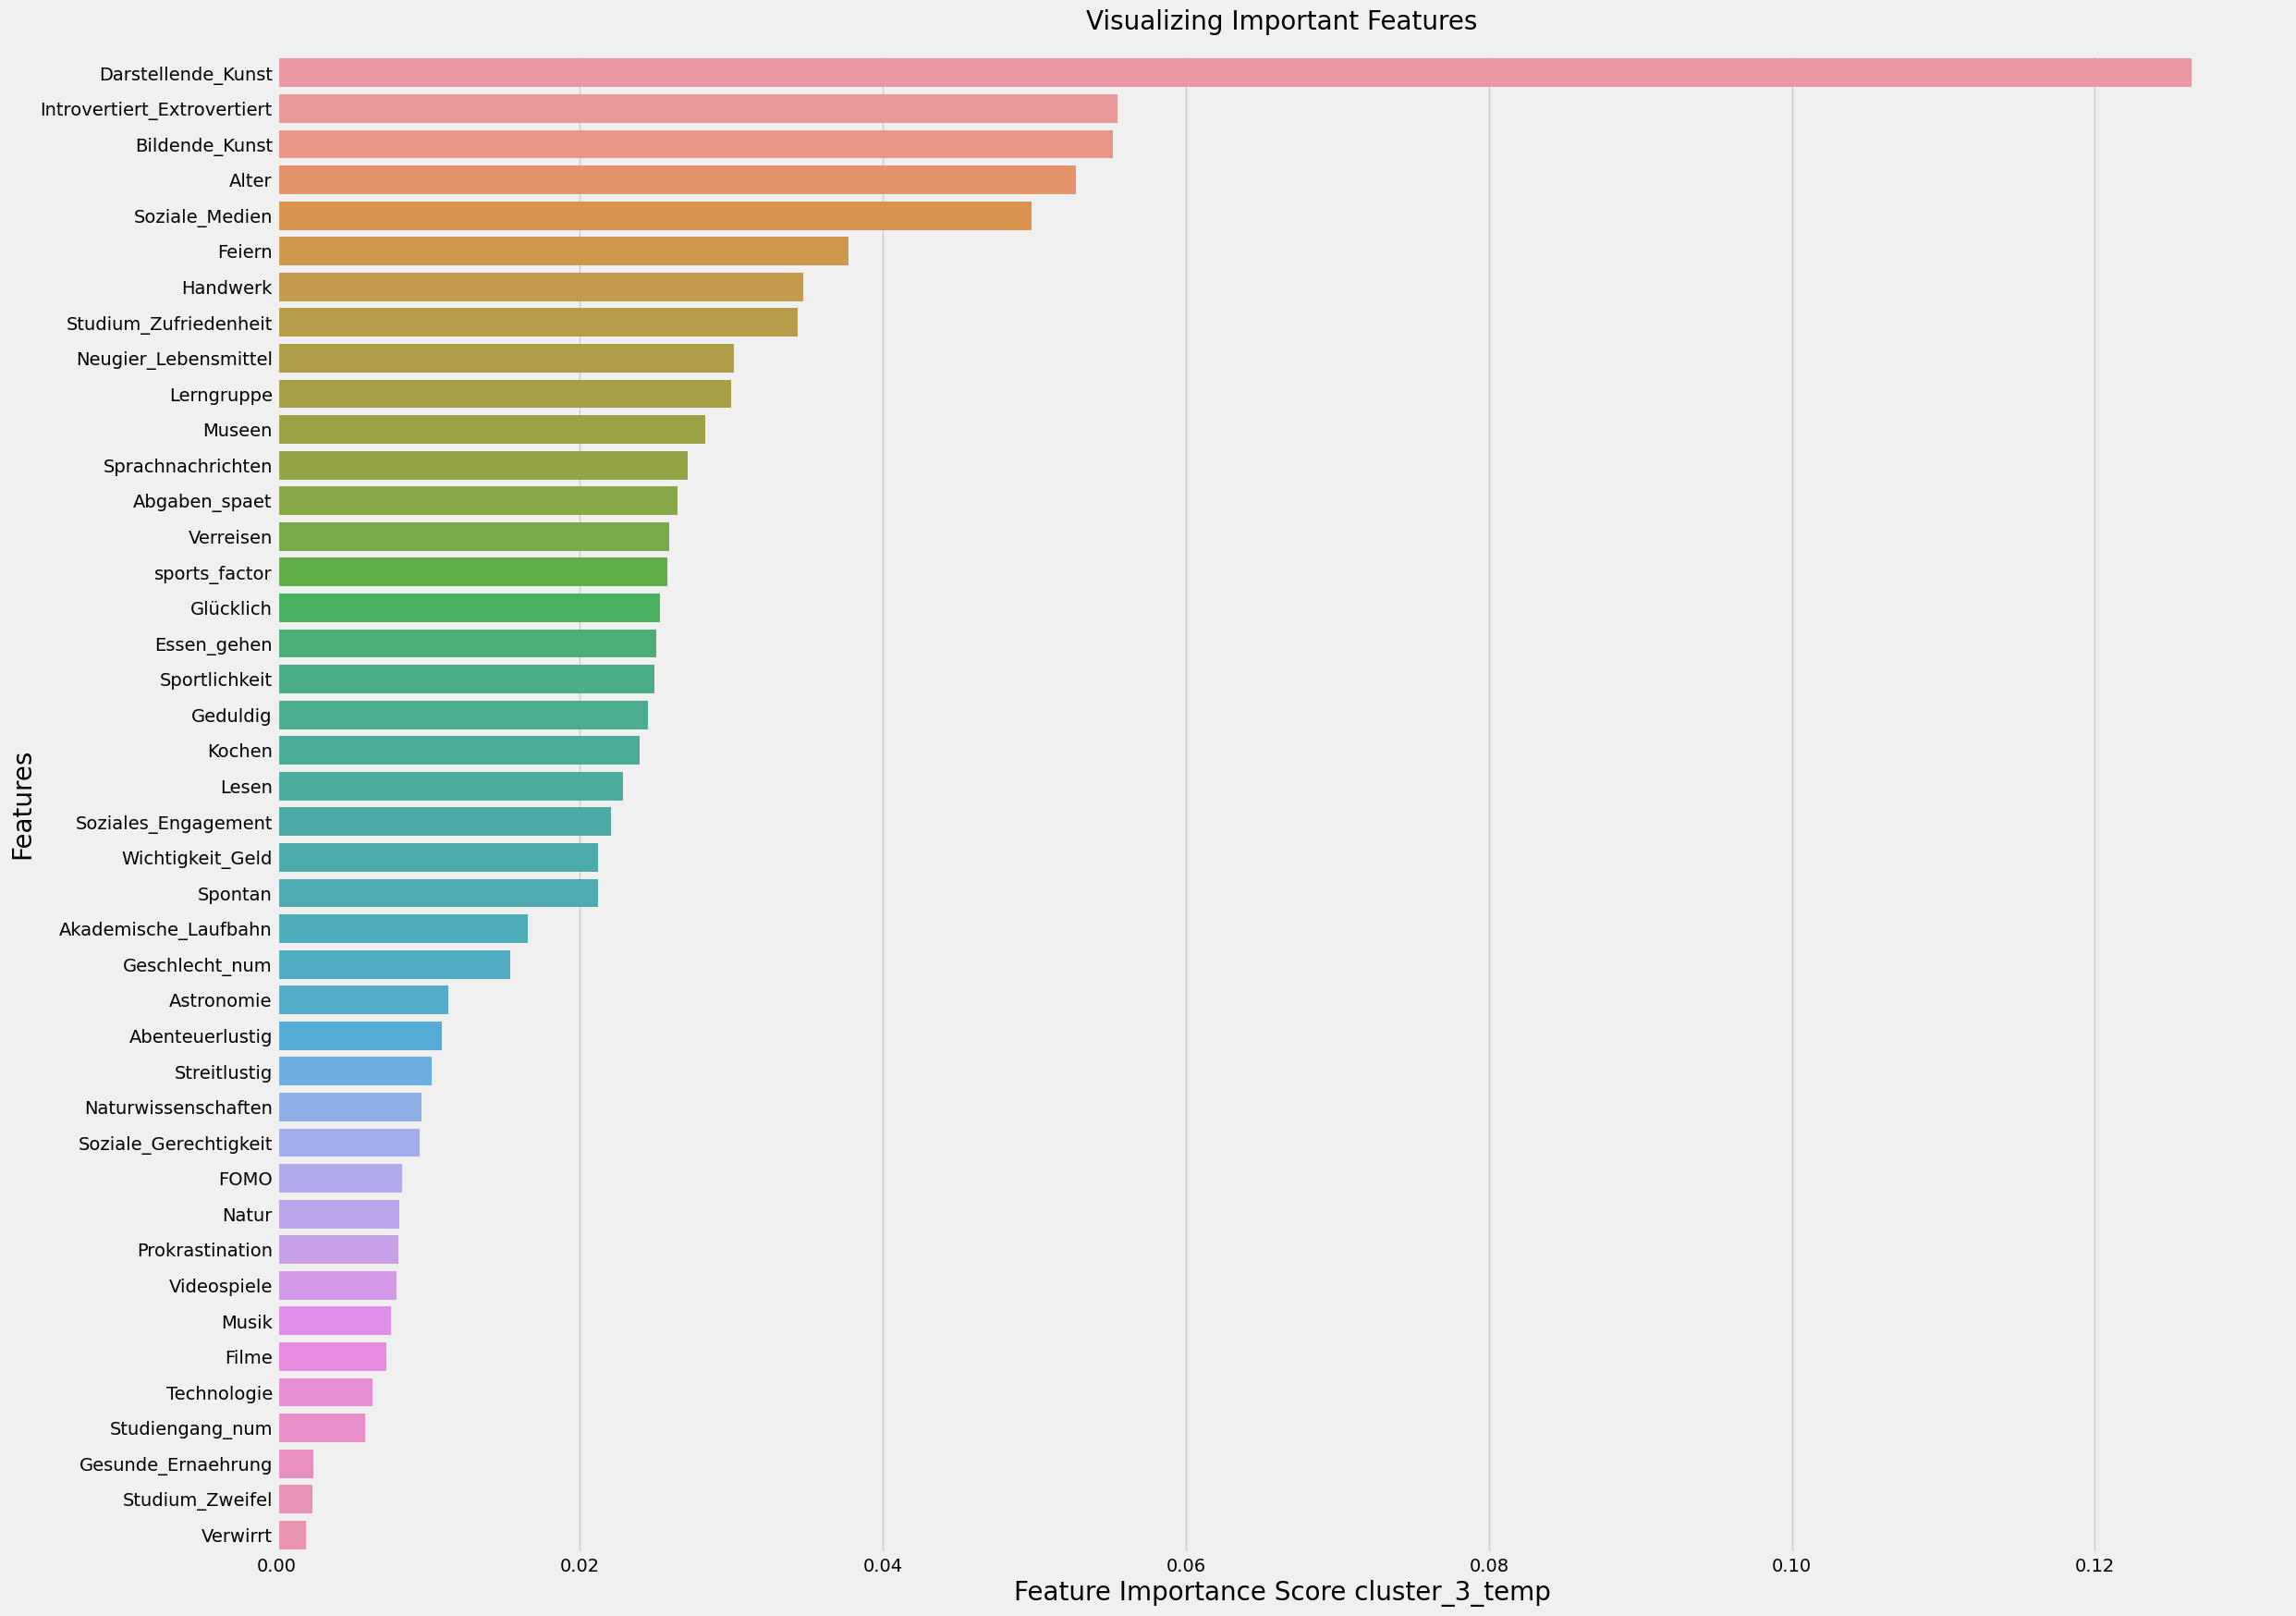

In [201]:
data_wsf_clustered_3, cluster_name_wsf_3 = scaling_and_clustering(data_num_wsf, clusters=3)
#print(data_wsf_clustered_3, cluster_name_wsf_3)
columns_to_drop_wsf_3= feature_selection(data=data_wsf_clustered_3, label_column=cluster_name_wsf_3, threshold=0.015)
columns_to_drop_wsf_3

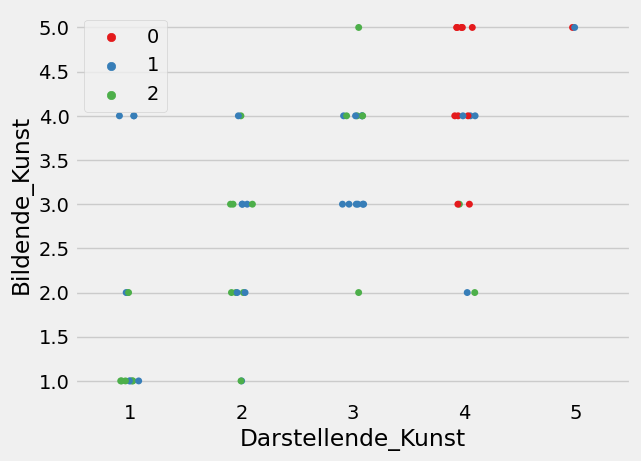

In [202]:
draw_stripplot(data_wsf_clustered_3, 'Darstellende_Kunst', 'Bildende_Kunst', cluster_name_wsf_3)

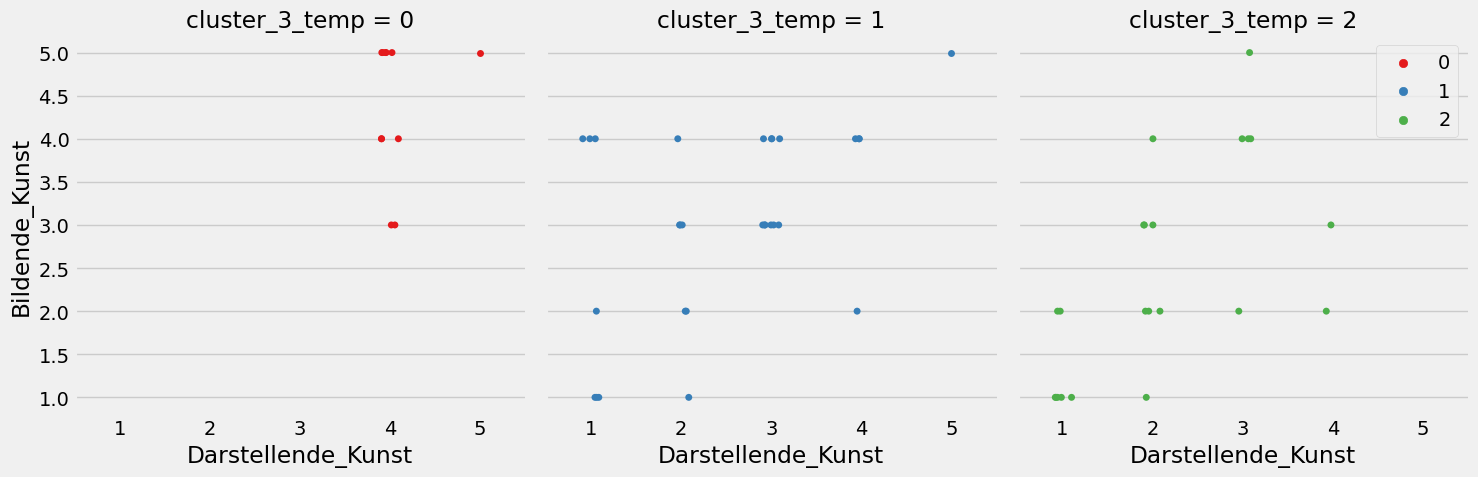

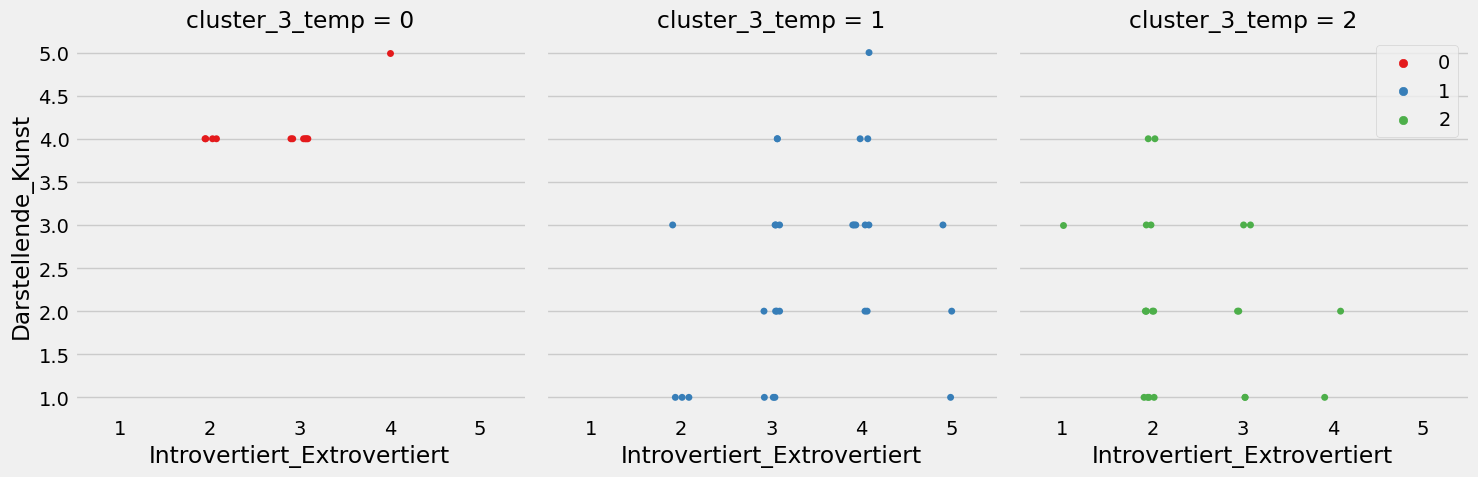

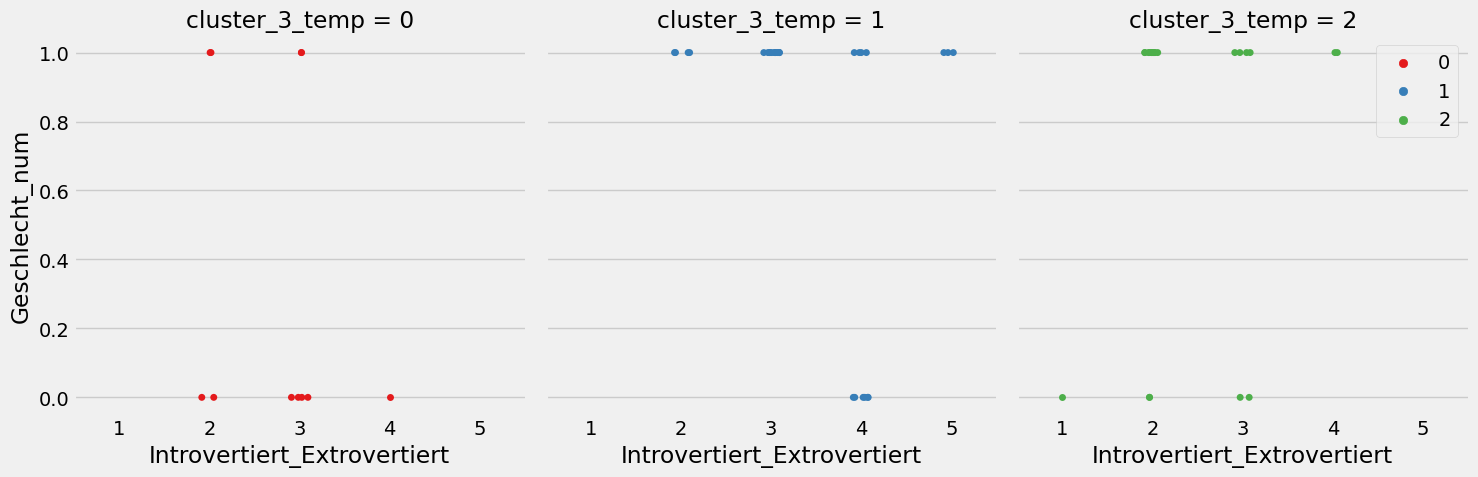

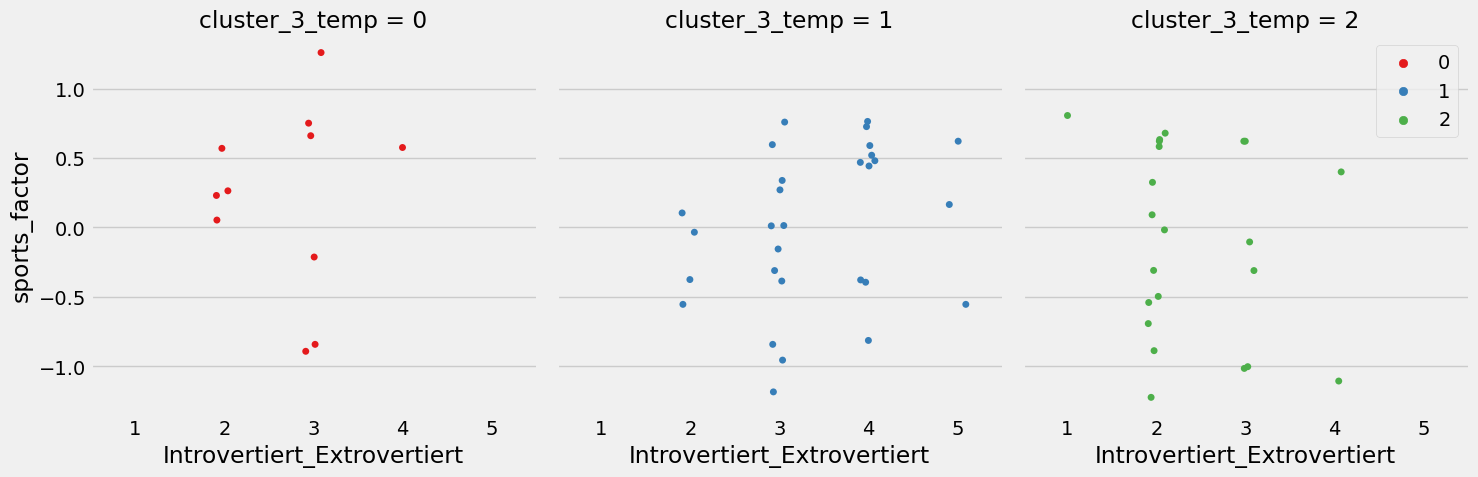

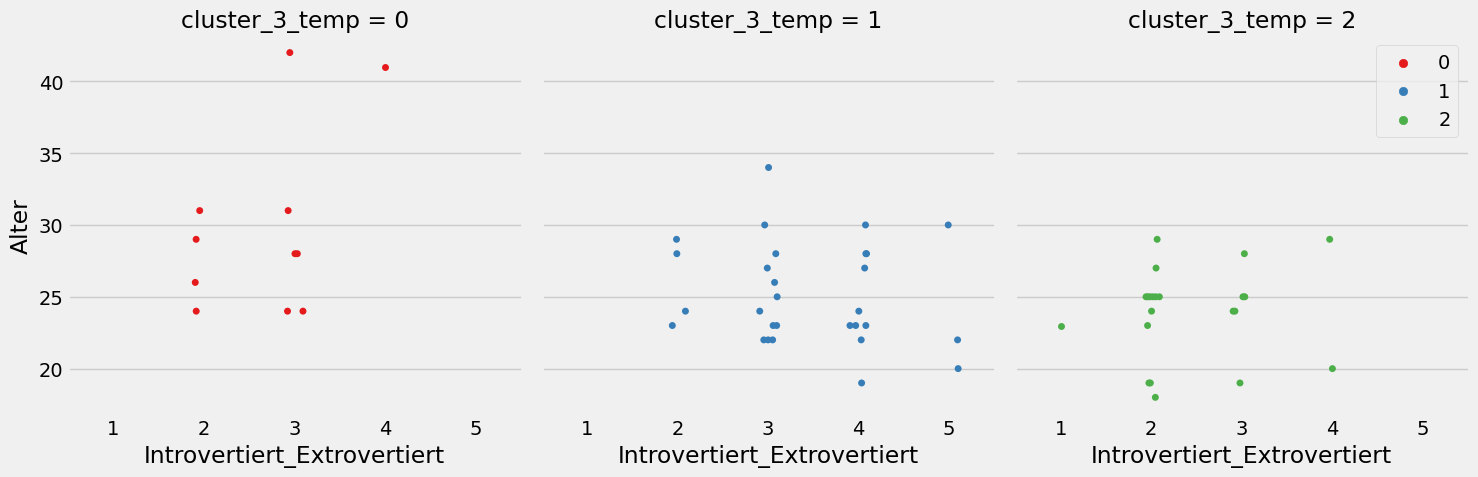

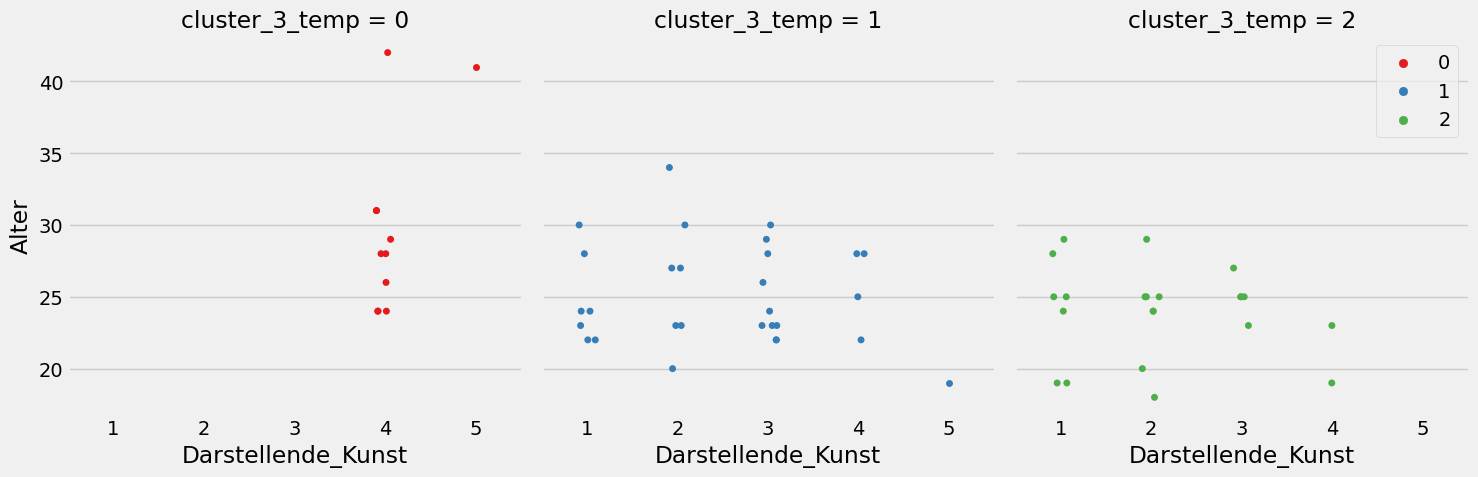

In [208]:
draw_catplot(data_wsf_clustered_3, 'Darstellende_Kunst', 'Bildende_Kunst', cluster_name_wsf_3)
draw_catplot(data_wsf_clustered_3, 'Introvertiert_Extrovertiert', 'Darstellende_Kunst', cluster_name_wsf_3)
draw_catplot(data_wsf_clustered_3, 'Introvertiert_Extrovertiert', 'Geschlecht_num', cluster_name_wsf_3)
draw_catplot(data_wsf_clustered_3, 'Introvertiert_Extrovertiert', 'sports_factor', cluster_name_wsf_3)
draw_catplot(data_wsf_clustered_3, 'Introvertiert_Extrovertiert', 'Alter', cluster_name_wsf_3)
draw_catplot(data_wsf_clustered_3, 'Darstellende_Kunst', 'Alter', cluster_name_wsf_3)

## 5 Cluster

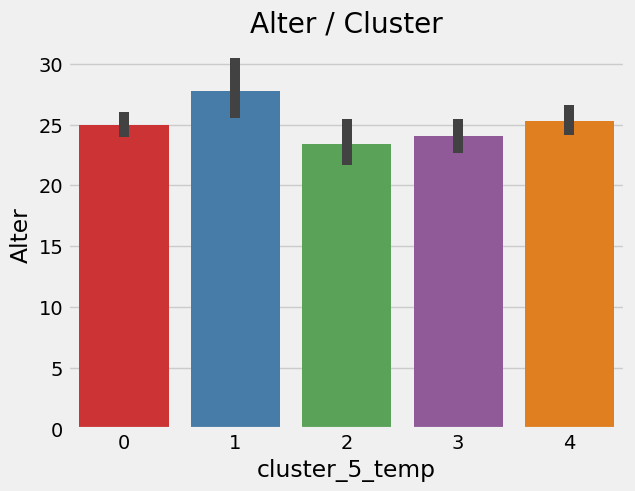

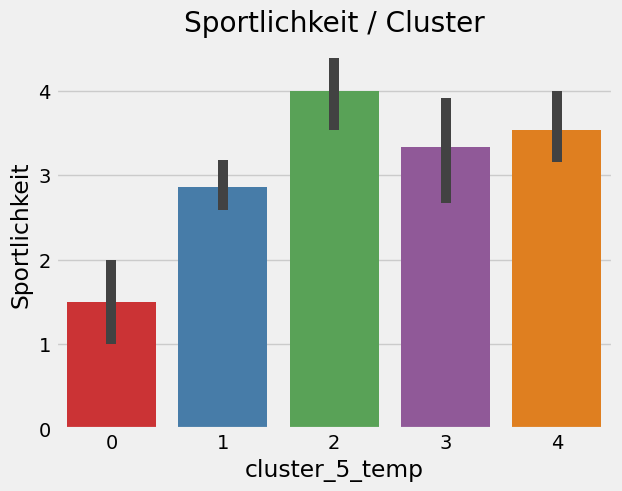

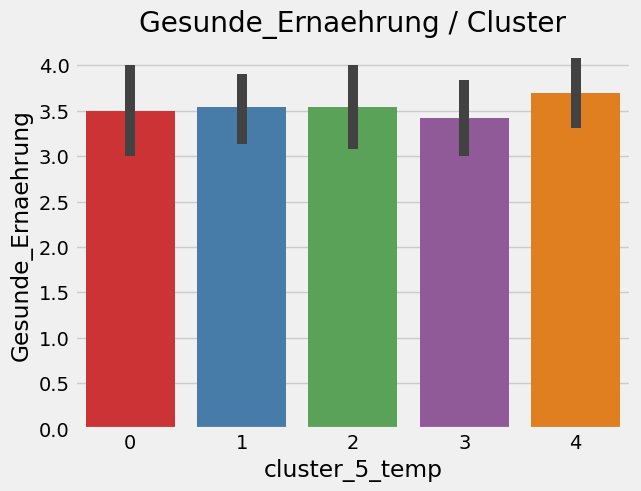

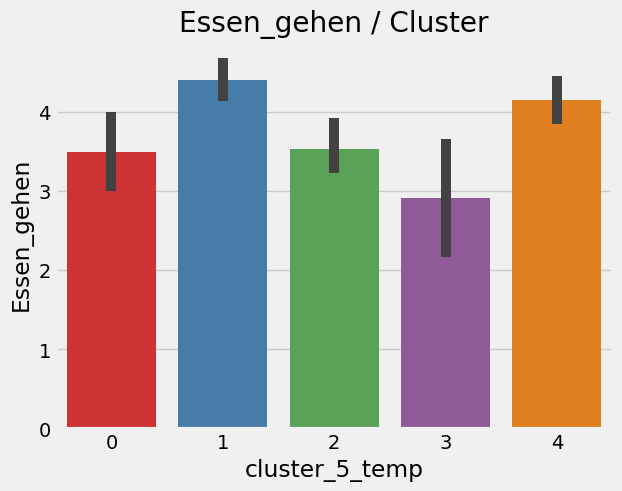

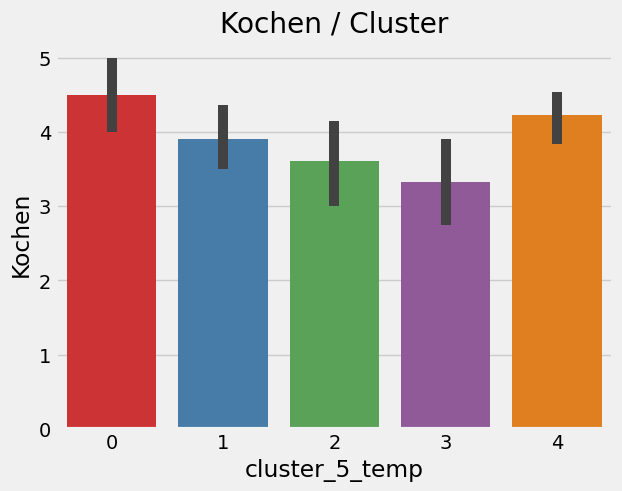

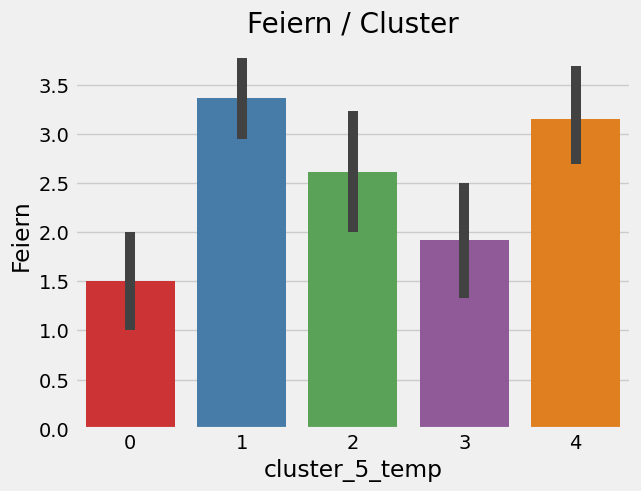

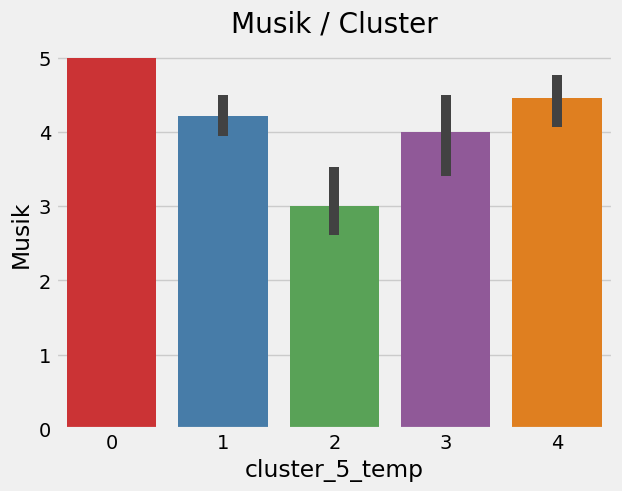

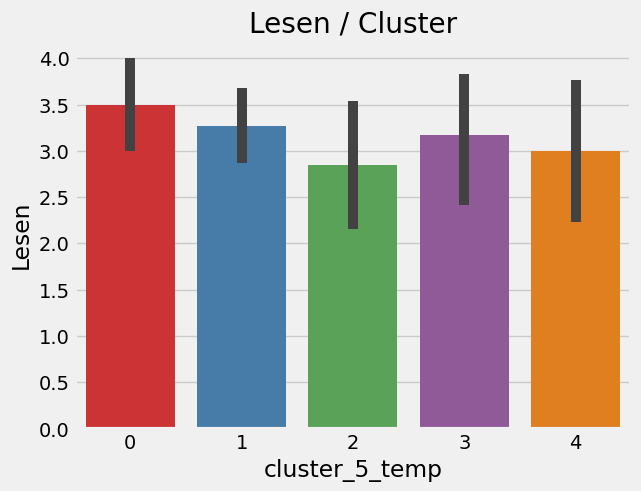

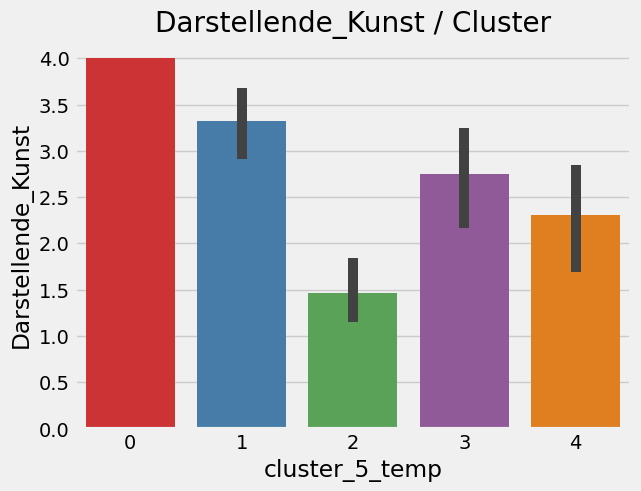

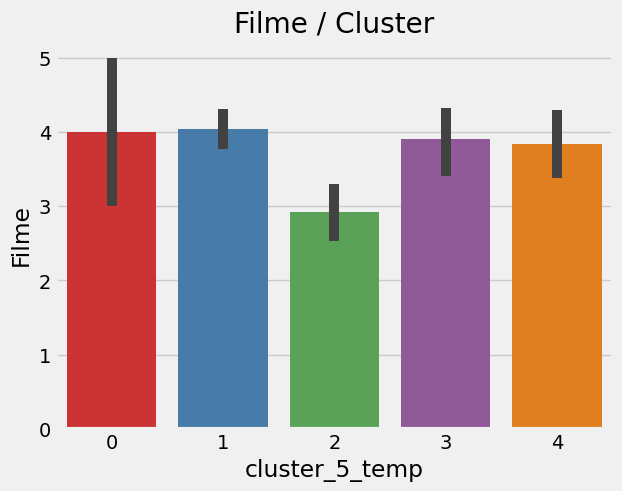

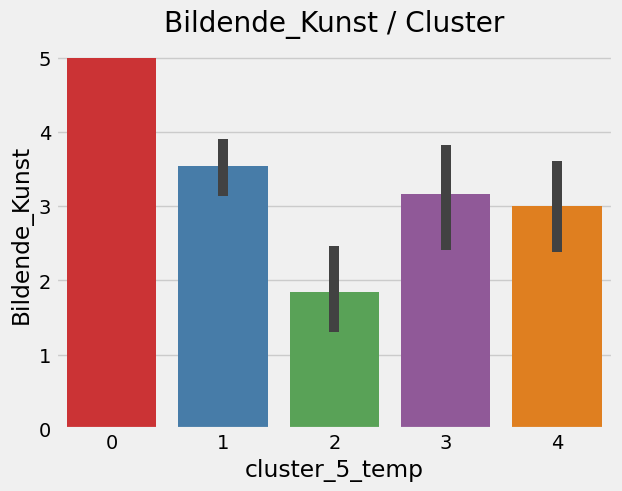

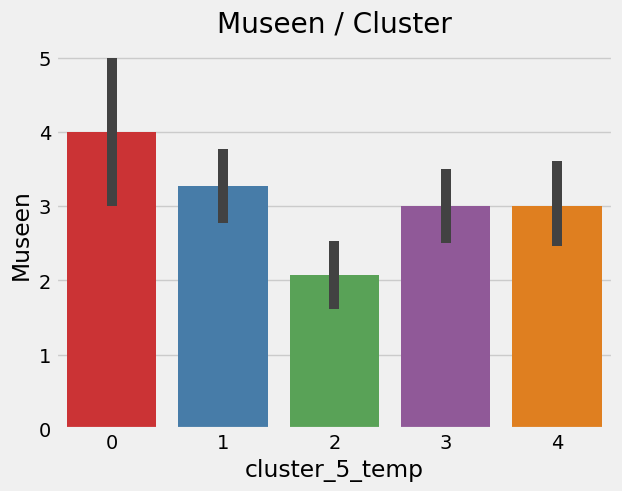

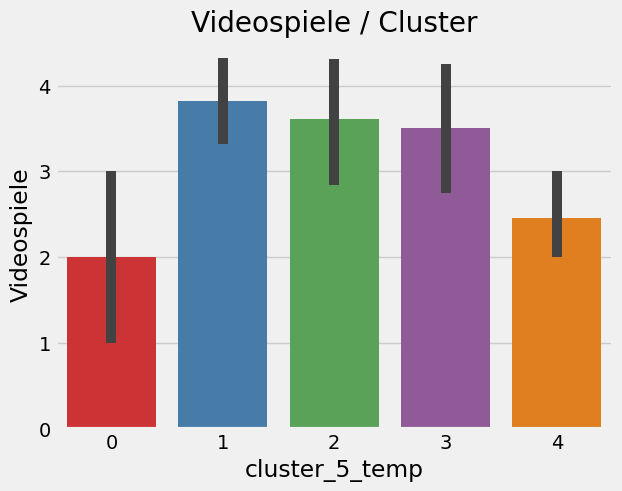

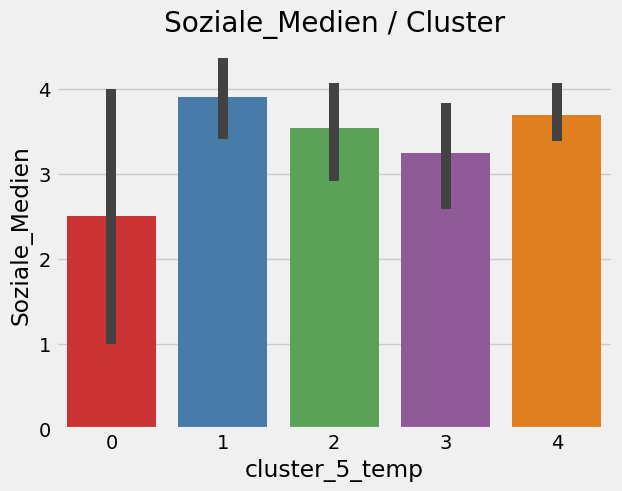

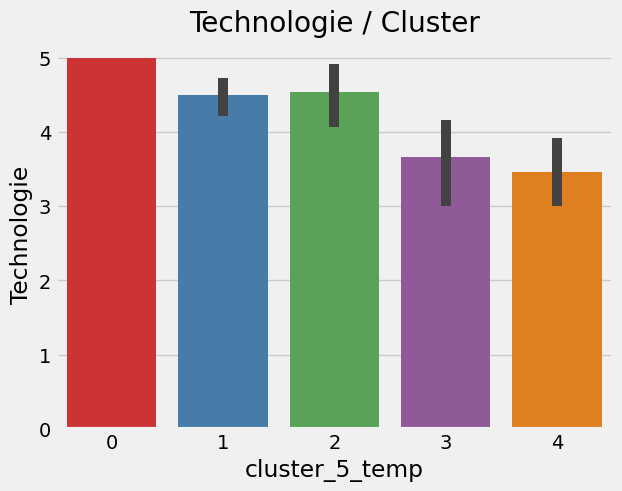

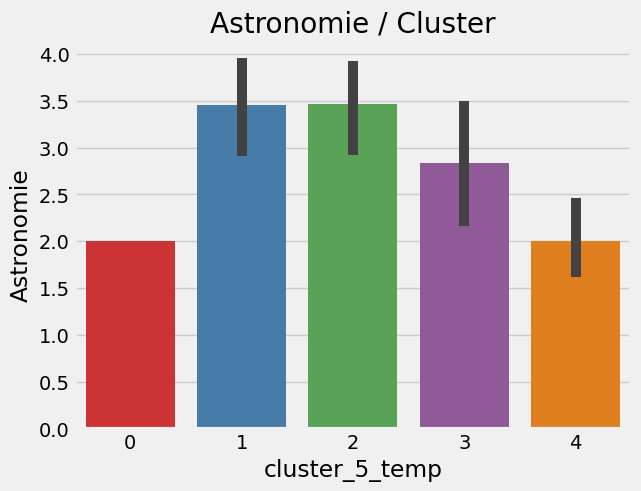

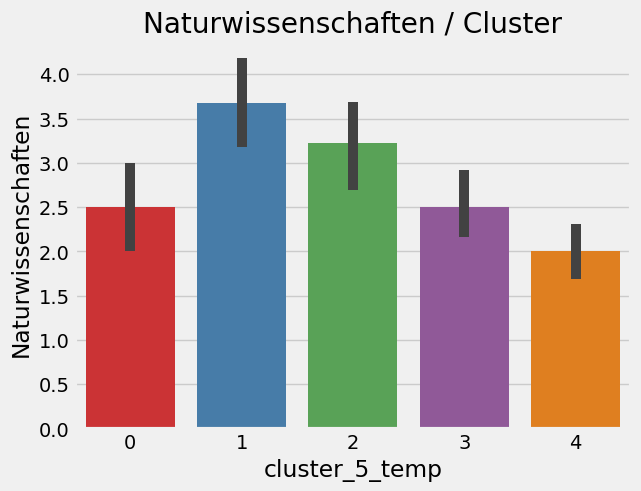

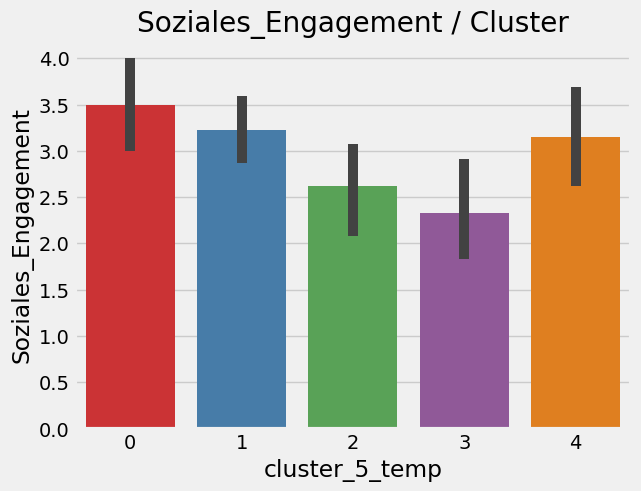

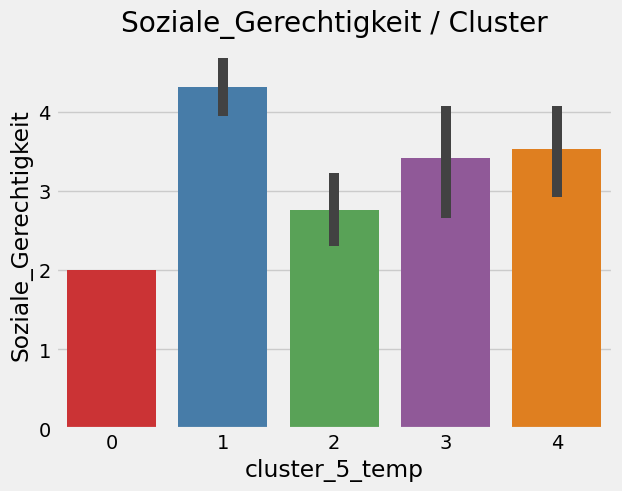

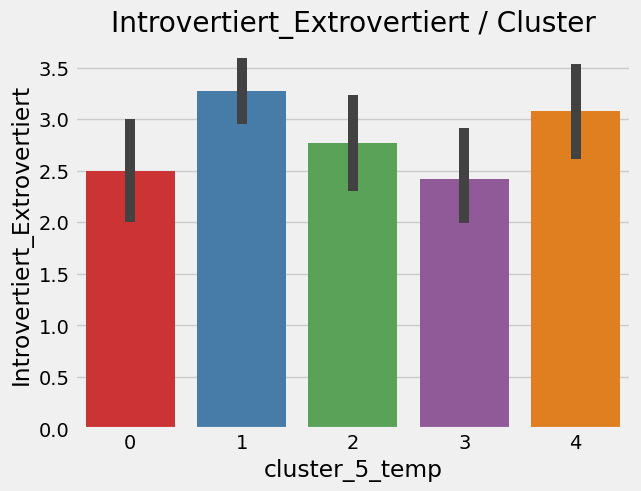

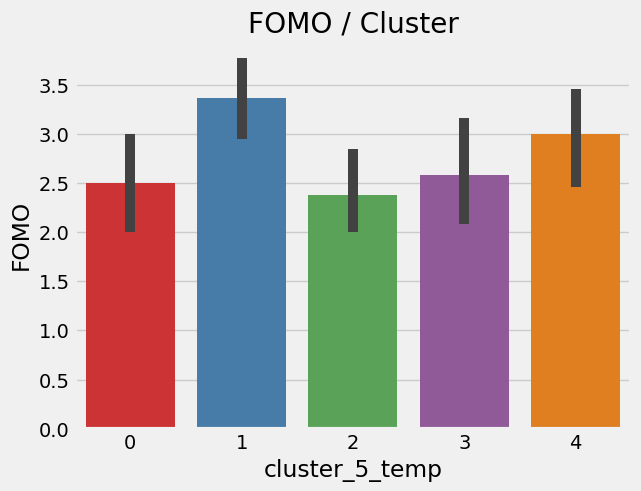

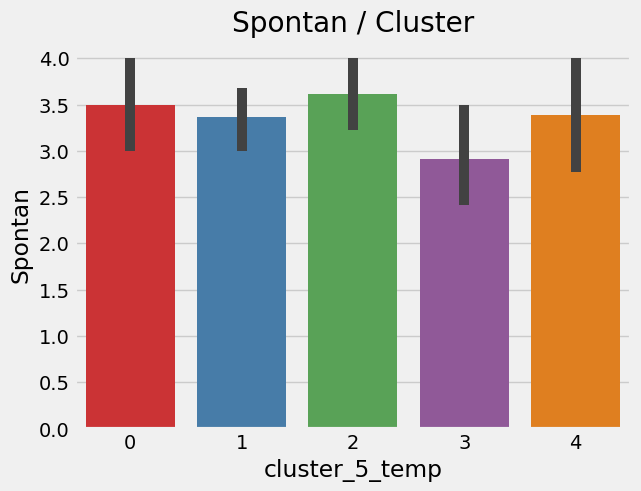

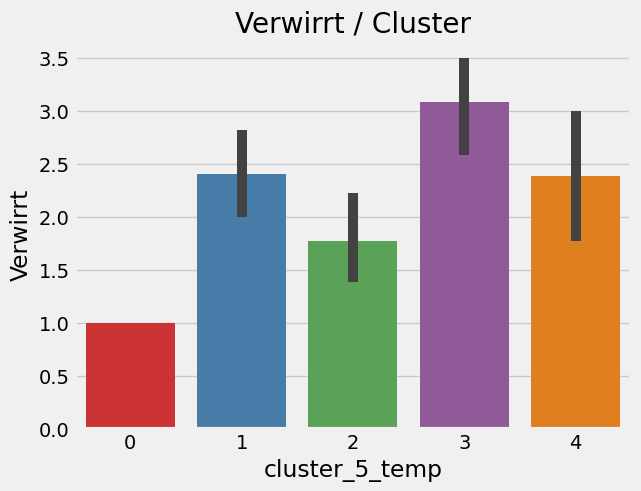

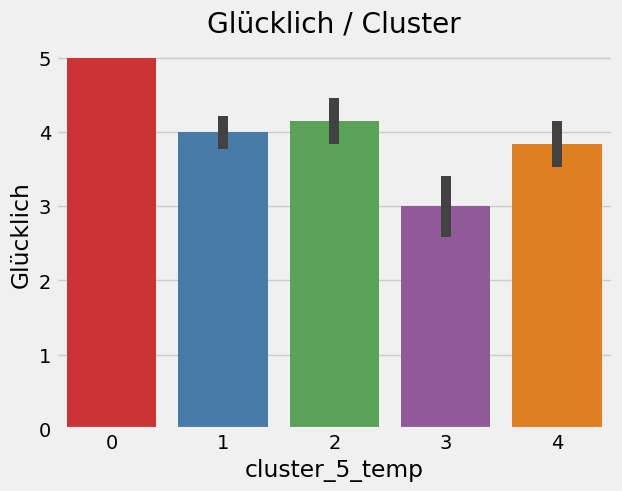

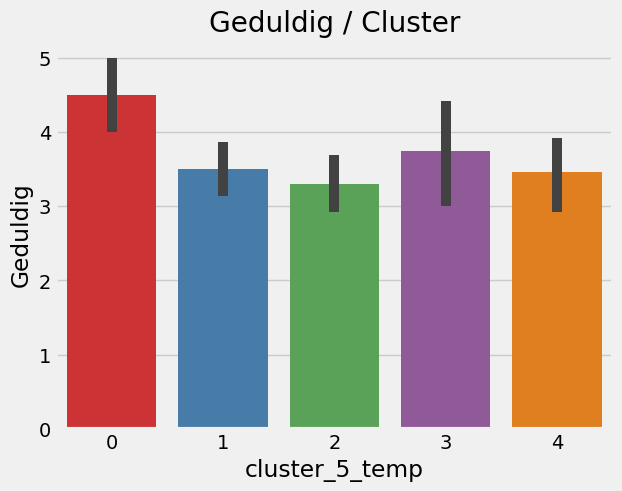

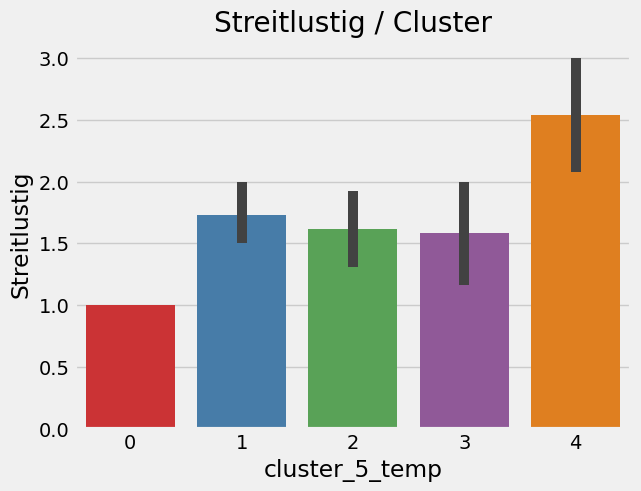

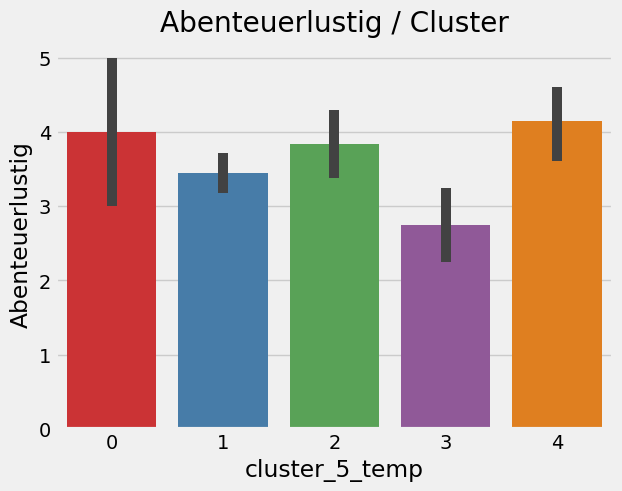

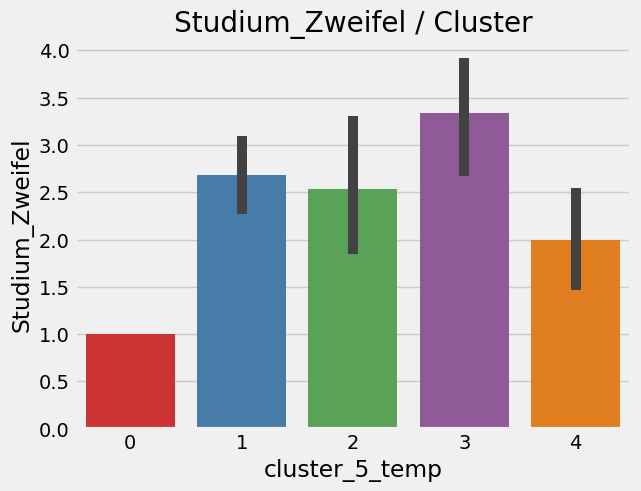

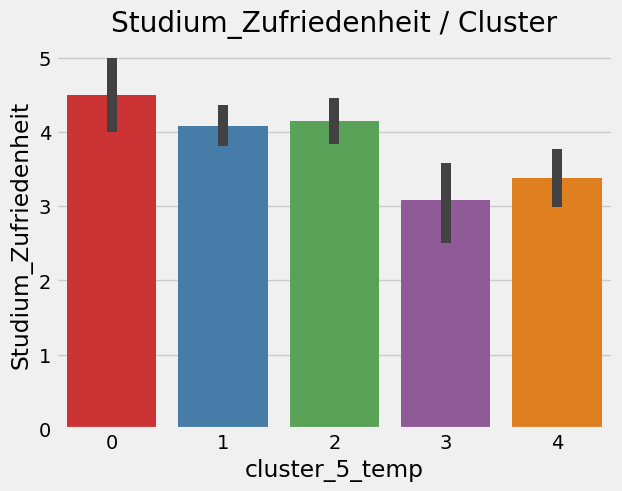

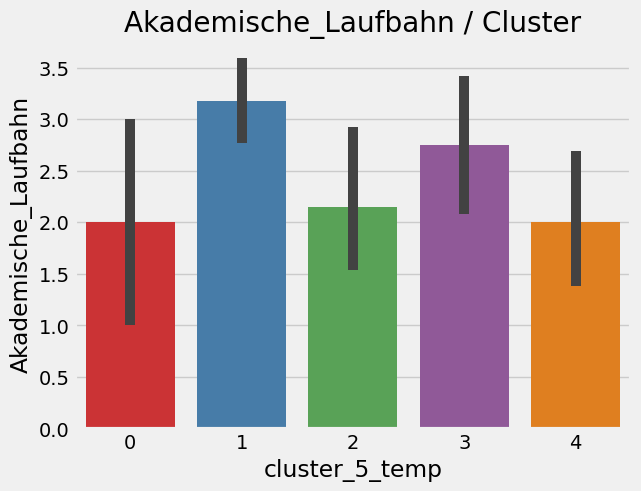

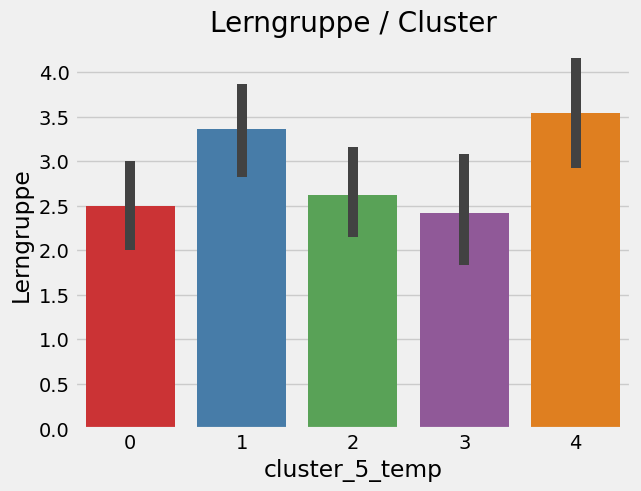

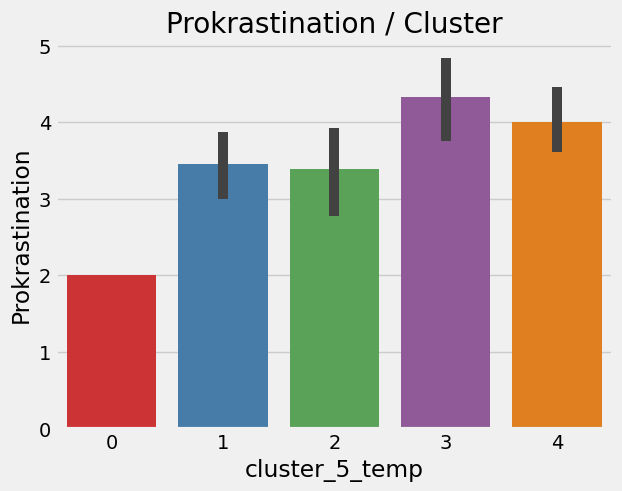

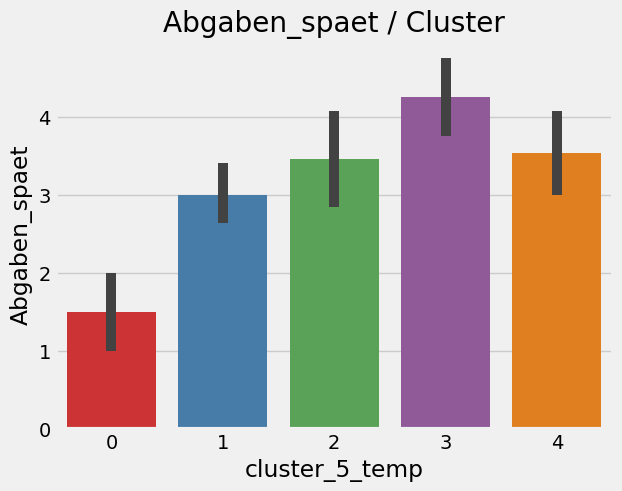

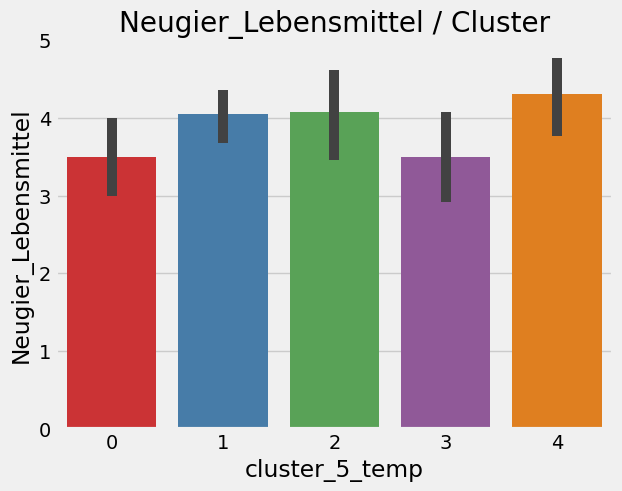

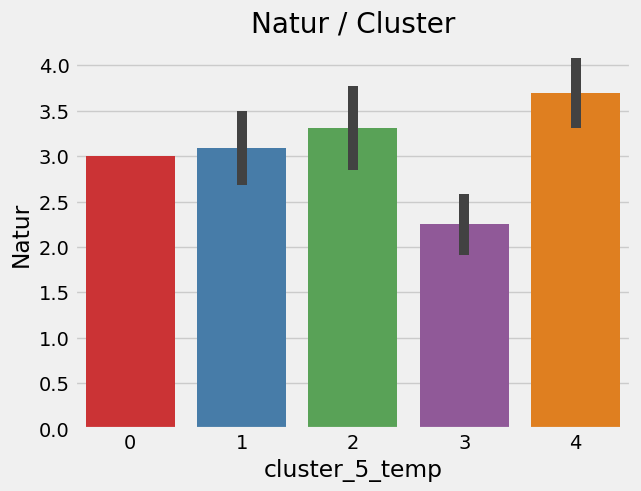

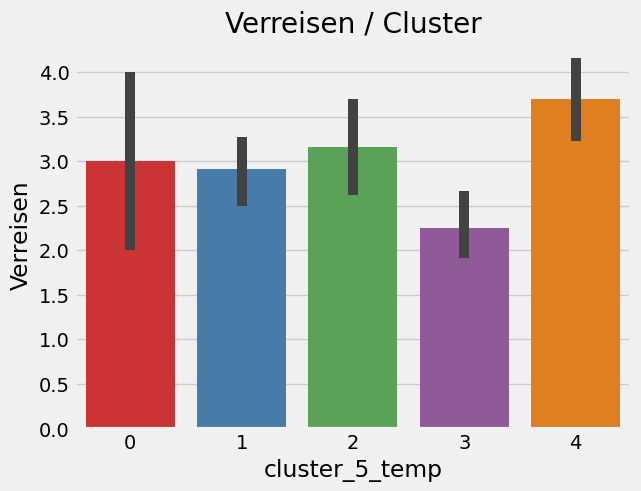

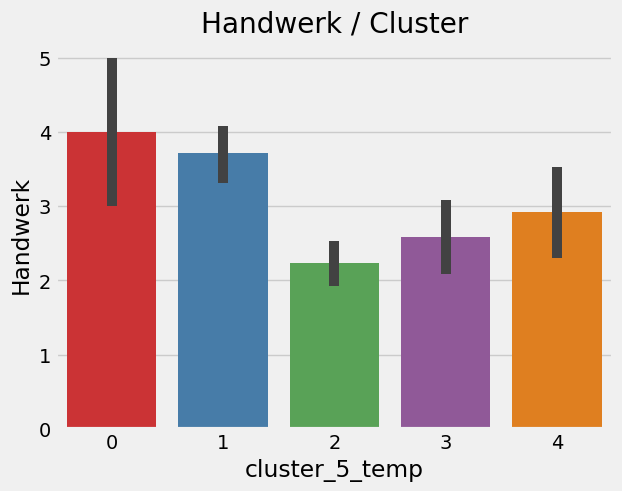

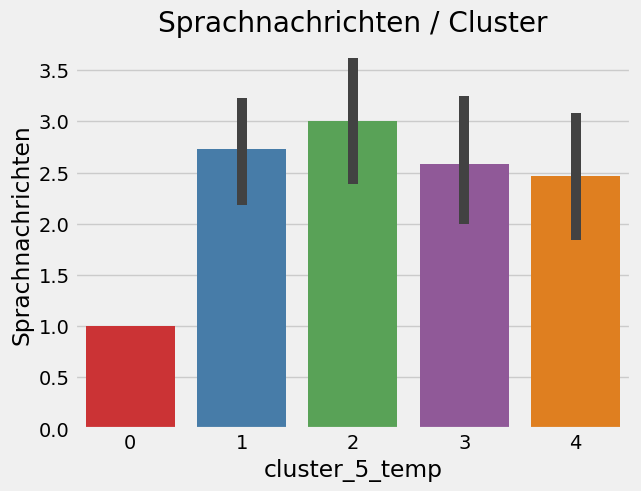

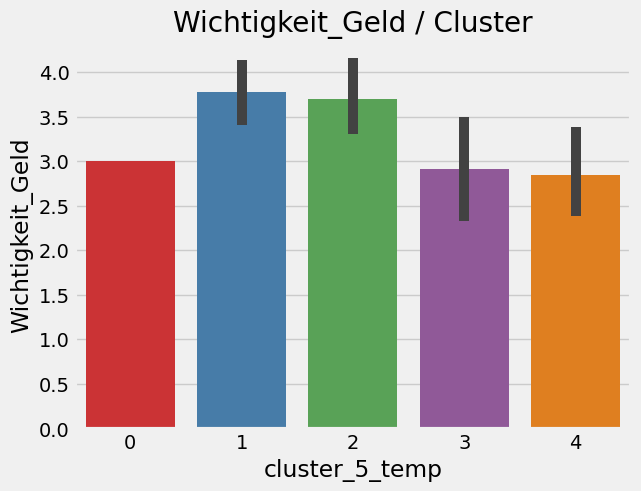

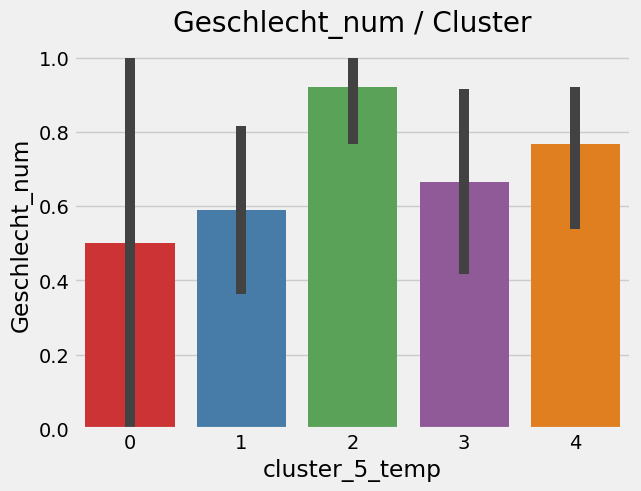

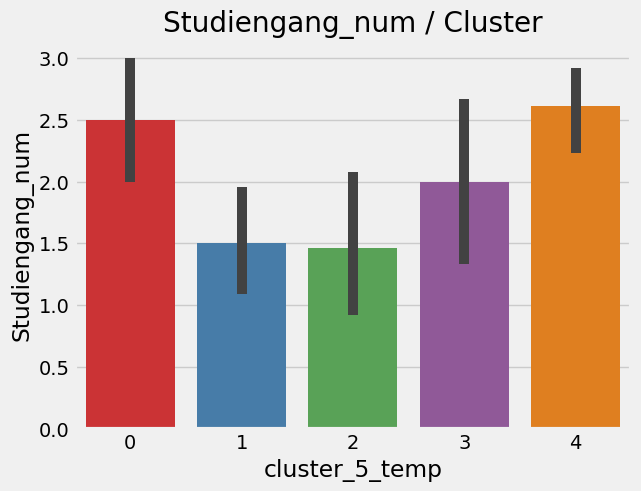

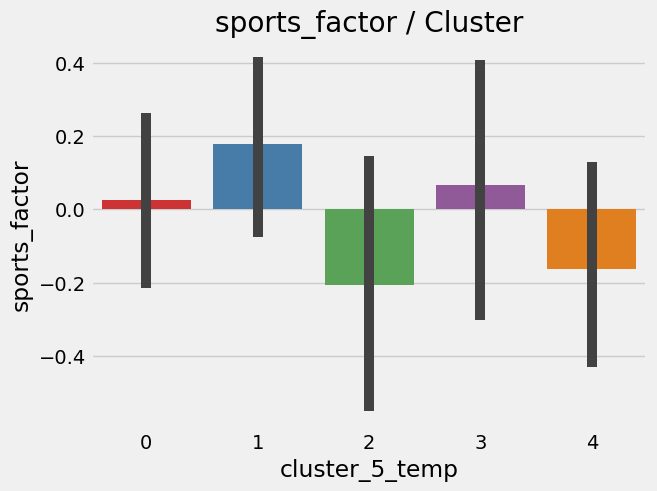

In [209]:
check_clustering(category_list=[data_num_wsf], clusters=5, show_cluster_bars=True)

Axes(0.08,0.07;0.87x0.81)


Index(['Filme', 'Alter', 'Studium_Zweifel', 'Studium_Zufriedenheit',
       'Geduldig', 'Lesen', 'Sprachnachrichten', 'Neugier_Lebensmittel',
       'Soziale_Medien', 'Gesunde_Ernaehrung', 'Geschlecht_num', 'Spontan'],
      dtype='object')

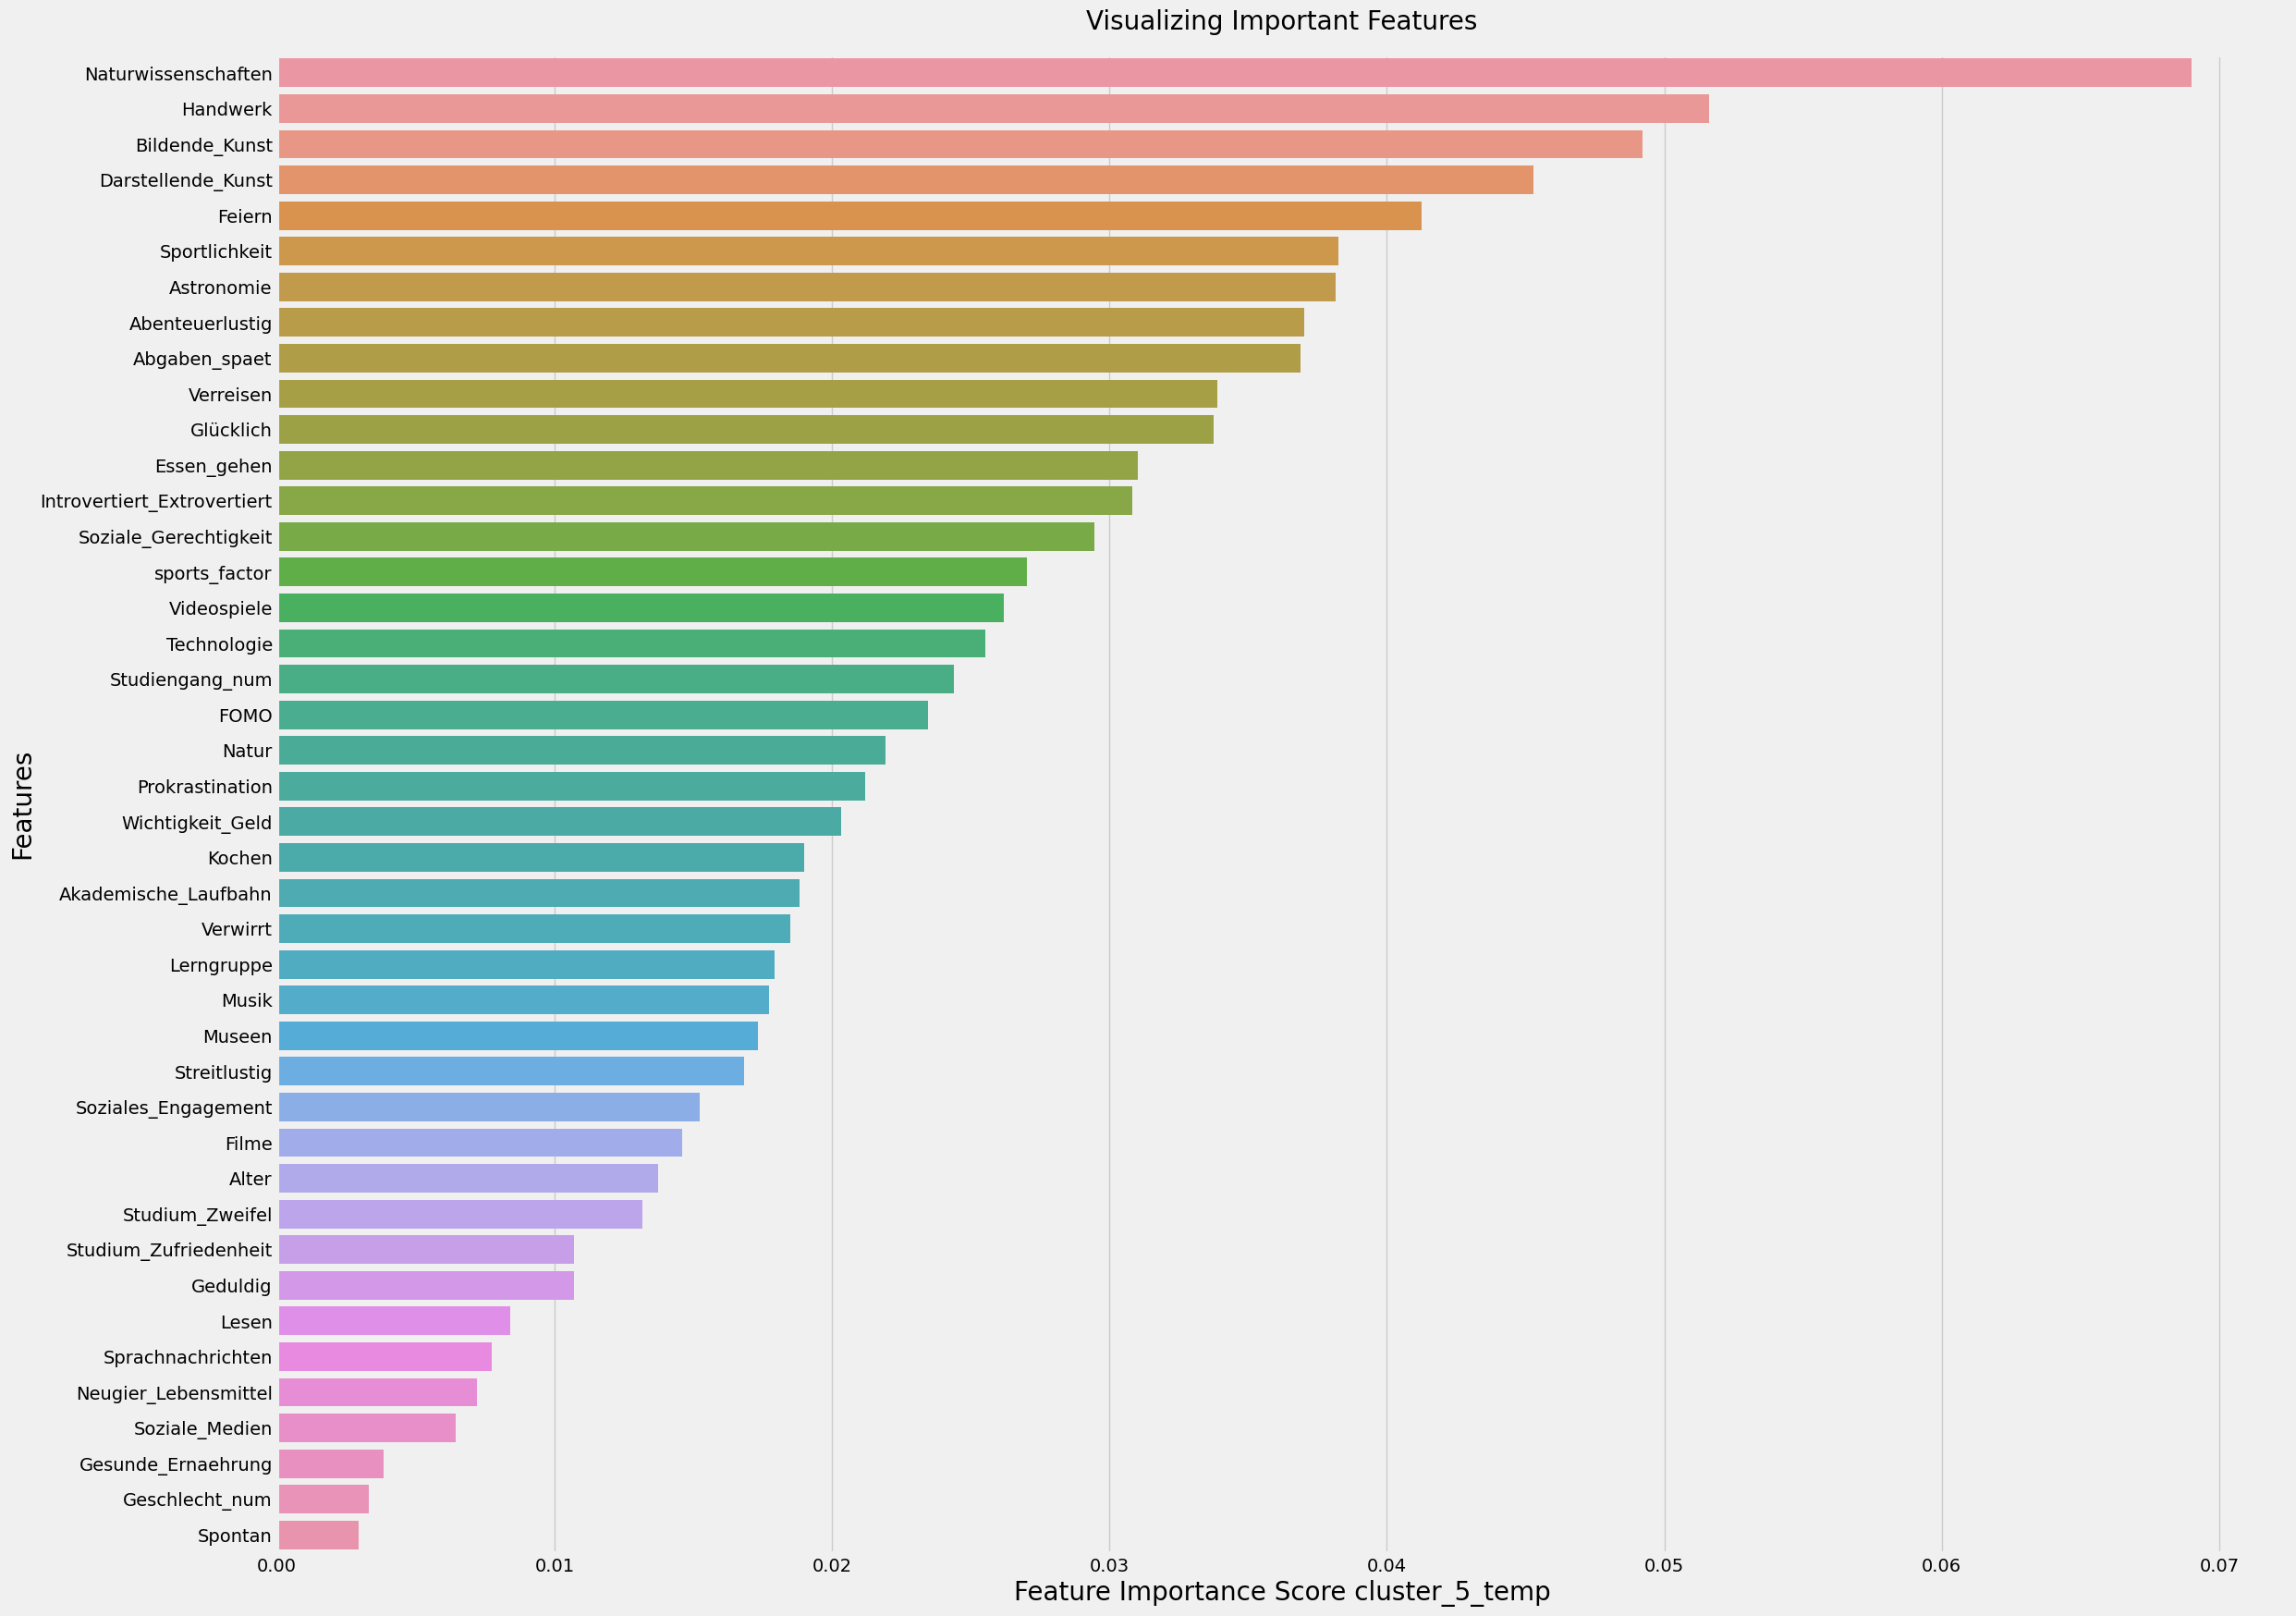

In [210]:
data_wsf_clustered_5, cluster_name_wsf_5 = scaling_and_clustering(data_num_wsf, clusters=5)
#print(data_wsf_clustered_5, cluster_name_wsf_5)
columns_to_drop_wsf_5= feature_selection(data=data_wsf_clustered_5, label_column=cluster_name_wsf_5, threshold=0.015)
columns_to_drop_wsf_5

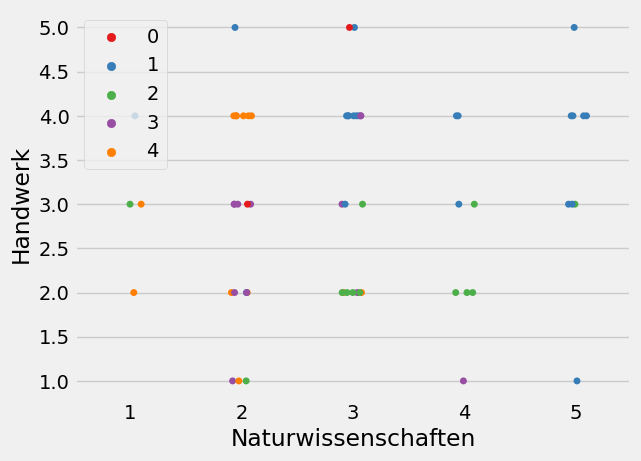

In [211]:
draw_stripplot(data_wsf_clustered_5, 'Naturwissenschaften', 'Handwerk', cluster_name_wsf_5)

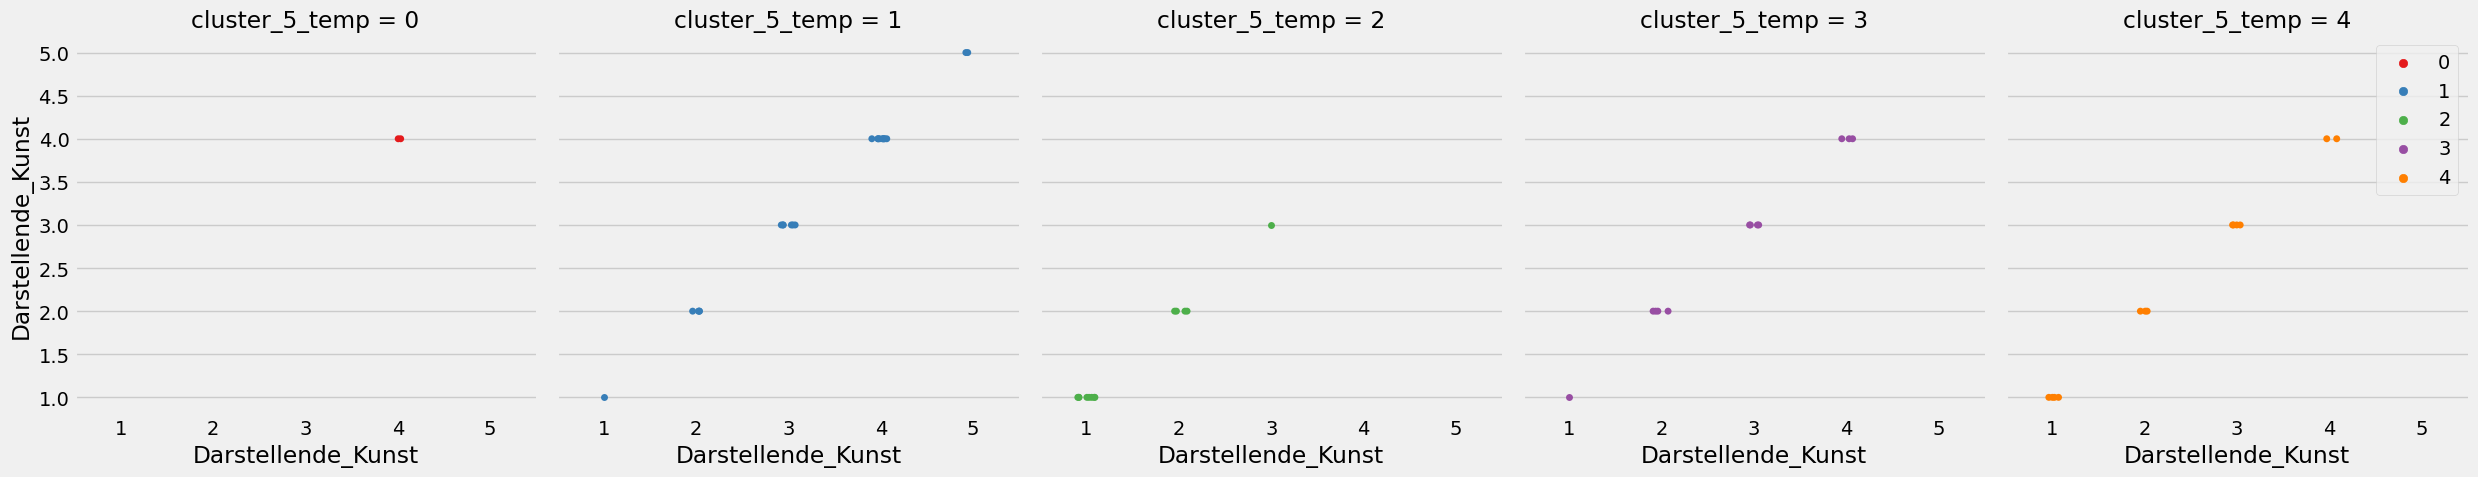

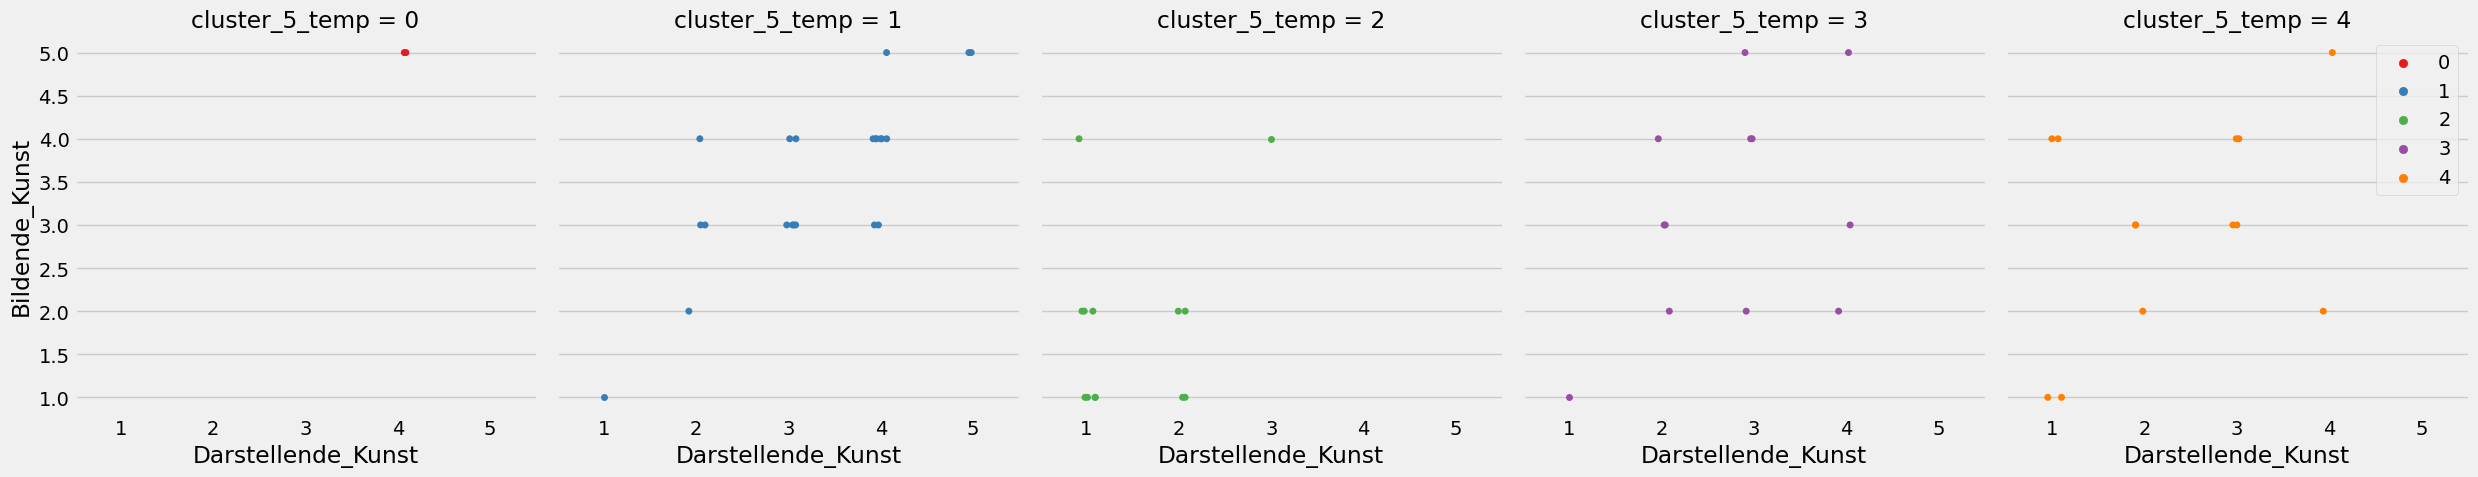

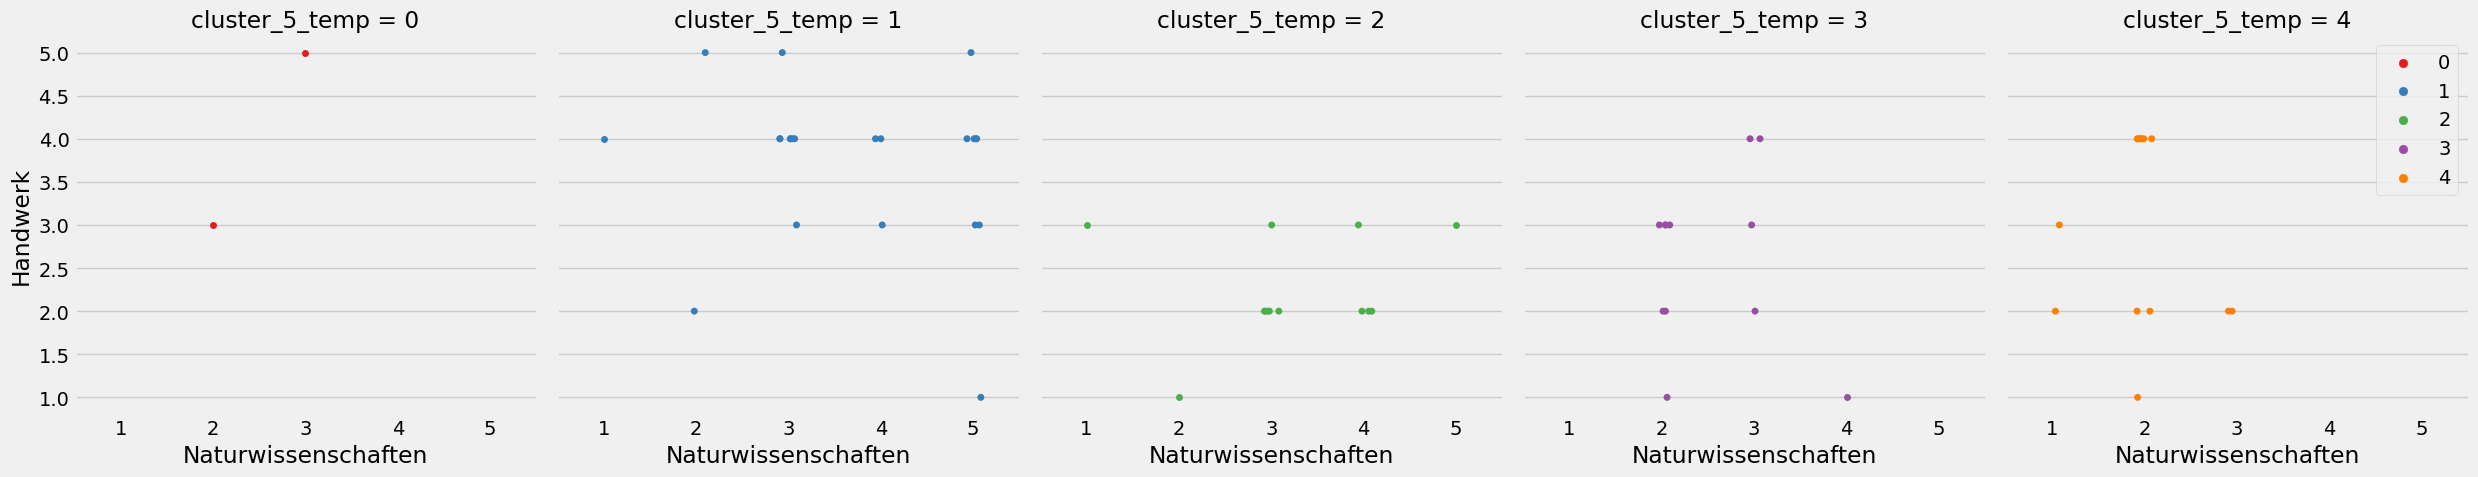

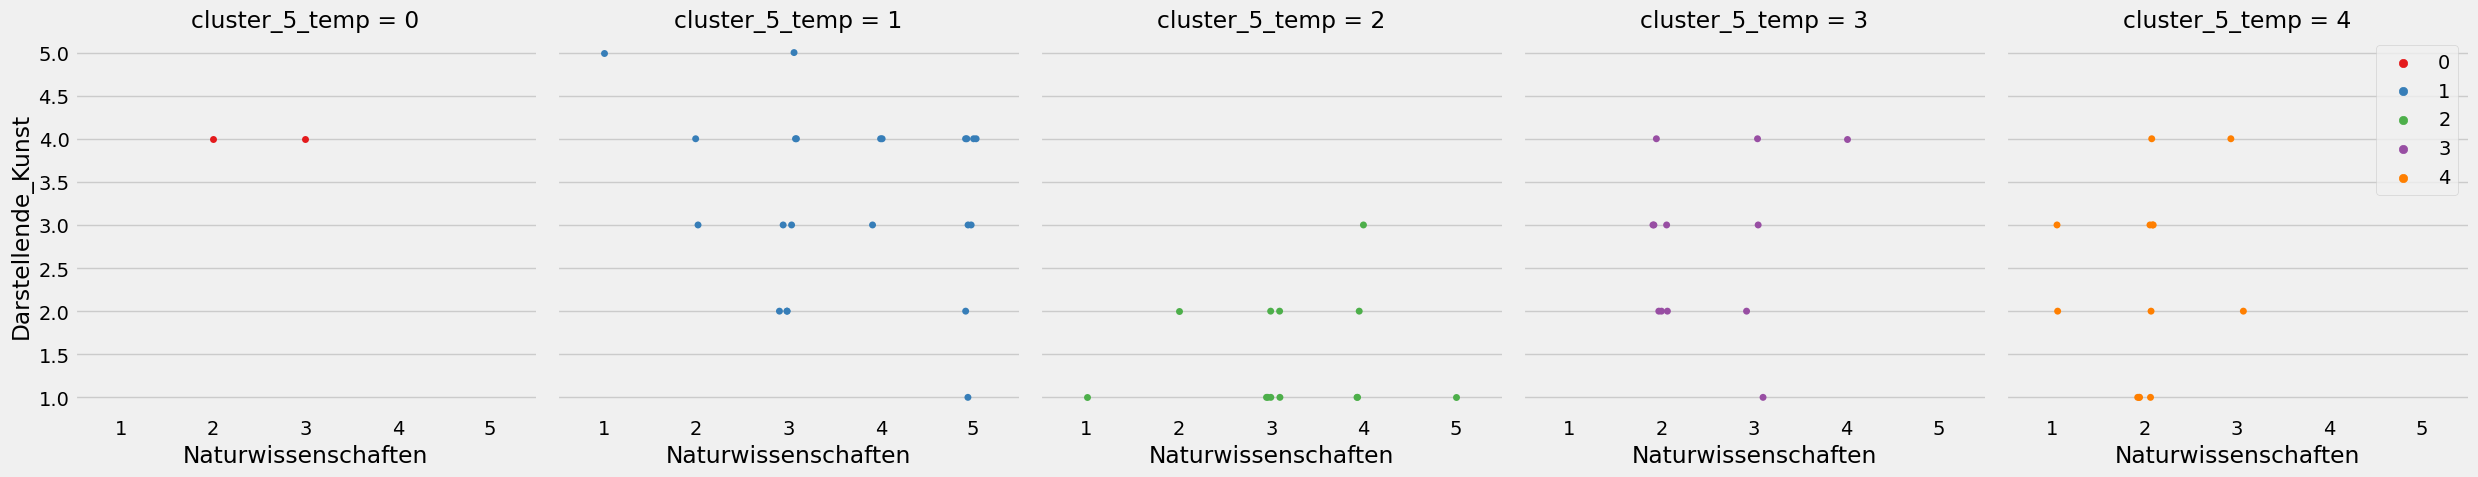

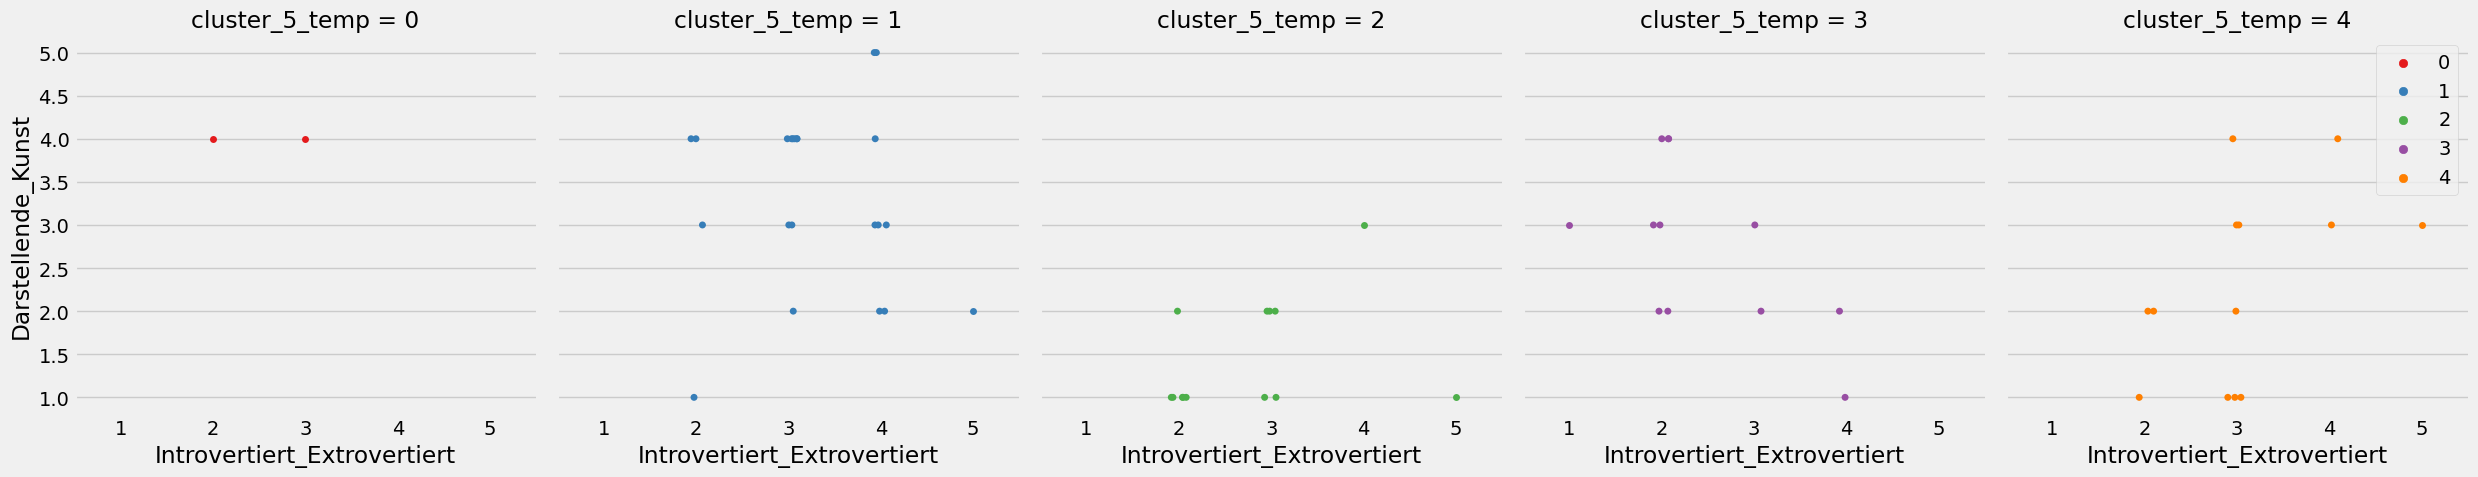

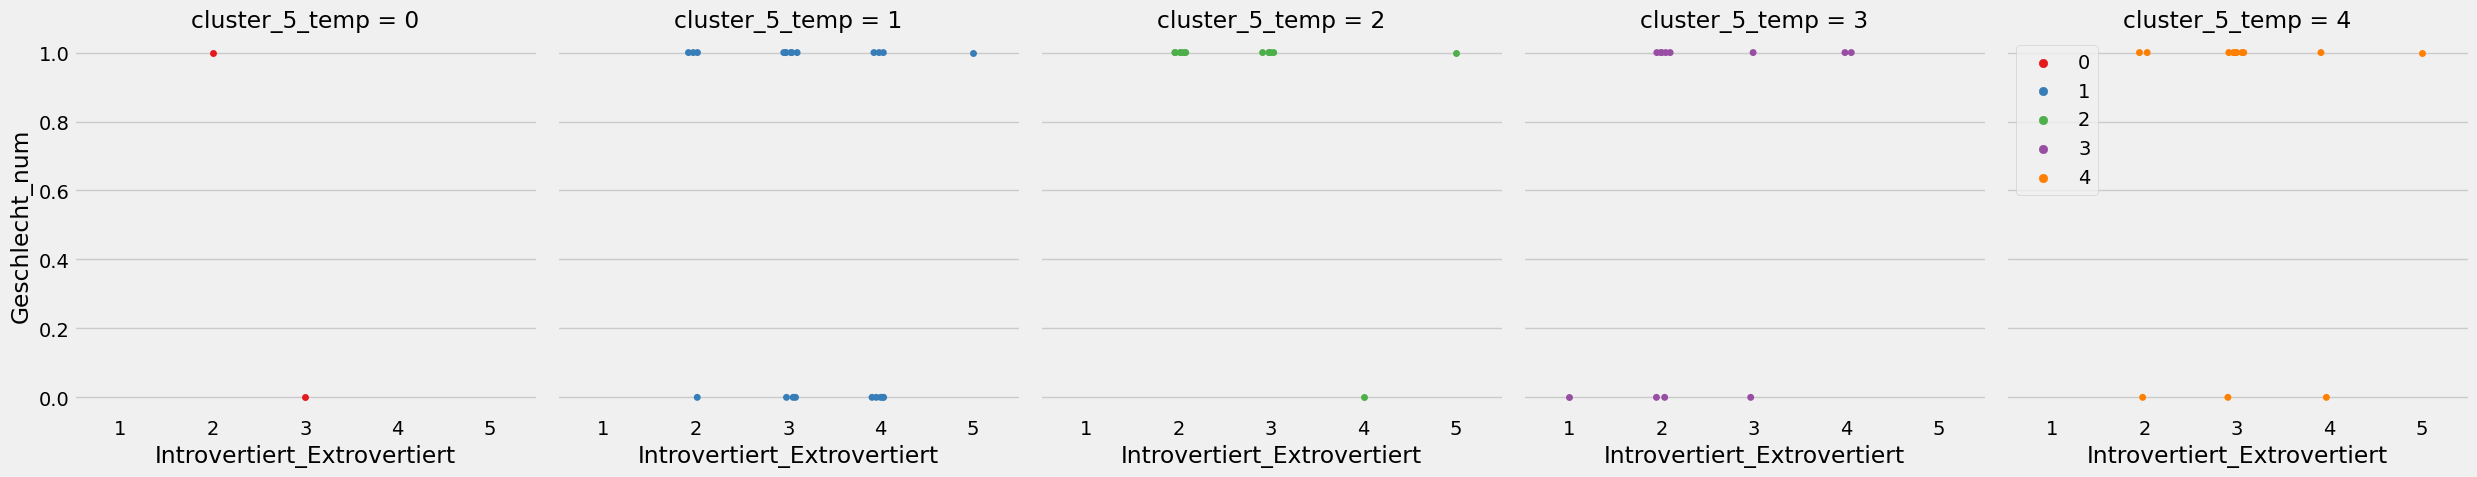

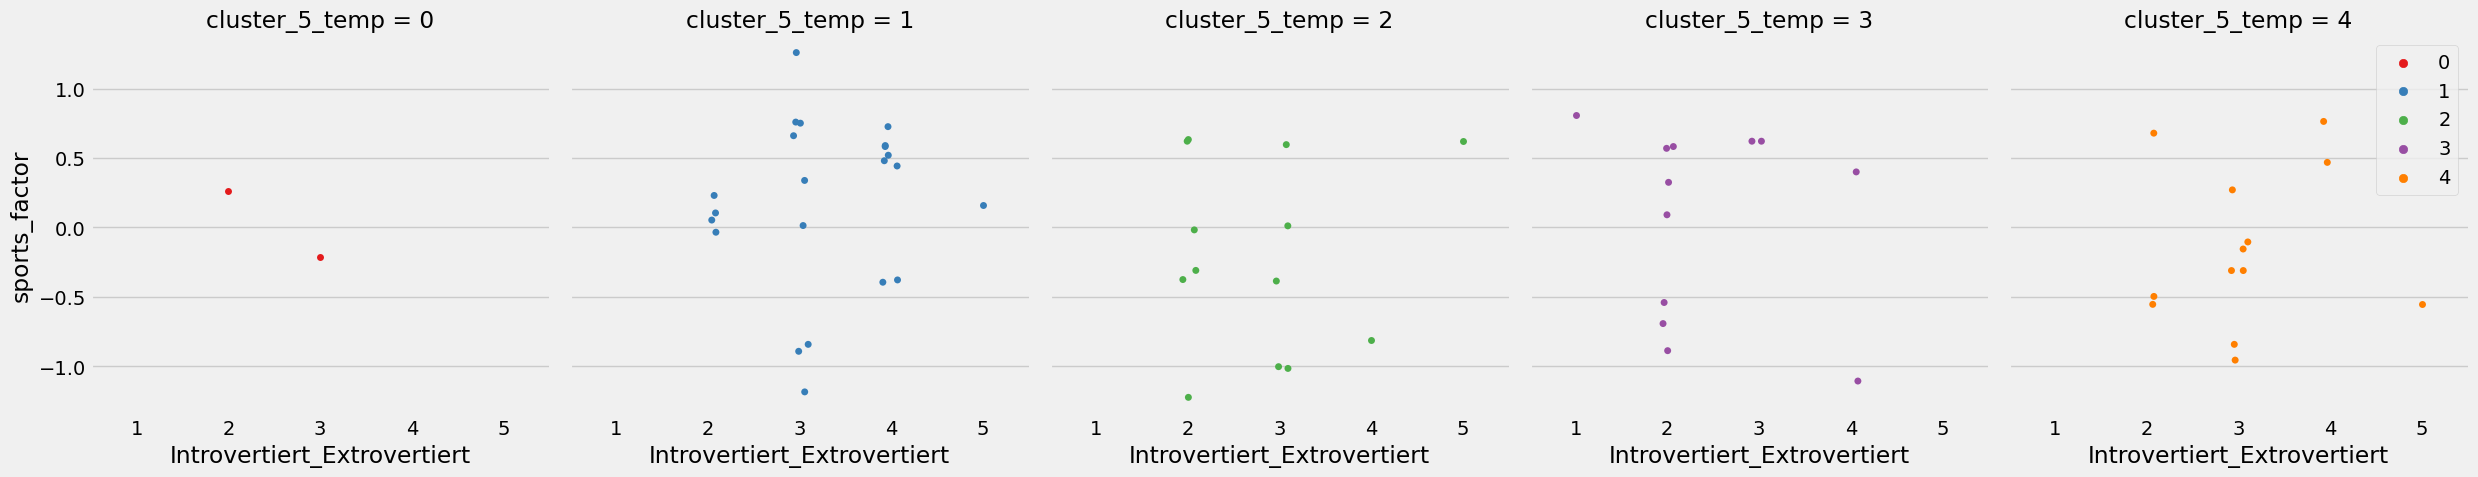

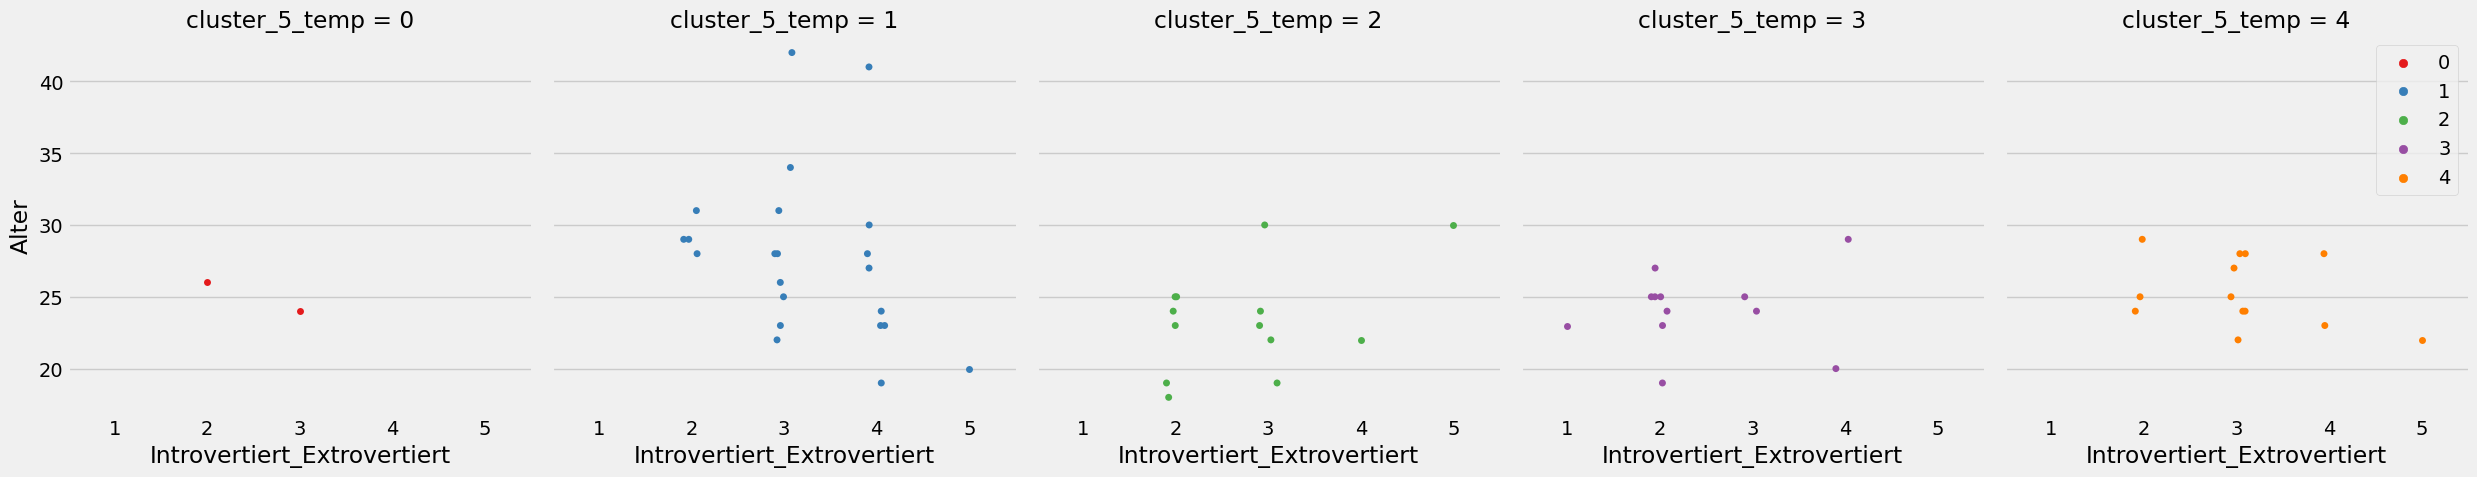

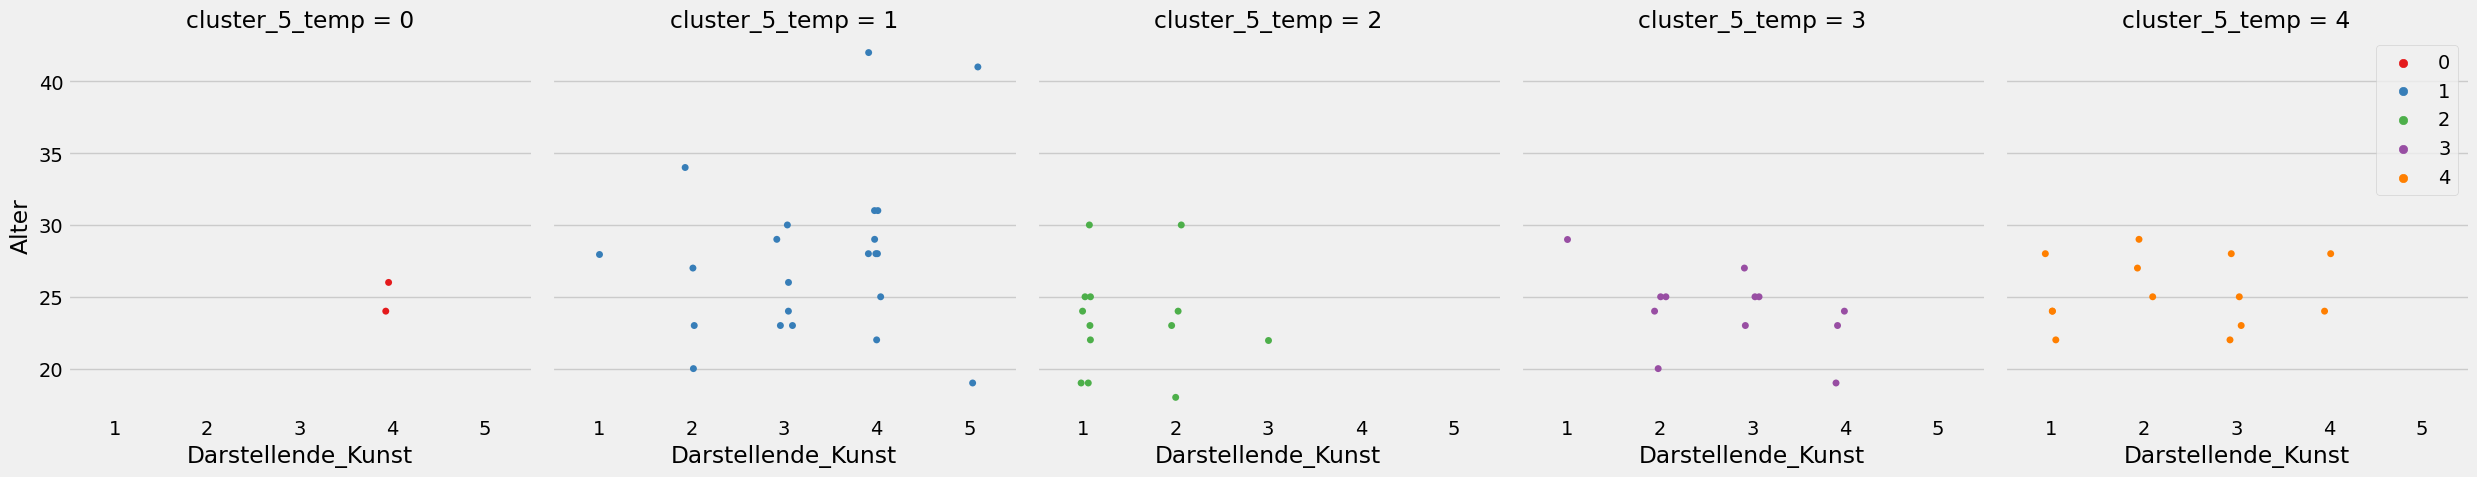

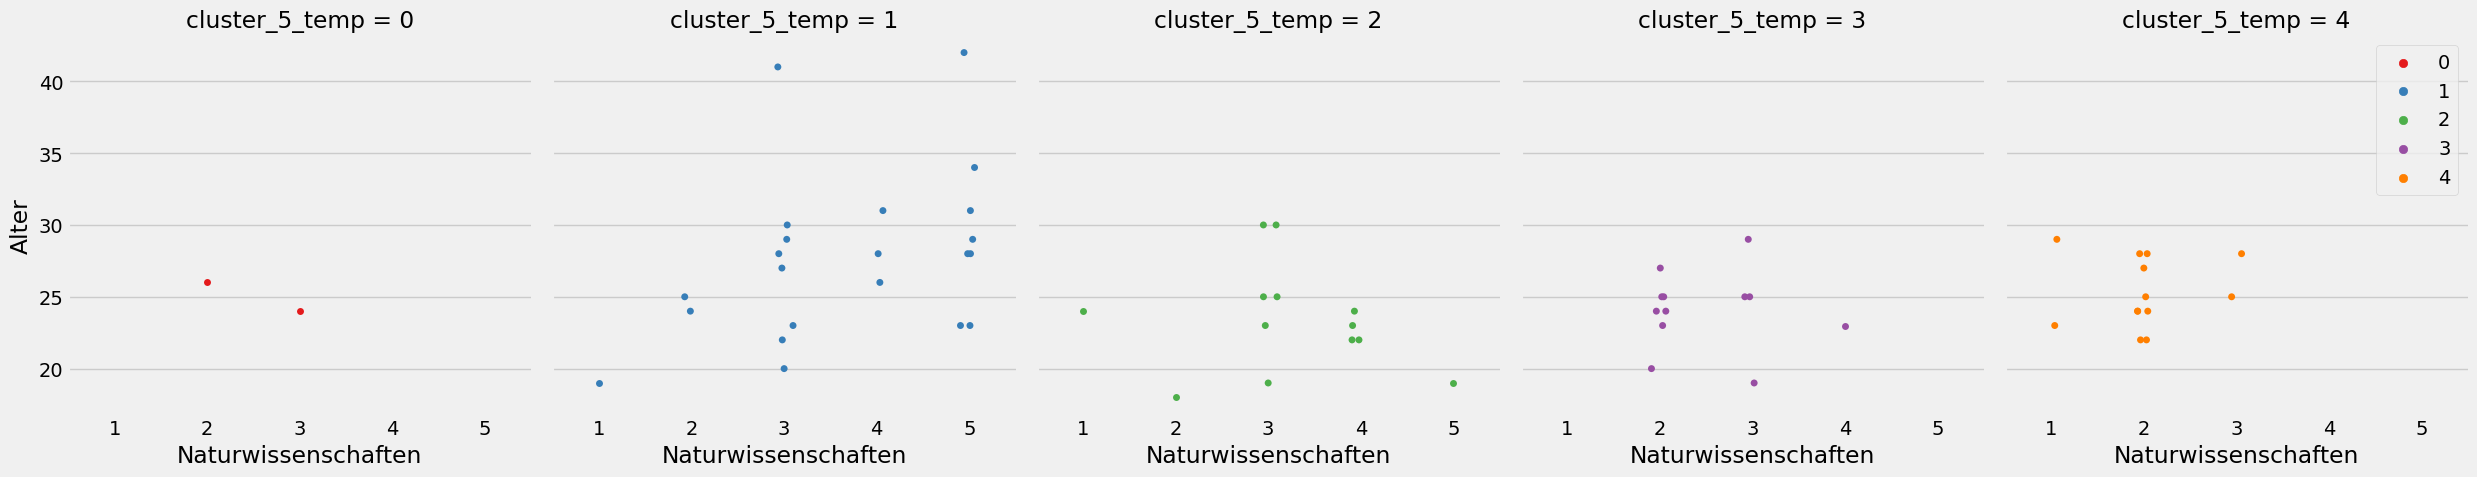

In [214]:
draw_catplot(data_wsf_clustered_5, 'Darstellende_Kunst', 'Darstellende_Kunst', cluster_name_wsf_5)
draw_catplot(data_wsf_clustered_5, 'Darstellende_Kunst', 'Bildende_Kunst', cluster_name_wsf_5)
draw_catplot(data_wsf_clustered_5, 'Naturwissenschaften', 'Handwerk', cluster_name_wsf_5)
draw_catplot(data_wsf_clustered_5, 'Naturwissenschaften', 'Darstellende_Kunst', cluster_name_wsf_5)
draw_catplot(data_wsf_clustered_5, 'Introvertiert_Extrovertiert', 'Darstellende_Kunst', cluster_name_wsf_5)
draw_catplot(data_wsf_clustered_5, 'Introvertiert_Extrovertiert', 'Geschlecht_num', cluster_name_wsf_5)
draw_catplot(data_wsf_clustered_5, 'Introvertiert_Extrovertiert', 'sports_factor', cluster_name_wsf_5)
draw_catplot(data_wsf_clustered_5, 'Introvertiert_Extrovertiert', 'Alter', cluster_name_wsf_5)
draw_catplot(data_wsf_clustered_5, 'Darstellende_Kunst', 'Alter', cluster_name_wsf_5)
draw_catplot(data_wsf_clustered_5, 'Naturwissenschaften', 'Alter', cluster_name_wsf_5)

# Hierarchical Clustering

In [217]:
import scipy.cluster.hierarchy as shc
import matplotlib.pyplot as plt

## all numerical columns

In [220]:
#TODO: Erklärung, was das hier genau bedeutet
dimension_count = len(data_num.columns)
pca = PCA(n_components=dimension_count)
pca.fit_transform(data_num)
pca.explained_variance_ratio_.cumsum()

array([0.32409042, 0.39538798, 0.46383237, 0.52099133, 0.5687165 ,
       0.60685097, 0.63986235, 0.67130877, 0.69966724, 0.72591445,
       0.74998489, 0.7708285 , 0.78991765, 0.80782847, 0.82536813,
       0.84168165, 0.85679317, 0.86938603, 0.88093007, 0.8916587 ,
       0.90234062, 0.91162622, 0.92065479, 0.9289716 , 0.93703418,
       0.94423105, 0.9499658 , 0.95525999, 0.96047165, 0.96493301,
       0.96929096, 0.97289044, 0.97619326, 0.97904822, 0.98180288,
       0.98417006, 0.98631205, 0.98828271, 0.99001105, 0.99157542,
       0.99297796, 0.99406359, 0.99499142, 0.99583693, 0.9965466 ,
       0.99721824, 0.99783013, 0.99836236, 0.99873892, 0.99902713,
       0.99929071, 0.99953571, 0.99966834, 0.99978365, 0.99986459,
       0.999934  , 0.99997328, 0.99999444, 1.        ])

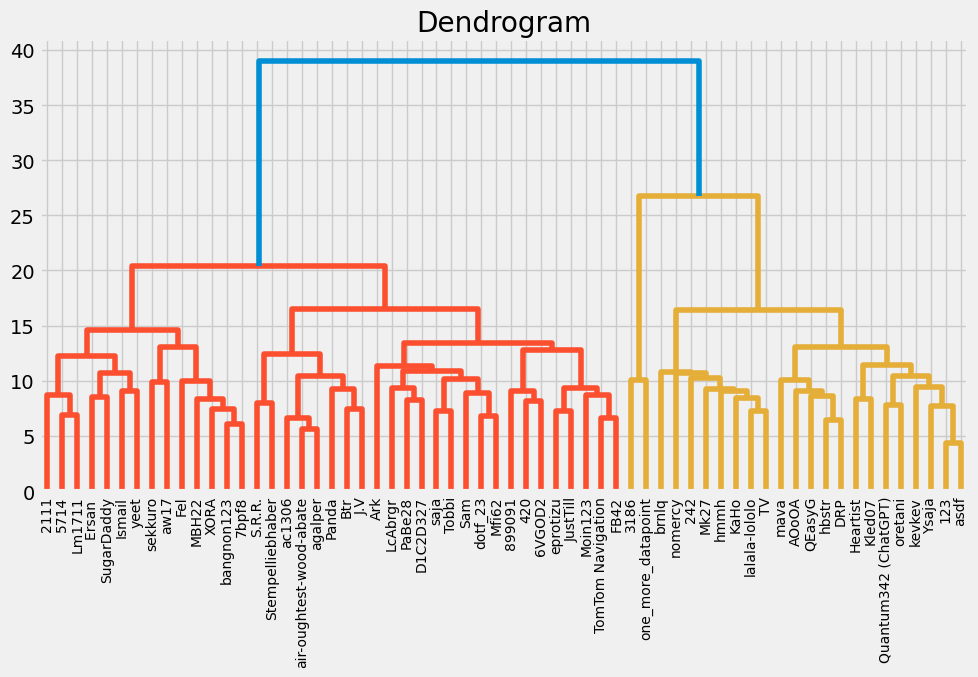

In [218]:
plt.figure(figsize=(10, 7))
plt.title("Dendrogram")

# erst mal alle Daten aus den numerical columns verwenden
selected_data = data_num
clusters = shc.linkage(selected_data, 
            method='ward', 
            metric="euclidean")

# Extracting pseudonyms for labeling
labels = data["Pseudonym"].values

shc.dendrogram(Z=clusters, labels=labels, orientation='top')
plt.xticks(rotation=90, fontsize=10)  # Rotate x-axis labels for better visibility
plt.tight_layout()       # Adjust layout to prevent label overlap
plt.show()

## numerical columns with sports_factor

In [ ]:
#TODO: Erklärung, was das hier genau bedeutet
dimension_count = len(data_num.columns)
pca = PCA(n_components=dimension_count)
pca.fit_transform(data_num)
pca.explained_variance_ratio_.cumsum()

In [221]:
from sklearn.cluster import AgglomerativeClustering

clustering_model = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='ward')
clustering_model.fit(selected_data)
clustering_model.labels_

array([1, 1, 0, 0, 0, 1, 2, 0, 2, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0], dtype=int64)

C:\Users\marin\anaconda3\envs\data_science\lib\site-packages\seaborn\categorical.py:3150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if legend and (hue is not None) and (hue not in [x, row, col]):


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

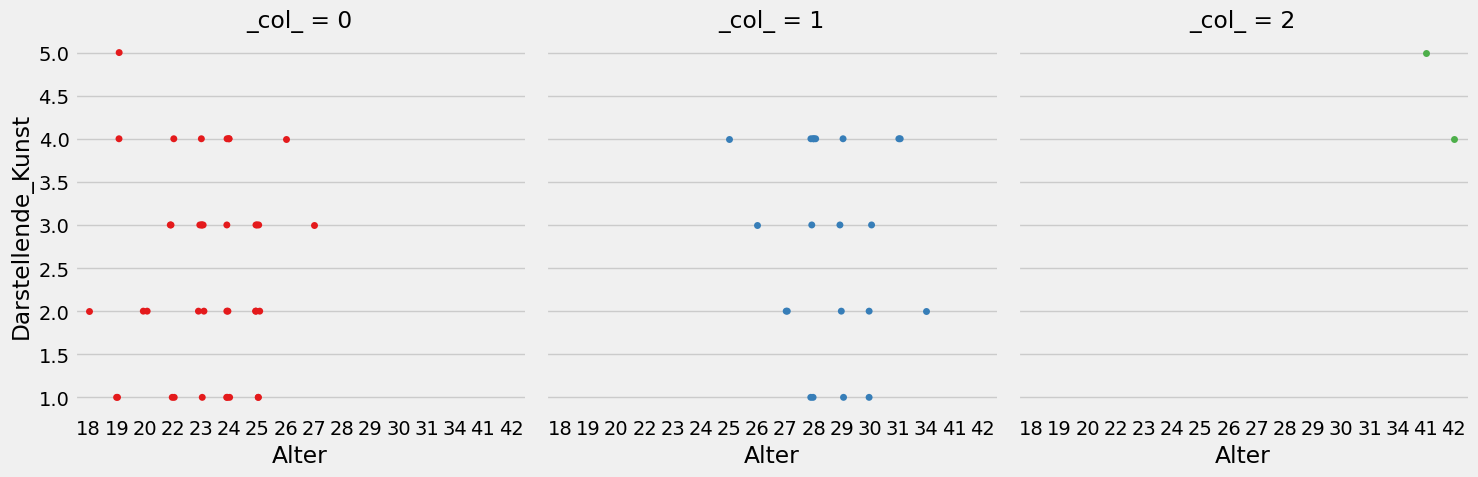

In [223]:
data_labels = clustering_model.labels_

ax = sb.catplot(data = selected_data,
                        x='Alter',
                        y='Darstellende_Kunst',
                        hue=data_labels,
                        palette="Set1", 
                       col=data_labels)
                    #ax.set_title(category_columns_temp[index_j] + " und " + category_columns_temp[index])
plt.legend()
plt.show()



Text(0.5, 1.0, 'Labeled Customer Data')

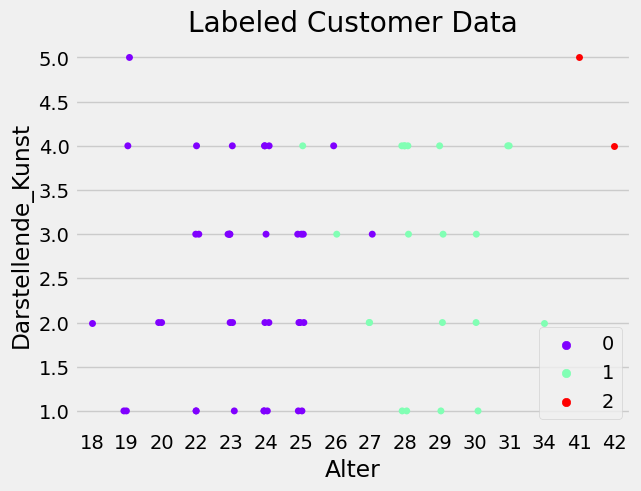

In [225]:
sb.stripplot(x='Alter', 
                y='Darstellende_Kunst', 
                data=selected_data, 
                hue=data_labels,
                palette="rainbow").set_title('Labeled Customer Data')